Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Interactive namespace is empty.


Enter the path to suite2p outputs: F:\Mesoscope_Analysis_III_Jul15_2020-Sept01_2020\3056_E235_A1V1M2\3056_200923_E235_0_5_1_HAL_Sept2920\suite2p_out\suite2p\plane0
Enter the path for behav npys, all in one folder: F:\Mesoscope_Analysis_III_Jul15_2020-Sept01_2020\3056_E235_A1V1M2\3056_200923_E235_0_5_1_HAL_Sept2920\behavior_mat_npy
What was the common behavioral sampling rate? 5000
Did Matlab crash (Yes/No)? No
Did Labview crash (Yes/No)? No


Successfully created the directory F:\Mesoscope_Analysis_III_Jul15_2020-Sept01_2020\3056_E235_A1V1M2\3056_200923_E235_0_5_1_HAL_Sept2920\suite2p_out\suite2p\plane0/Nov17_2020_10_29_22 


Which cortical area is this? Rt par temp ctx
What common sampling rate do you want? (5, 10, 50, 100, or 500) 10
What is the resolution, in micrometers per pixel? 4
What size is your FOV (small, medium, or large)? large
What is the size of the x-axis in micrometers? 4000
What is the size of the y-axis in micrometers 3960


Number of cells: 3897


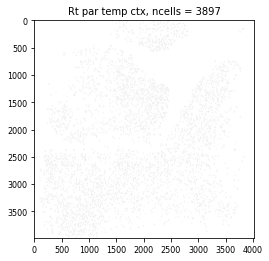

In [168]:
#load suite2p data
%reset
%whos

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from datetime import datetime

%matplotlib inline

path = input("Enter the path to suite2p outputs:")
path_behav = input("Enter the path for behav npys, all in one folder:")

brate=input("What was the common behavioral sampling rate?")
brate=int(brate)

m_crash=input("Did Matlab crash (Yes/No)?")
lv_crash=input("Did Labview crash (Yes/No)?")

#create save path
dateTimeObj=datetime.now()
dateStampStr = dateTimeObj.strftime("%b%d_%Y_%H_%M_%S")
save_path=path+"/"+dateStampStr                                    
                                    
try:
    os.mkdir(save_path)
except OSError:
    print ("Creation of the directory %s failed" % save_path)
else:
    print ("Successfully created the directory %s " % save_path)

area_name = input("Which cortical area is this?")
rate = input("What common sampling rate do you want? (5, 10, 50, 100, or 500)")
rate=int(rate)

#print(path + '/F.npy')
F = np.load(path + '/F.npy', allow_pickle=True)
Fneu = np.load(path + '/Fneu.npy', allow_pickle=True)
spks = np.load(path + '/spks.npy', allow_pickle=True)
stat = np.load(path + '/stat.npy', allow_pickle=True)
ops = np.load(path + '/ops.npy', allow_pickle=True).item()
iscell = np.load(path + '/iscell.npy', allow_pickle=True)

nROIs=F.shape[0]
npoints=F.shape[1]
ncells=0
dur=ops['nframes']/ops['fs']
#print(F[:10,:])

res=float(input("What is the resolution, in micrometers per pixel?"))
res_int=int(res)
fov_size=input("What size is your FOV (small, medium, or large)?")
x_size=input("What is the size of the x-axis in micrometers?")
y_size=input("What is the size of the y-axis in micrometers")
x_size=int(x_size)
y_size=int(y_size)

im = np.ones((ops['Lx']*res_int, ops['Ly']*res_int,3))

for n in range(0,nROIs):
    if iscell[n,0]==1:
        ncells=ncells+1
        #print(ncells)
        ypix = stat[n]['ypix'][~stat[n]['overlap']]*res_int
        xpix = stat[n]['xpix'][~stat[n]['overlap']]*res_int
        im[xpix,ypix] = 0

print("Number of cells: " + str(ncells))
plt.imshow(im)
plt.title(area_name + ", ncells = " + str(ncells), fontdict = {'fontsize' : 10})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
#plt.show()

plt.savefig(save_path+'/ROI_iscell_map_area_name.png', dpi=300, bbox_inches='tight')

#if lv_crash=Yes, load rt_whisk data to get length to which to truncate 2P data
if lv_crash=='Yes':
    try:
        rt_whisk = np.load(path_behav + '/rt_whisk.npy', allow_pickle=True)
        rt_whisk_t=np.zeros((rt_whisk.shape[0],1))
        rt_whisk_al=np.zeros((rt_whisk.shape[0],2))

        rt_whisk_t=np.linspace(0,dur,num=rt_whisk.shape[0])

        rt_whisk_al[:,0]=rt_whisk_t
        rt_whisk_al[:,1]=rt_whisk[:,0]
        dur3=np.floor(rt_whisk.shape[0]/brate)
        print(dur3)
        npoints=np.floor(dur3*ops['fs'])
        npoints=int(npoints)
        meso_trunc=dur-dur3
        
        print(F.shape)
        F=F[:,:-int(np.ceil(meso_trunc*ops['fs']))]
        Fneu=Fneu[:,:-int(np.ceil(meso_trunc*ops['fs']))]
        spks=spks[:,:-int(np.ceil(meso_trunc*ops['fs']))]
        dur=dur3
        print(F.shape)
    
    except FileNotFoundError:
        print("\nrt_whisk.npy does not exist!!")

Duration of 2P movie is 2400.0 seconds.


How many cells to test? 10


Success!


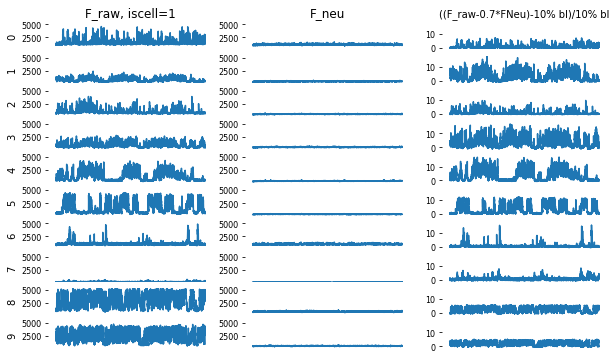

In [169]:
#suite2p data preprocessing
#dur=ops['nframes']/ops['fs']
print("Duration of 2P movie is " + str(dur) + " seconds.")

if lv_crash=='Yes':
    print("Duration of behavior is " + str(dur3) + " seconds.")

#Neuropil subtraction
F_sub=F-(0.7*Fneu)

#Baseline as 10th percentile of each subtracted trace
F_bl=np.zeros(nROIs)

for i in range(0,nROIs):
    if iscell[i,0]==1:
        F_bl[i]=np.percentile(F_sub[i],10)

#DF/F with baseline of entire trace
F_df=np.zeros((nROIs,npoints))
for i in range(0,nROIs):
    if F_bl[i]>0:
        F_df[i]=(F_sub[i]-F_bl[i])/F_bl[i]
    if F_bl[i]<=0:
        F_df[i]=(F_sub[i]-F_bl[i])/np.percentile(F_sub[i],25)

#Create array of "real" cells
F_iscell=np.zeros((ncells, npoints))
Fneu_iscell=np.zeros((ncells, npoints))
F_df_iscell=np.zeros((ncells, npoints))

j=0
for n in range(0,nROIs):
    if iscell[n,0]==1:
        F_iscell[j]=F[n]
        Fneu_iscell[j]=Fneu[n]
        F_df_iscell[j]=F_df[n]
        j=j+1

#upsample F_df_real to "rate"; might want to use Numba for this part
import scipy.signal

F_df_iscell_upsamp=np.zeros((ncells,int(rate*dur)), dtype=np.float16)
F_df_iscell_norm=np.zeros((ncells,int(rate*dur)), dtype=np.float16)

for i in range(0,ncells):
    F_df_iscell_upsamp[i]=scipy.signal.resample(F_df_iscell[i], int(rate*dur), axis=0)
    F_df_iscell_norm[i]=F_df_iscell_upsamp[i]/max(F_df_iscell_upsamp[i])
    
F_df_iscell_upsamp.astype(np.float32)
F_df_iscell_norm.astype(np.float32)

#Plot example F, Fneu, etc for iscell
cell_num = input("How many cells to test?")
cell_num=int(cell_num)
cell_start=0

fig = plt.figure(figsize=(10,6))
y_min=100000
y_max=0
df_min=0
df_max=0

for i in range(0,cell_num):
    if max(F_iscell[i])>y_max:
        y_max=max(F_iscell[i])
    if min(F_iscell[i])<y_min:
        y_min=min(F_iscell[i])
    if max(F_df_iscell[i])>df_max and max(F_df_iscell[i])<30:
        df_max=max(F_df_iscell[i])
    if min(F_df_iscell[i])<df_min:
        df_min=min(F_df_iscell[i])

for i in range(0,cell_num):
    j=i+1
    k=i+2
    l=i+3
    
    axj = fig.add_subplot(cell_num,3,1+(3*i))
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    #axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    axj.set_ylabel(i+cell_start)
    
    if i==0:
        axj.set_title('F_raw, iscell=1', fontsize=12)
        
    plt.tick_params(labelsize=8)
    plt.plot(F_iscell[i])
    
    axk = fig.add_subplot(cell_num,3,2+(3*i))
    axk.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    #axk.set_xlim(0,x_val_t)
    axk.set_ylim([y_min,y_max])
    axk.set_frame_on(False)
    #axk.set_ylabel(i+cell_start)
    
    if i==0:
        axk.set_title('F_neu',fontsize=12)
        
    plt.tick_params(labelsize=8)
    plt.plot(Fneu_iscell[i])
    
    axl = fig.add_subplot(cell_num,3,3+(3*i))
    axl.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    #axl.set_xlim(0,x_val_t)
    axl.set_ylim([df_min,df_max])
    #print(df_min)
    #print(df_max)
    axl.set_frame_on(False)
    #axl.set_ylabel(i+cell_start)
    
    if i==0:
        axl.set_title('((F_raw-0.7*FNeu)-10% bl)/10% bl',fontsize=10)
        
    plt.tick_params(labelsize=8)
    plt.plot(F_df_iscell[i])

plt.savefig(save_path+'/F_Fneu_dFF_ex_traces.png', dpi=300, bbox_inches='tight')

print("Success!")

In [170]:
#Load behavioral variables

try:
    fl_cam = np.load(path_behav + '/fl_cam.npy', allow_pickle=True)
    fl_cam_t=np.zeros((fl_cam.shape[0],1))
    fl_cam_al=np.zeros((fl_cam.shape[0],2))

    fl_cam_t=np.linspace(0,dur,num=fl_cam.shape[0])

    fl_cam_al[:,0]=fl_cam_t
    fl_cam_al[:,1]=fl_cam[:,0]
    
    fl_cam_exist=True
    
except FileNotFoundError:
    fl_cam_exist=False
    print("\nfl_cam.npy does not exist!!")

    
try:
    lft_ex = np.load(path_behav + '/lft_ex.npy', allow_pickle=True)
    lft_ex_t=np.zeros((lft_ex.shape[0],1))
    lft_ex_al=np.zeros((lft_ex.shape[0],2))

    lft_ex_t=np.linspace(0,dur,num=lft_ex.shape[0])

    lft_ex_al[:,0]=lft_ex_t
    lft_ex_al[:,1]=lft_ex[:,0]
    
except FileNotFoundError:
    print("\nlft_ex.npy does not exist!!")

    
try:
    lft_ppl = np.load(path_behav + '/lft_ppl.npy', allow_pickle=True)
    lft_ppl_t=np.zeros((lft_ppl.shape[0],1))
    lft_ppl_al=np.zeros((lft_ppl.shape[0],2))

    lft_ppl_t=np.linspace(0,dur,num=lft_ppl.shape[0])

    lft_ppl_al[:,0]=lft_ppl_t
    lft_ppl_al[:,1]=lft_ppl[:,0]

except FileNotFoundError:
    print("\nlft_ppl.npy does not exist!!")

    
try:
    lft_whisk = np.load(path_behav + '/lft_whisk.npy', allow_pickle=True)
    lft_whisk_t=np.zeros((lft_whisk.shape[0],1))
    lft_whisk_al=np.zeros((lft_whisk.shape[0],2))

    lft_whisk_t=np.linspace(0,dur,num=lft_whisk.shape[0])

    lft_whisk_al[:,0]=lft_whisk_t
    lft_whisk_al[:,1]=lft_whisk[:,0]
    
except FileNotFoundError:
    print("\nlft_whisk.npy does not exist!!")

    
try:
    lick = np.load(path_behav + '/lick.npy', allow_pickle=True)
    
except FileNotFoundError:
    print("\nlick.npy does not exist")

    
try:
    lpup_fc = np.load(path_behav + '/lpup_fc.npy', allow_pickle=True)
    lpup_fc_t=np.zeros((lpup_fc.shape[0],1))
    lpup_fc_al=np.zeros((lpup_fc.shape[0],2))

    lpup_fc_t=np.linspace(0,dur,num=lpup_fc.shape[0])

    lpup_fc_al[:,0]=lpup_fc_t
    lpup_fc_al[:,1]=lpup_fc[:,0]
    
except FileNotFoundError:
    print("\nlpup_fc.npy does not exist!!")

    
try:
    ni_pzo = np.load(path_behav + '/ni_pzo.npy', allow_pickle=True)
    ni_pzo_t=np.zeros((ni_pzo.shape[0],1))
    ni_pzo_al=np.zeros((ni_pzo.shape[0],2))

    ni_pzo_t=np.linspace(0,dur,num=ni_pzo.shape[0])

    ni_pzo_al[:,0]=ni_pzo_t
    ni_pzo_al[:,1]=ni_pzo[:,0]
    
    ni_pzo_exist=True
    
except FileNotFoundError:
    ni_pzo_exist=False
    print("\nni_pzo.npy does not exist!!")

    
try:
    p_diode = np.load(path_behav + '/p_diode.npy', allow_pickle=True)
    p_diode_t=np.zeros((p_diode.shape[0],1))
    p_diode_al=np.zeros((p_diode.shape[0],2))

    p_diode_t=np.linspace(0,dur,num=p_diode.shape[0])

    p_diode_al[:,0]=p_diode_t
    p_diode_al[:,1]=p_diode[:,0]
    
except FileNotFoundError:
    print("\np_diode.npy does not exist!!")

    
try:
    piezo_co = np.load(path_behav + '/piezo_co.npy', allow_pickle=True)
    piezo_co_t=np.zeros((piezo_co.shape[0],1))
    piezo_co_al=np.zeros((piezo_co.shape[0],2))

    piezo_co_t=np.linspace(0,dur,num=piezo_co.shape[0])

    piezo_co_al[:,0]=piezo_co_t
    piezo_co_al[:,1]=piezo_co[:,0]
    
    piezo_co_exist=True
    
except FileNotFoundError:
    piezo_co_exist=False
    print("\npiezo_co.npy does not exist!!")


try:
    rpup_fc = np.load(path_behav + '/rpup_fc.npy', allow_pickle=True)
    rpup_fc_t=np.zeros((rpup_fc.shape[0],1))
    rpup_fc_al=np.zeros((rpup_fc.shape[0],2))

    rpup_fc_t=np.linspace(0,dur,num=rpup_fc.shape[0])

    rpup_fc_al[:,0]=rpup_fc_t
    rpup_fc_al[:,1]=rpup_fc[:,0]
    
except FileNotFoundError:
    print("\nrpup_fc.npy does not exist!!")


try:
    rt_ex = np.load(path_behav + '/rt_ex.npy', allow_pickle=True)
    rt_ex_t=np.zeros((rt_ex.shape[0],1))
    rt_ex_al=np.zeros((rt_ex.shape[0],2))

    rt_ex_t=np.linspace(0,dur,num=rt_ex.shape[0])

    rt_ex_al[:,0]=rt_ex_t
    rt_ex_al[:,1]=rt_ex[:,0]
    
except FileNotFoundError:
    print("\nrt_ex.npy does not exist!!")


try:
    rt_ppl = np.load(path_behav + '/rt_ppl.npy', allow_pickle=True)
    rt_ppl_t=np.zeros((rt_ppl.shape[0],1))
    rt_ppl_al=np.zeros((rt_ppl.shape[0],2))

    rt_ppl_t=np.linspace(0,dur,num=rt_ppl.shape[0])

    rt_ppl_al[:,0]=rt_ppl_t
    rt_ppl_al[:,1]=rt_ppl[:,0]
    
except FileNotFoundError:
    print("\nrt_ppl.npy does not exist!!")

if lv_crash=='No':
    try:
        rt_whisk = np.load(path_behav + '/rt_whisk.npy', allow_pickle=True)
        rt_whisk_t=np.zeros((rt_whisk.shape[0],1))
        rt_whisk_al=np.zeros((rt_whisk.shape[0],2))

        rt_whisk_t=np.linspace(0,dur,num=rt_whisk.shape[0])

        rt_whisk_al[:,0]=rt_whisk_t
        rt_whisk_al[:,1]=rt_whisk[:,0]
    
    except FileNotFoundError:
        print("\nrt_whisk.npy does not exist!!")


try:
    sound = np.load(path_behav + '/sound.npy', allow_pickle=True)
    sound_t =np.zeros((sound.shape[0],1))
    sound_al=np.zeros((sound.shape[0],2))

    sound_t=np.linspace(0,dur,num=sound.shape[0])

    sound_al[:,0]=sound_t
    sound_al[:,1]=sound[:,0]
    
except FileNotFoundError:
    print("\nsound.npy does not exist!!")


try:
    walk = np.load(path_behav + '/walk.npy', allow_pickle=True)
    walk_t=np.zeros((walk.shape[0],1))
    walk_al=np.zeros((walk.shape[0],2))

    walk_t=np.linspace(0,dur,num=walk.shape[0])

    walk_al[:,0]=walk_t
    walk_al[:,1]=walk[:,0]
    
except FileNotFoundError:
    print("\nwalk.npy does not exist!!")

try:
    fr_cl_2p = np.load(path_behav + '/fr_cl_2p.npy', allow_pickle=True)
    fr_cl_2p_t=np.zeros((fr_cl_2p.shape[0],1))
    fr_cl_2p_al=np.zeros((fr_cl_2p.shape[0],2))

    fr_cl_2p_t=np.linspace(0,dur,num=fr_cl_2p.shape[0])

    fr_cl_2p_al[:,0]=fr_cl_2p_t
    fr_cl_2p_al[:,1]=fr_cl_2p[:,0]
    
except FileNotFoundError:
    print("\nfr_cl_2p.npy does not exist!!")
    
print(lft_whisk.shape)
print("Success!")

(12095702, 1)
Success!


In [171]:
import math as m

#assuming spike2 acq was triggered on fr_cl_2p, truncate and resample behav traces
dwn=int(brate/rate)

if lv_crash=='No':
    dur2=(rt_whisk.shape[0]/brate)
    behav_trunc=dur2-dur
else:
    #dur2=dur3
    dur2=(lft_whisk.shape[0]/brate)
    behav_trunc=dur2-dur

if fl_cam_exist!=False:
    if fl_cam.shape[0]>1000:
        if behav_trunc>0:
            fl_cam_trunc=fl_cam[:-int(np.ceil(behav_trunc*(fl_cam.shape[0]/dur2))),:]
        else:
            fl_cam_trunc=fl_cam
        fl_cam_upsamp=scipy.signal.resample(fl_cam_trunc, int(rate*dur), axis=0)

if behav_trunc>0:
    lft_ex_trunc=lft_ex[:-int(np.ceil(behav_trunc*(lft_ex.shape[0]/dur2))),:]
else:
    lft_ex_trunc=lft_ex
lft_ex_upsamp=scipy.signal.resample(lft_ex_trunc, int(rate*dur), axis=0)

if behav_trunc>0:
    lft_ppl_trunc=lft_ppl[:-int(np.ceil(behav_trunc*(lft_ppl.shape[0]/dur2))),:]
else:
    lft_ppl_trunc=lft_ppl
lft_ppl_upsamp=scipy.signal.resample(lft_ppl_trunc, int(rate*dur), axis=0)

if behav_trunc>0:
    lft_whisk_trunc=lft_whisk[:-int(np.ceil(behav_trunc*(lft_whisk.shape[0]/dur2))),:]
    #lft_whisk_trunc=lft_whisk[:-int((np.ceil(behav_trunc*(lft_whisk.shape[0]/dur2)-80))),:]
    #print(lft_whisk.shape)
    #print(dur2)
    #print(behav_trunc)
    #print(lft_whisk_trunc.shape)
else:
    lft_whisk_trunc=lft_whisk
lft_whisk_dwnsamp=lft_whisk_trunc[::dwn]

if behav_trunc>0:
    lpup_fc_trunc=lpup_fc[:-int(np.ceil(behav_trunc*(lpup_fc.shape[0]/dur2))),:]
else:
    lpup_fc_trunc=lpup_fc
lpup_fc_upsamp=scipy.signal.resample(lpup_fc_trunc, int(rate*dur), axis=0)

if ni_pzo_exist!=False:
    if behav_trunc>0:
        ni_pzo_trunc=ni_pzo[:-int(np.ceil(behav_trunc*(ni_pzo.shape[0]/dur2))),:]
    else:
        ni_pzo_trunc=ni_pzo
    ni_pzo_dwnsamp=ni_pzo_trunc[::dwn]

if behav_trunc>0:
    p_diode_trunc=p_diode[:-int(np.ceil(behav_trunc*(p_diode.shape[0]/dur2))),:]
else:
    p_diode_trunc=p_diode
p_diode_dwnsamp=p_diode_trunc[::dwn]

if piezo_co_exist!=False:
    if behav_trunc>0:
        piezo_co_trunc=piezo_co[:-int(np.ceil(behav_trunc*(piezo_co.shape[0]/dur2))),:]
    else:
        piezo_co_trunc=piezo_co
    piezo_co_dwnsamp=piezo_co_trunc[::dwn]

if behav_trunc>0:
    rpup_fc_trunc=rpup_fc[:-int(np.ceil(behav_trunc*(rpup_fc.shape[0]/dur2))),:]
else:
    rpup_fc_trunc=rpup_fc
rpup_fc_upsamp=scipy.signal.resample(rpup_fc_trunc, int(rate*dur), axis=0)

if behav_trunc>0:
    rt_ex_trunc=rt_ex[:-int(np.ceil(behav_trunc*(rt_ex.shape[0]/dur2))),:]
else:
    rt_ex_trunc=rt_ex
rt_ex_dwnsamp=rt_ex_trunc[::dwn]

if behav_trunc>0:
    rt_ppl_trunc=rt_ppl[:-int(np.ceil(behav_trunc*(rt_ppl.shape[0]/dur2))),:]
else:
    rt_ppl_trunc=rt_ppl
rt_ppl_upsamp=scipy.signal.resample(rt_ppl_trunc, int(rate*dur), axis=0)

if behav_trunc>0:
    rt_whisk_trunc=rt_whisk[:-int(np.ceil(behav_trunc*(rt_whisk.shape[0]/dur2))),:]
else:
    rt_whisk_trunc=rt_whisk
rt_whisk_dwnsamp=rt_whisk_trunc[::dwn]

if behav_trunc>0:
    sound_trunc=sound[:-int(np.ceil(behav_trunc*(sound.shape[0]/dur2))),:]
else:
    sound_trunc=sound
sound_dwnsamp=sound_trunc[::dwn]

if behav_trunc>0:
    walk_trunc=walk[:-int(np.ceil(behav_trunc*(walk.shape[0]/dur2))),:]
else:
    walk_trunc=walk
walk_dwnsamp=walk_trunc[::dwn]

if behav_trunc>0:
    #fr_cl_2p_trunc=fr_cl_2p[:-int(np.ceil(behav_trunc*(fr_cl_2p.shape[0]/dur2)-(3.06*8))),:]
    fr_cl_2p_trunc=fr_cl_2p[:-int(np.ceil(behav_trunc*(fr_cl_2p.shape[0]/dur2))),:]
else:
    fr_cl_2p_trunc=fr_cl_2p
fr_cl_2p_dwnsamp=fr_cl_2p_trunc[::dwn]


#F_df_iscell_upsamp=F_df_iscell_upsamp[:-int(np.ceil(meso_trunc*(F_df_iscell_upsamp.shape[0]/dur))),:]
#F_df_iscell_norm=F_df_iscell_norm[:-int(np.ceil(meso_trunc*(F_df_iscell_norm.shape[0]/dur))),:]

print("Total resampled 2P points is: ", F_df_iscell_upsamp[0].shape[0])
#print(lft_whisk_dwnsamp[0].shape[0])

if m_crash=="Yes":
    fr_cl_2p_dwnsamp=fr_cl_2p_dwnsamp[:-7,:]
    #walk_dwnsamp=walk_dwnsamp[:-1,:]
    sound_dwnsamp=sound_dwnsamp[:-1,:]
    #rt_whisk_dwnsamp=rt_whisk_dwnsamp[:-1,:]
    #rt_ppl_upsamp=rt_ppl_upsamp[:-1,:]
    rt_ex_dwnsamp=rt_ex_dwnsamp[:-1,:]
    #rpup_fc_upsamp=rpup_fc_upsamp[:-1,:]
    if piezo_co_exist==True:
        piezo_co_dwnsamp=piezo_co_dwnsamp[:-1,:]
    p_diode_dwnsamp=p_diode_dwnsamp[:-1,:]
    if ni_pzo_exist==True:
        ni_pzo_dwnsamp=ni_pzo_dwnsamp[:-1,:]
    lpup_fc_upsamp=lpup_fc_upsamp[:-1,:]
    lft_whisk_dwnsamp=lft_whisk_dwnsamp[:-7,:]
    #lft_ppl_upsamp=lft_ppl_upsamp[:-1,:]
    lft_ex_upsamp=lft_ex_upsamp[:-1,:]
    if fl_cam_exist==True:
        fl_cam_upsamp=fl_cam_upsamp[:-1,:]

print("Total resampled behavior points is: ", lft_whisk_dwnsamp.shape[0])
print("Success!")

Total resampled 2P points is:  24000
Total resampled behavior points is:  24000
Success!


Cell start? 0
Cell stop? 10


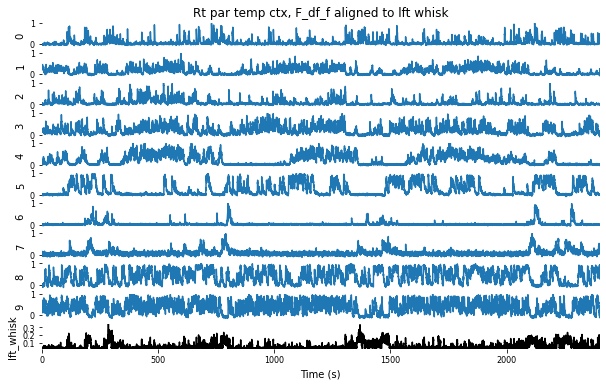

In [172]:
#test plot 2P traces and left whisker
import math as m

fig = plt.figure(figsize=(10,6))

cell_start=int(input("Cell start?"))
cell_stop=int(input("Cell stop?"))
y_min=0
y_max=0
#cell_start=30
#cell_stop=40
cell_range=cell_stop-cell_start
x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    if max(F_df_iscell_norm[i+cell_start])>y_max:
        y_max=max(F_df_iscell_norm[i+cell_start])
    if min(F_df_iscell_norm[i+cell_start])<y_min:
        y_min=min(F_df_iscell_norm[i])

for i in range(cell_range):
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    axj.set_ylabel(i+cell_start)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_iscell_norm[i+cell_start])
    if i == cell_start:
        plt.title(area_name + ", F_df_f aligned to lft whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_whisk_dwnsamp),max(lft_whisk_dwnsamp))
axj.set_ylabel('lft_whisk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_whisk_dwnsamp, color='k')
#plt.plot(x_values, trunc_lft_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/pick_n_iscell_traces_lft_whisk_align.png', dpi=300, bbox_inches='tight')

In [173]:
#Switch to pandas dataframes
norm_set=input("Do you want to use normalized df/f (Yes/No)?")
if norm_set=="Yes":
    F_df_frame=pd.DataFrame(F_df_iscell_norm).T
else:
    F_df_frame=pd.DataFrame(F_df_iscell_upsamp).T

F_df_frame.index.name='cell #'; F_df_frame.columns.name='Timepoints at '+ str(rate)
print("2P dataframe shape is:",F_df_frame.shape)

behav=['lft_whisk','rt_whisk','lft_ppl','rt_ppl','walk']
behav_arr=np.zeros((len(behav),F_df_iscell_upsamp.shape[1]))
print("Behavioral array shape is:", behav_arr.shape)

behav_arr[0,:]=lft_whisk_dwnsamp[:,0]
behav_arr[1,:]=rt_whisk_dwnsamp[:,0]
behav_arr[2,:]=lft_ppl_upsamp[:,0]
behav_arr[3,:]=rt_ppl_upsamp[:,0]
behav_arr[4,:]=walk_dwnsamp[:,0]

behav_frame=pd.DataFrame(behav_arr,index=behav).T
print("Behavioral dataframe shape is:",behav_frame.shape)

#compute correlations of behavior and 2P data
lft_whisk_corr=F_df_frame.corrwith(behav_frame['lft_whisk'])
rt_whisk_corr=F_df_frame.corrwith(behav_frame['rt_whisk'])
lft_ppl_corr=F_df_frame.corrwith(behav_frame['lft_ppl'])
rt_ppl_corr=F_df_frame.corrwith(behav_frame['rt_ppl'])
walk_corr=F_df_frame.corrwith(behav_frame['walk'])

behav_corr=np.zeros((ncells,5))
behav_corr[:,0]=lft_whisk_corr[:]
behav_corr[:,1]=rt_whisk_corr[:]
behav_corr[:,2]=lft_ppl_corr[:]
behav_corr[:,3]=rt_ppl_corr[:]
behav_corr[:,4]=walk_corr[:]

behav_corr_frame=pd.DataFrame(behav_corr, columns=behav)
behav_corr_frame

F_df_behav_frame=pd.merge(behav_corr_frame,F_df_frame.T, left_index=True, right_index=True)
print("Success!")

Do you want to use normalized df/f (Yes/No)? Yes


2P dataframe shape is: (24000, 3897)
Behavioral array shape is: (5, 24000)
Behavioral dataframe shape is: (24000, 5)
Success!


In [174]:
#create dataframes of 2P traces sorted by behavioral correlations
F_df_lft_whisk=F_df_behav_frame.sort_values(by=['lft_whisk'])
F_df_rt_whisk=F_df_behav_frame.sort_values(by=['rt_whisk'])
F_df_lft_ppl=F_df_behav_frame.sort_values(by=['lft_ppl'])
F_df_rt_ppl=F_df_behav_frame.sort_values(by=['rt_ppl'])
F_df_walk=F_df_behav_frame.sort_values(by=['walk'])

#create single array map of ROI locations
cell_loc=np.zeros((nROIs, 2))

for n in range(0,nROIs):
    stat_array=np.array(stat[n]['med'])
    cell_loc[n,0]=stat_array[0]
    cell_loc[n,1]=stat_array[1]
    
#create cell location map for "real" cells
i=0
j=0

cell_loc_real=np.zeros((ncells,2))
for i in range(cell_loc.shape[0]):
    if iscell[i,0]==1:
        cell_loc_real[j,0]=cell_loc[i,0]
        cell_loc_real[j,1]=cell_loc[i,1]
        j=j+1

cell_loc_real_frame=pd.DataFrame(cell_loc_real)

behav_corr_cell_loc_frame=pd.merge(behav_corr_frame, cell_loc_real_frame, left_index=True,
                                  right_index=True)

bcloc_lft_whisk_sort=behav_corr_cell_loc_frame.sort_values(by=['lft_whisk'])
bcloc_rt_whisk_sort=behav_corr_cell_loc_frame.sort_values(by=['rt_whisk'])
bcloc_lft_ppl_sort=behav_corr_cell_loc_frame.sort_values(by=['lft_ppl'])
bcloc_rt_ppl_sort=behav_corr_cell_loc_frame.sort_values(by=['rt_ppl'])
bcloc_walk_sort=behav_corr_cell_loc_frame.sort_values(by=['walk'])

print("Success!")

Success!


What z-score cutoff would you like to use? 1
How many x bins do you want? 5
How many y bins do you want 5


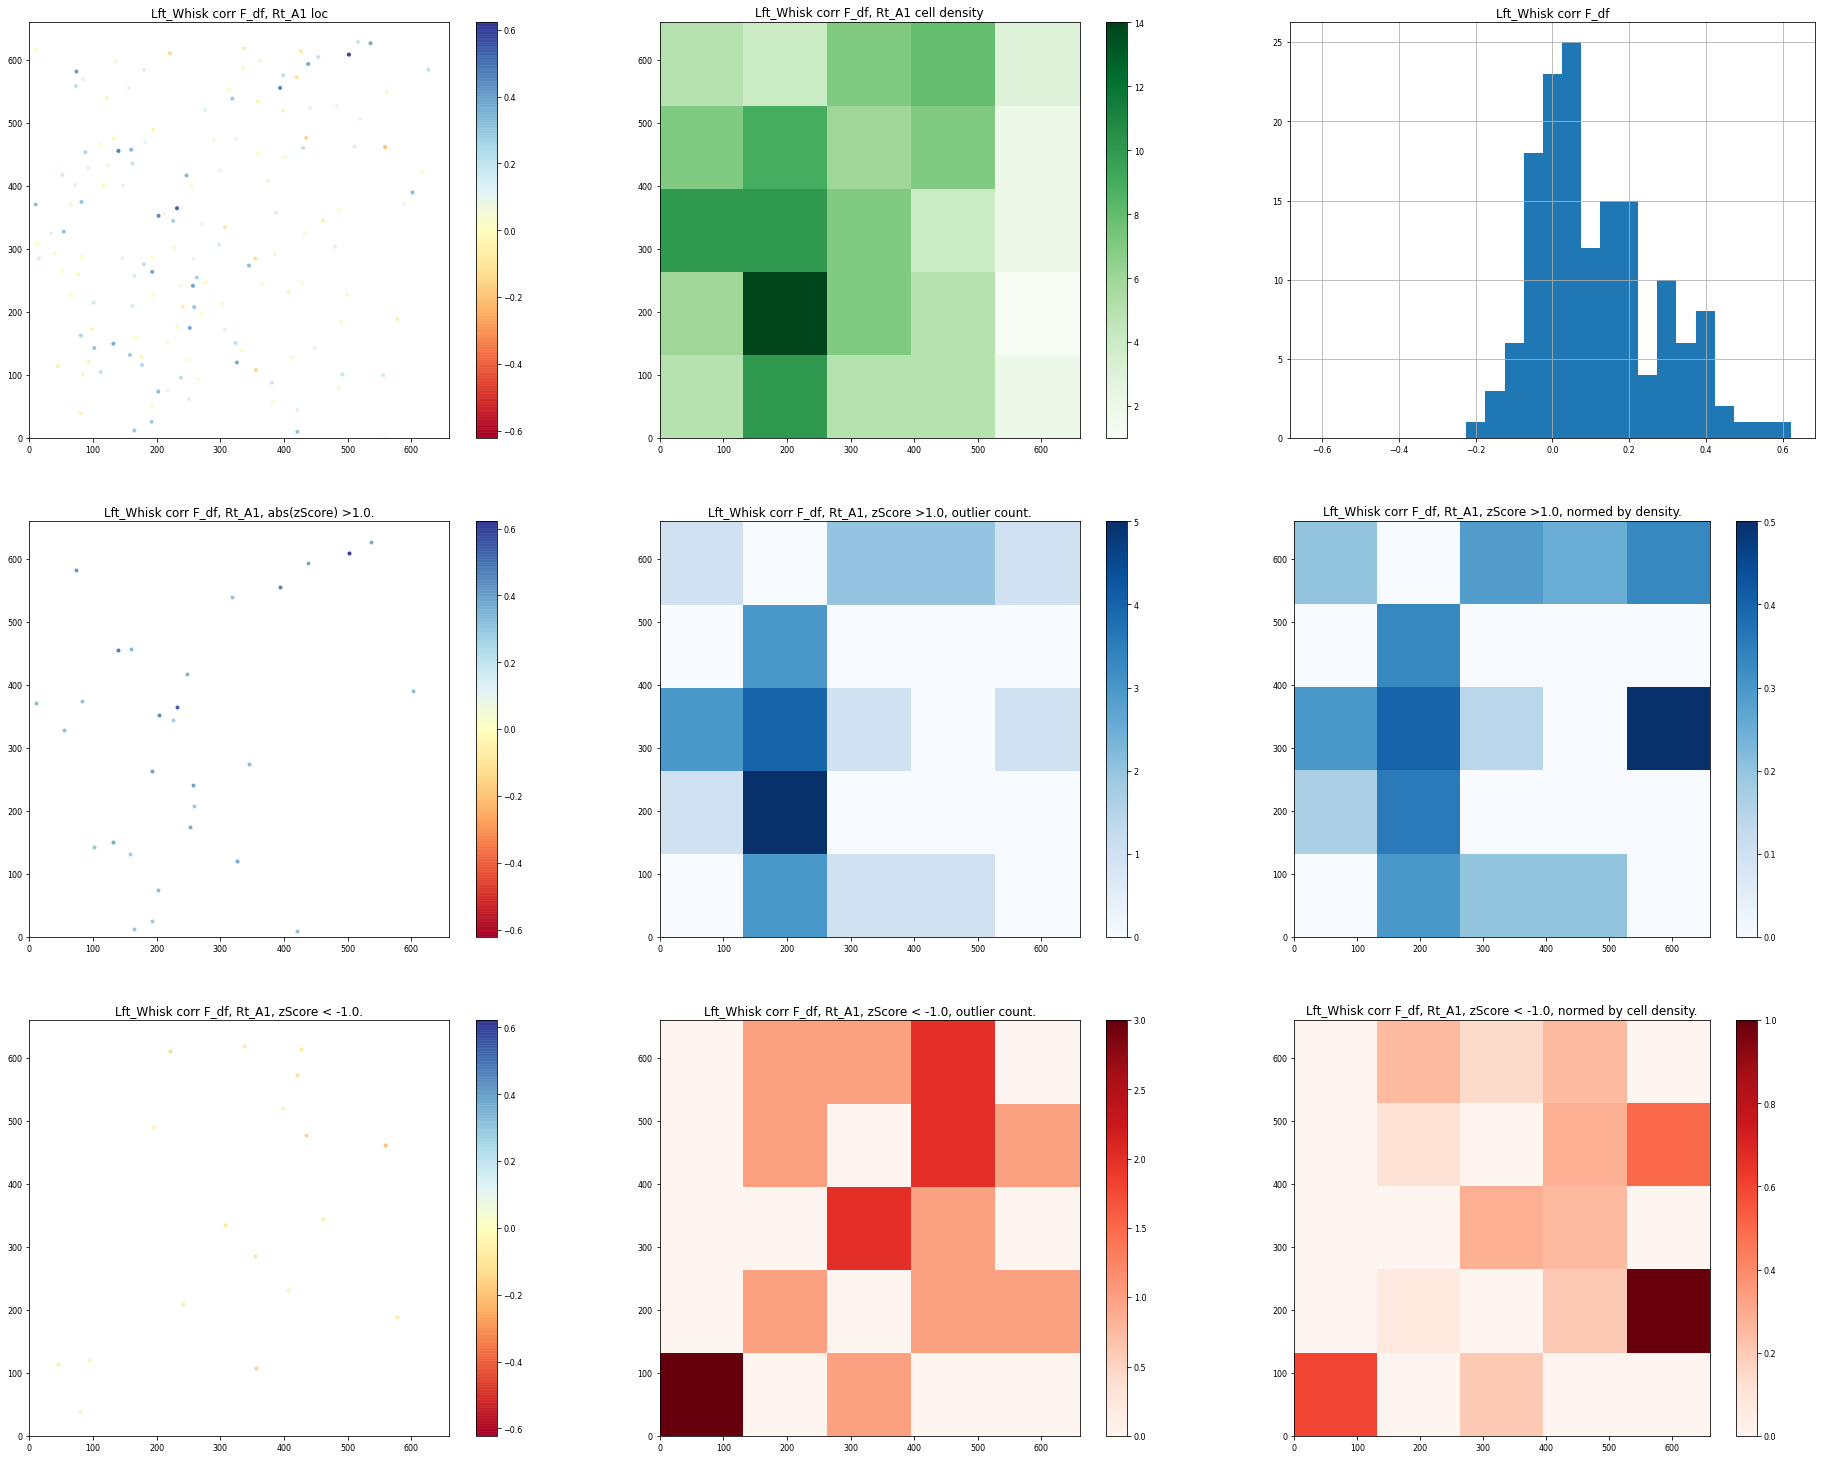

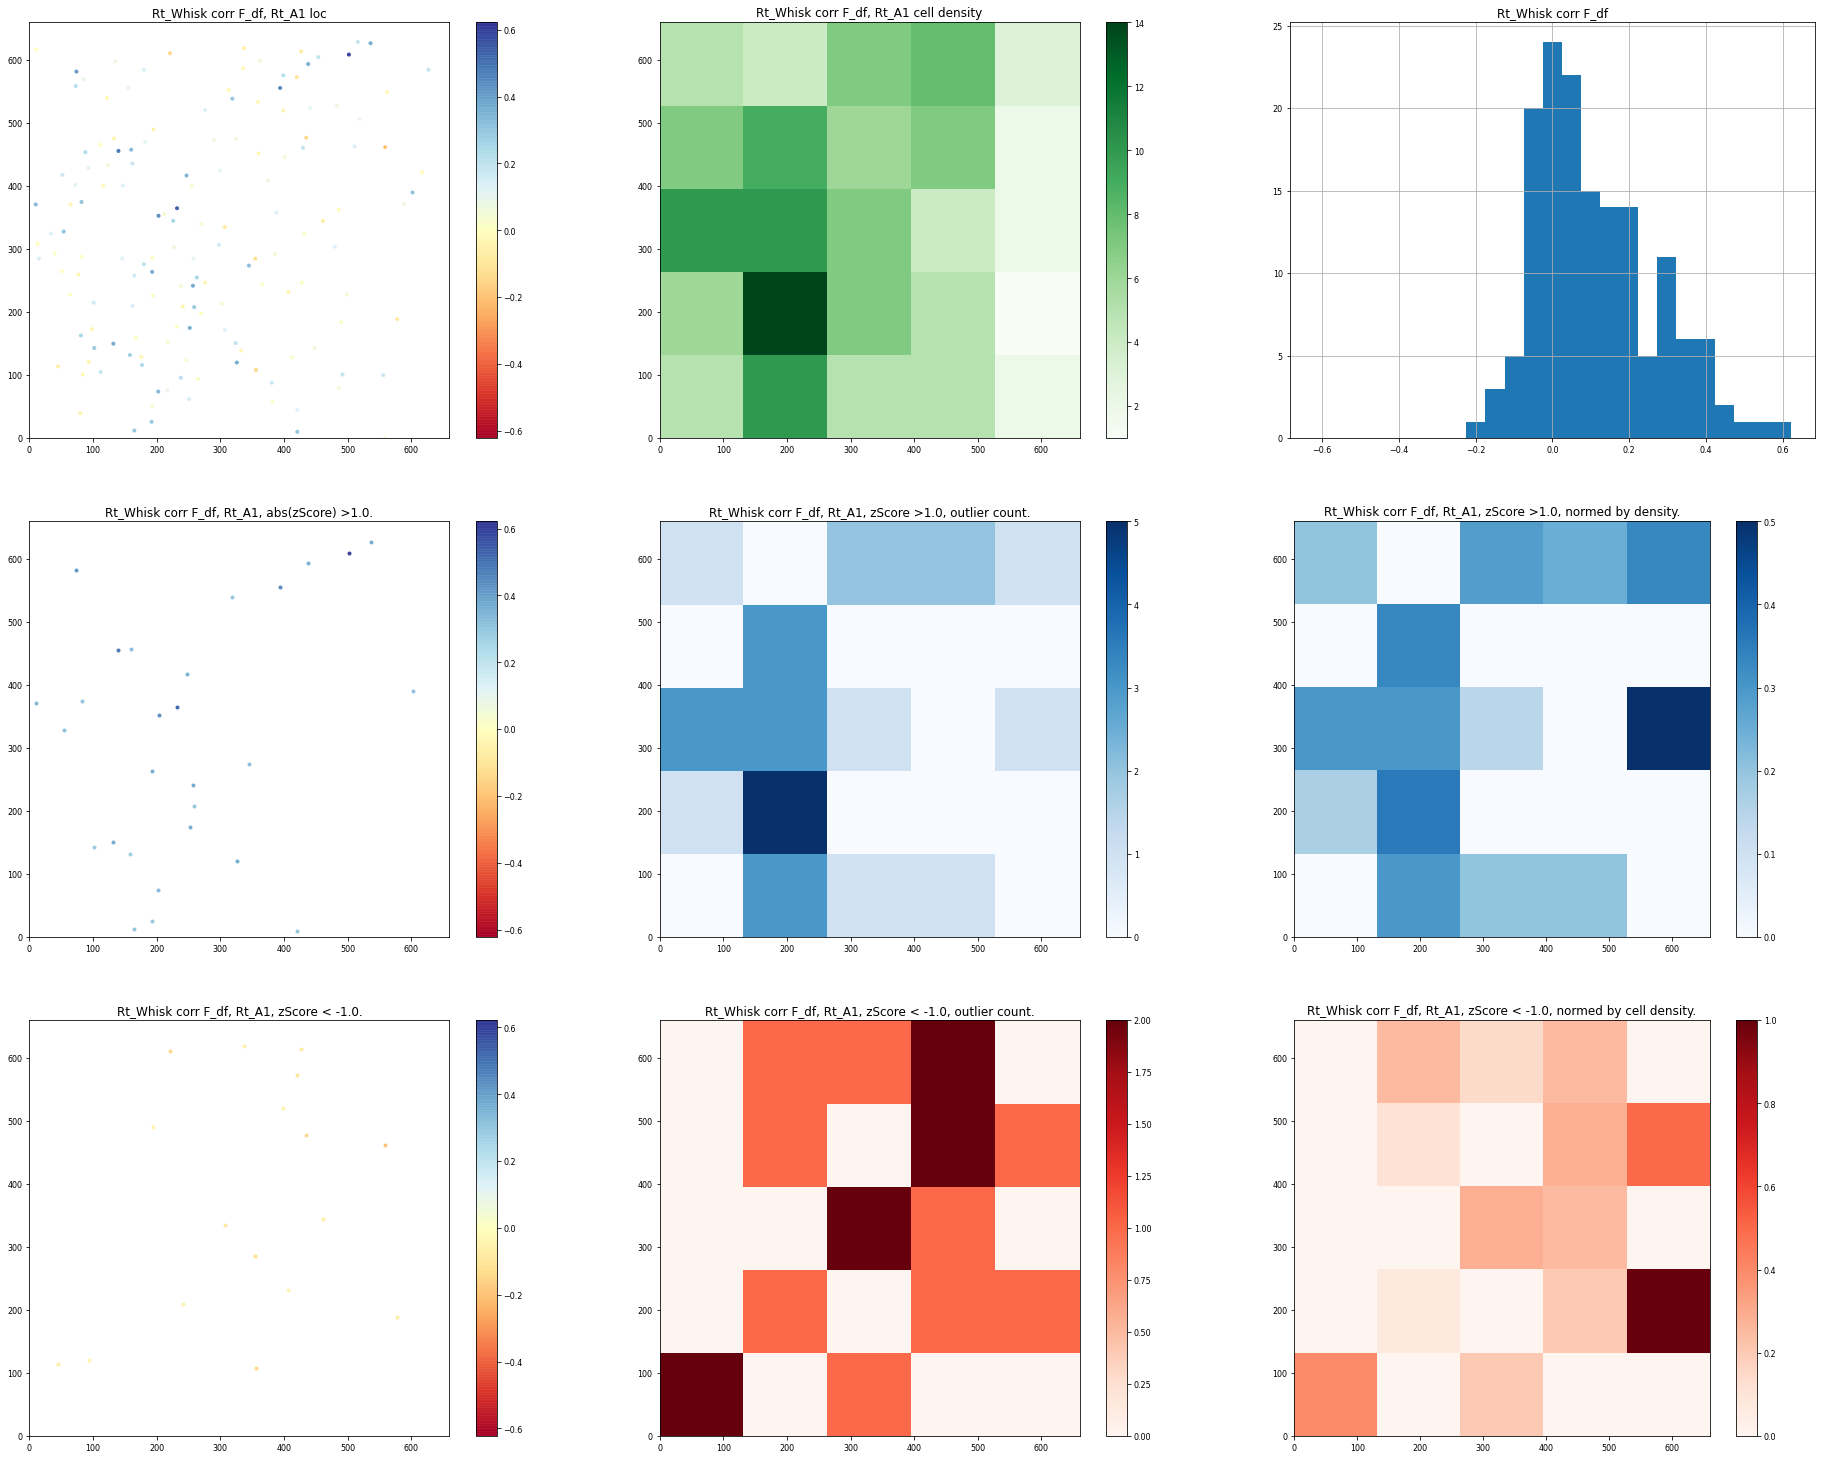

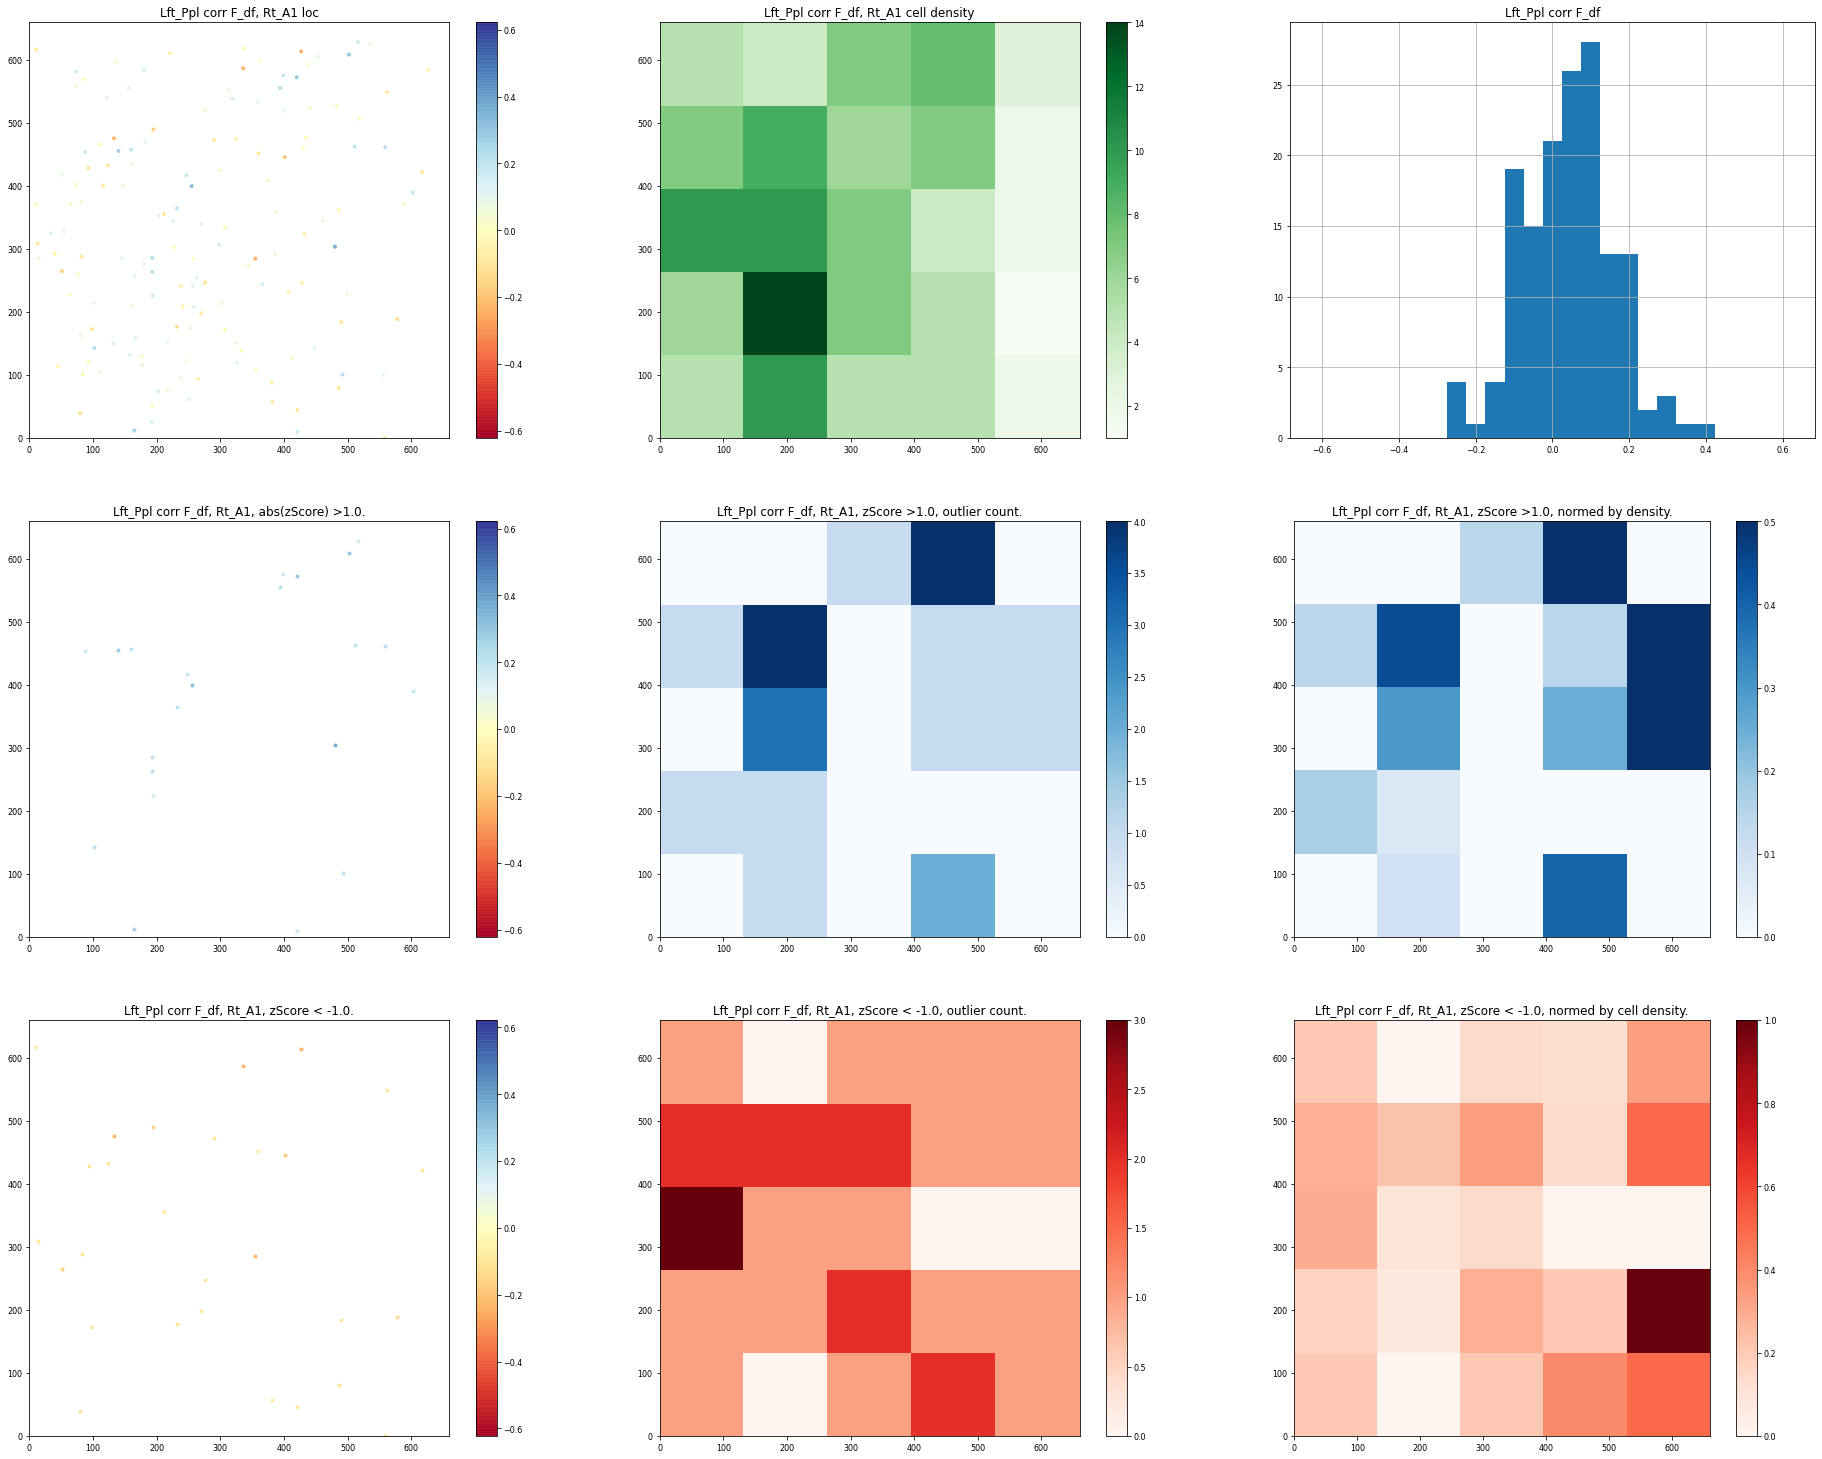

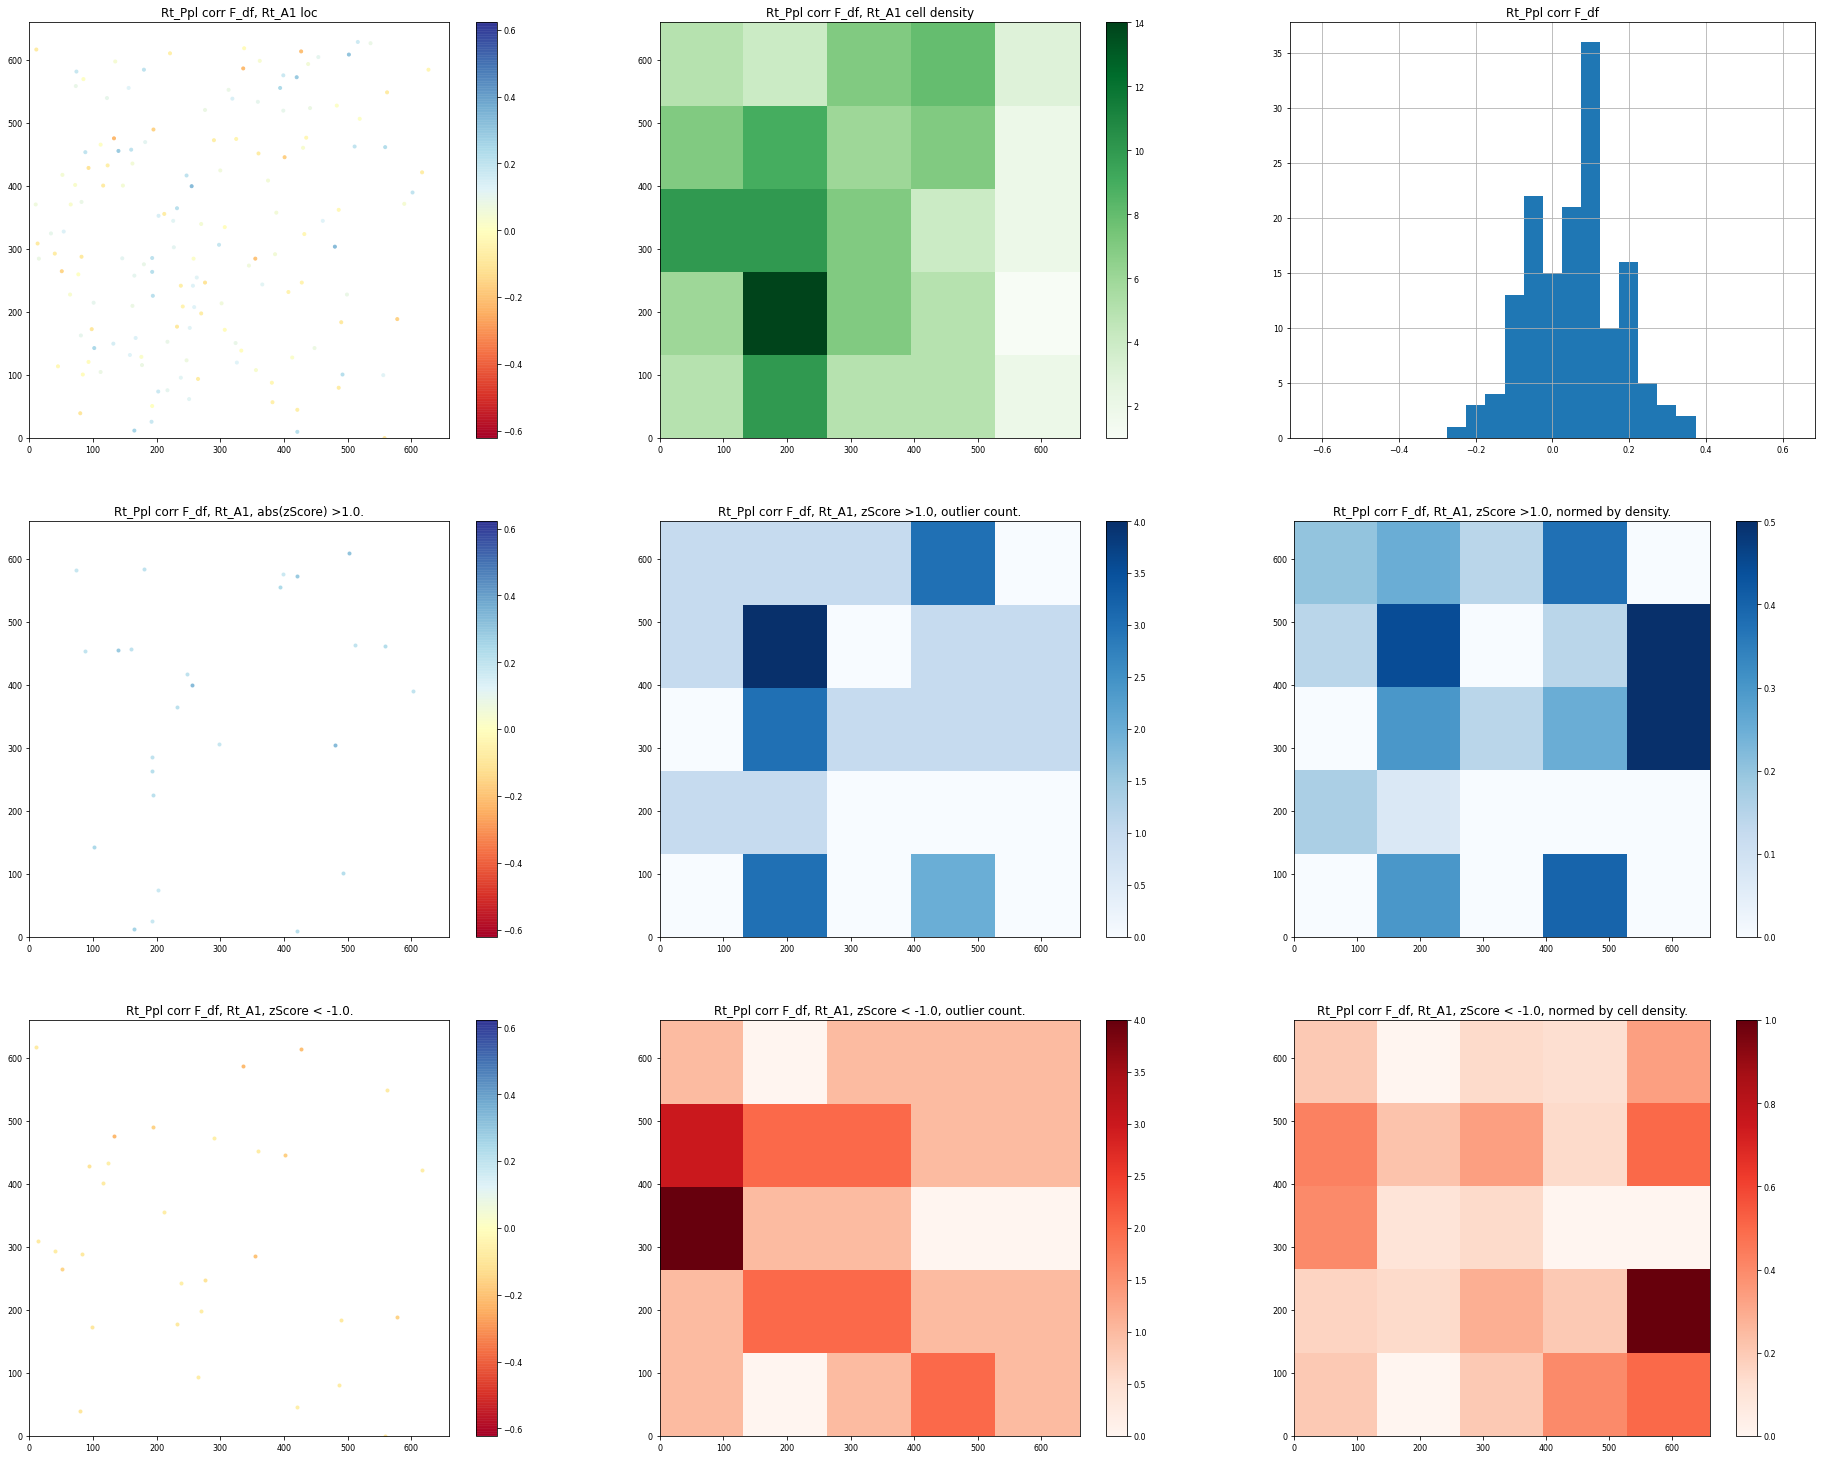

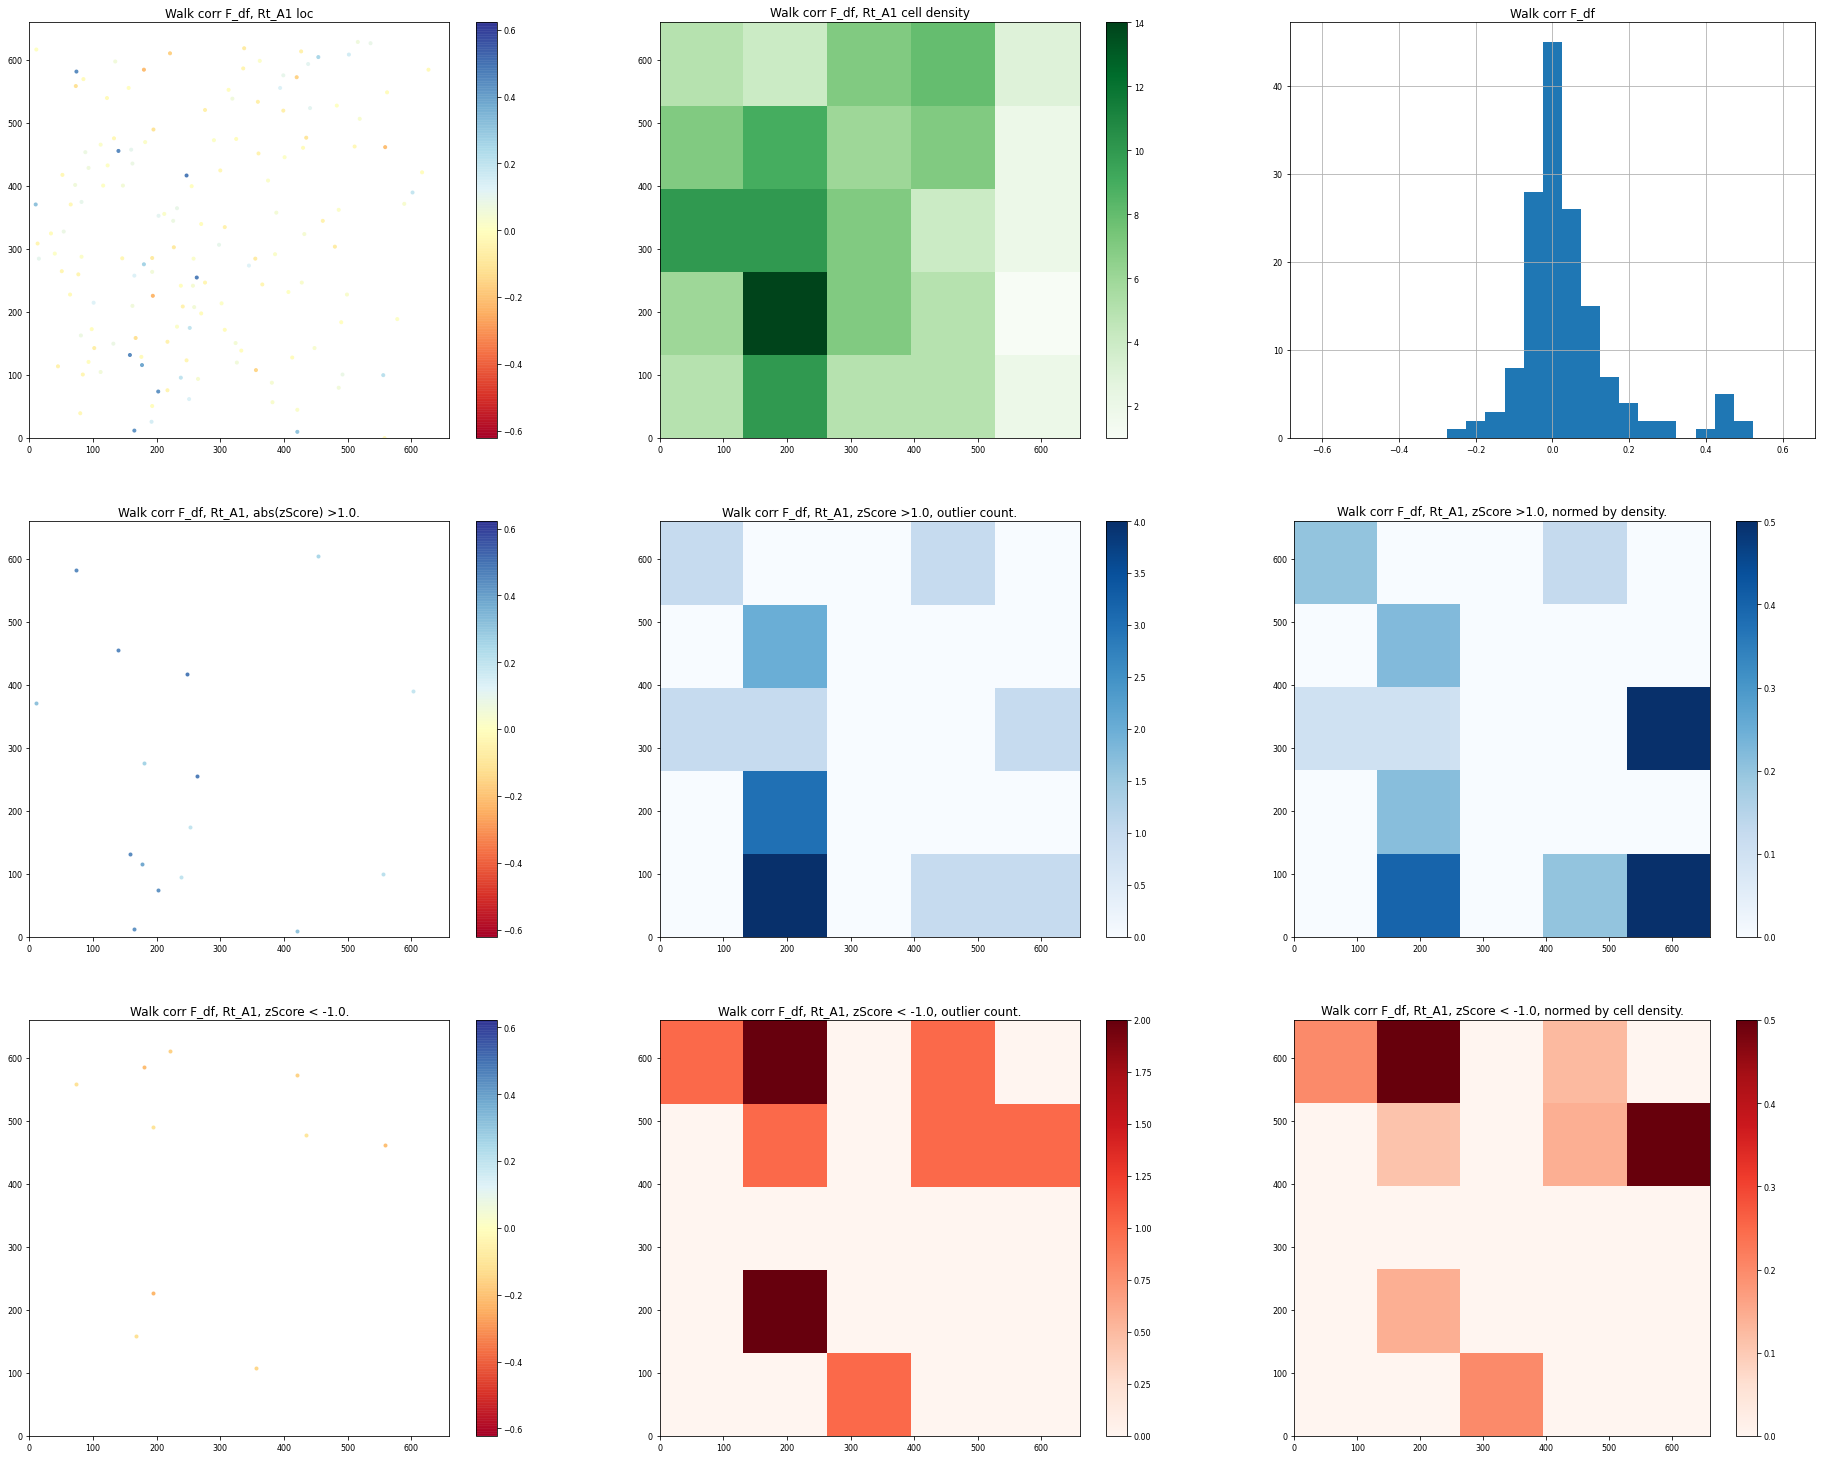

In [165]:
#Make and save figure of 2P correlations with behavior, with indexed cell maps and histograms

from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
from scipy.stats import gaussian_kde

z_cutOff=input("What z-score cutoff would you like to use?")
z_cutOff=float(z_cutOff)
    
x_bins=input("How many x bins do you want?")
y_bins=input("How many y bins do you want")
x_bins=int(x_bins)
y_bins=int(y_bins)
    
for i in range(0,len(behav)):
#for i in range(0,1):

    #make rotated and scaled map of all real cells
    norm=Normalize(vmin=-1.,vmax=1.)

    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0        
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res

    #newschool cell, density, and normed corr plots
    super_min_corr=0
    super_max_corr=0

    for l in range(0,len(behav)):
        if max(bcloc_lft_whisk_sort[behav[l]])>super_max_corr:
            super_max_corr=max(bcloc_lft_whisk_sort[behav[l]])
        if min(bcloc_lft_whisk_sort[behav[l]])<super_max_corr:
            super_min_corr=min(bcloc_lft_whisk_sort[behav[l]])

    if super_max_corr>super_min_corr*(-1):
        corr_abs_range=super_max_corr
    else:
        corr_abs_range=super_min_corr*(-1)

    fig = plt.figure(figsize=(32,26))
    #fig.set_tight_layout(True)
            
    min_corr=min(bcloc_lft_whisk_sort[behav[i]])
    max_corr=max(bcloc_lft_whisk_sort[behav[i]])
        
    curr_behav_zscore=scipy.stats.zscore(bcloc_lft_whisk_sort[behav[i]], axis=0, ddof=0, nan_policy='propagate')

    t=np.arange(ncells)
    t_indexed=bcloc_lft_whisk_sort[behav[i]]
    t=np.array(t_indexed)

    #make 3 x 3 output grid of plots:
        
    #plot 1, all cells with behavioral corr indicated by color bar
    axa = fig.add_subplot(3,3,1)
    plt.scatter(cell_loc_yflip_scale[:,0], cell_loc_yflip_scale[:,1], vmin=-corr_abs_range, vmax=corr_abs_range, c=t, 
                cmap='RdYlBu', alpha=0.95, marker='.')
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+" loc")
    plt.colorbar()
        
    #plot 2, cell density shown as 2d histogram
    axb = fig.add_subplot(3,3,2)
    h_cells=plt.hist2d(cell_loc_yflip_scale[:,0], cell_loc_yflip_scale[:,1], bins=(x_bins, y_bins), range=((0,x_size),
                       (0,y_size)), cmap=plt.cm.Greens)
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+" cell density")
    plt.colorbar()
        
    #plot 3, histogram of behavioral corrs for all cells
    axc = fig.add_subplot(3,3,3)
    behav_corr_frame[behav[i]].hist(bins=25, range=(-corr_abs_range,corr_abs_range))
    plt.title(str(behav[i]).title()+ " corr F_df")
        
    #plot 4, map of all cells with corr z-score exceeding threshold (i.e. positive outliers)
    axd = fig.add_subplot(3,3,4)
        
    for j in range(0,len(cell_loc_real)):
            if curr_behav_zscore[j]>z_cutOff:
                plt.scatter(cell_loc_yflip_scale[j,0], cell_loc_yflip_scale[j,1], vmin=-corr_abs_range, 
                            vmax=corr_abs_range, c=t[j], cmap='RdYlBu', alpha=0.95, marker='.')
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", abs(zScore) >"+str(z_cutOff)+".")
    plt.colorbar()
        
    #plot 5, hist2d density positive outliers
    axe = fig.add_subplot(3,3,5)

    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res
    cell_loc_zCut_pos=cell_loc_yflip_scale
        
    for j in range(0,len(cell_loc_real)):
            if curr_behav_zscore[j]<z_cutOff:
                cell_loc_zCut_pos[j,0]=-1
                cell_loc_zCut_pos[j,1]=-1
            h_pos=plt.hist2d(cell_loc_zCut_pos[:,0], cell_loc_zCut_pos[:,1], bins=(x_bins, y_bins), range=((0,x_size),
                             (0,y_size)), cmap=plt.cm.Blues)
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)            
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", zScore >"+str(z_cutOff)+", outlier count.")
    plt.colorbar()
        
    #plot 6, hist2d density positive outliers normalized to cell count per bin
    axf = fig.add_subplot(3,3,6)
    h_pos_norm=h_pos[0]/h_cells[0]
    
    #function to rotate matrix counterclockwise 90 degrees
    def rotate_matrix( m ):
        return [[m[j][i] for j in range(len(m))] for i in range(len(m[0])-1,-1,-1)]

    h_pos_norm=rotate_matrix(h_pos_norm)

    plt.imshow(h_pos_norm,cmap="Blues",extent=[0,x_size,0,y_size])
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", zScore >"+str(z_cutOff)+", normed by density.")
    plt.colorbar()
        
    #plot 7, map of all cells with corr z-score less than negative threshold (i.e. negative outliers) 
    axg = fig.add_subplot(3,3,7)  
    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res
    for j in range(0,len(cell_loc_real)):
            if curr_behav_zscore[j]<z_cutOff*(-1):
                plt.scatter(cell_loc_yflip_scale[j,0], cell_loc_yflip_scale[j,1], vmin=-corr_abs_range, 
                            vmax=corr_abs_range, c=t[j], cmap='RdYlBu', alpha=0.95, marker='.')
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", zScore < -"+str(z_cutOff)+".")
    plt.colorbar()
        
    #plot 8, hist2d density negative outliers
    axh = fig.add_subplot(3,3,8)
    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res
    cell_loc_zCut_neg=cell_loc_yflip_scale
    for j in range(0,len(cell_loc_real)):
            if curr_behav_zscore[j]>z_cutOff*(-1):
                cell_loc_zCut_neg[j,0]=-1
                cell_loc_zCut_neg[j,1]=-1
            h_neg=plt.hist2d(cell_loc_zCut_neg[:,0], cell_loc_zCut_neg[:,1], bins=(x_bins, y_bins), range=((0,x_size),
                             (0,y_size)), cmap=plt.cm.Reds)
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", zScore < -"+str(z_cutOff)+", outlier count.")
    plt.colorbar()
        
    #plot 9, hist2d density positive outliers normalized to cell count per bin
    axi = fig.add_subplot(3,3,9)
    h_neg_norm=h_neg[0]/h_cells[0]
    
    h_neg_norm=rotate_matrix(h_neg_norm)
    
    plt.imshow(h_neg_norm,cmap="Reds",extent=[0,x_size,0,y_size])
    plt.title(str(behav[i]).title()+" corr F_df, "+area_name+", zScore < -"+str(z_cutOff)+", normed by cell density.")
    plt.colorbar()
        
        
    plt.savefig(save_path+ '/' + str(behav[i]) + '_corr_cell_map_hist.png', dpi=300, bbox_inches='tight')  

In [117]:
#Sort dataframe of 2P traces by correlation with left whisk

from scipy.stats import percentileofscore
import math as m

i=0
sort_range=np.arange(ncells)
F_df_lft_whisk_perc=np.zeros(ncells)
F_df_lft_whisk_sort=F_df_behav_frame.sort_values(by=['lft_whisk'])

for i in sort_range:
    #print(i)
    #print(F_df_lft_whisk_sort.index)
    F_df_lft_whisk_perc[i]=percentileofscore(F_df_lft_whisk_sort['lft_whisk'],
                                             F_df_lft_whisk_sort.iloc[i,0])

lft_whisk_sorted_traces=F_df_lft_whisk_sort.index
F_df_lft_whisk_sort.set_index=(['cell#',pd.Index(F_df_lft_whisk_perc)])

F_df_lft_whisk_sort

lft_whisk_indices=[np.array(F_df_lft_whisk.index),np.array(F_df_lft_whisk_perc)]
F_df_lft_whisk_sort.set_index=([lft_whisk_indices])

print("Success!")

Success!


Text(0.5, 0, 'Time (s)')

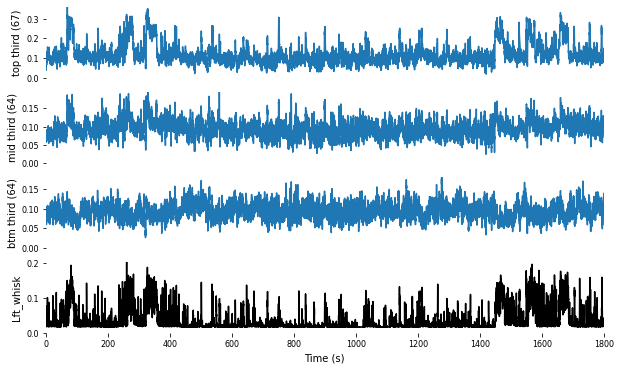

In [118]:
import math as m

#Plot mean traces for top, middle, and bottom third of 2P traces by percentile correlation with left whisk

lft_whisk_btm=np.zeros(F_df_iscell_upsamp.shape[1])
lft_whisk_mid=np.zeros(F_df_iscell_upsamp.shape[1])
lft_whisk_top=np.zeros(F_df_iscell_upsamp.shape[1])

btm_count=0
mid_count=0
top_count=0

for i in F_df_lft_whisk_sort.index:
    #print(i)
    if F_df_lft_whisk_perc[i]<=33:
        lft_whisk_btm=lft_whisk_btm+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        btm_count=btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_lft_whisk_perc[i]>66:
        lft_whisk_top=lft_whisk_top+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        top_count=top_count+1
    else:
        lft_whisk_mid=lft_whisk_mid+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        mid_count=mid_count+1
        
lft_whisk_btm=lft_whisk_btm/btm_count
lft_whisk_mid=lft_whisk_mid/mid_count
lft_whisk_top=lft_whisk_top/top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(lft_whisk_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_top)
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
ax1.set_ylim([0,max(lft_whisk_mid)])
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(lft_whisk_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([0,max(lft_whisk_dwnsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Lft_whisk')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_dwnsamp, color='black')
plt.xlabel('Time (s)')

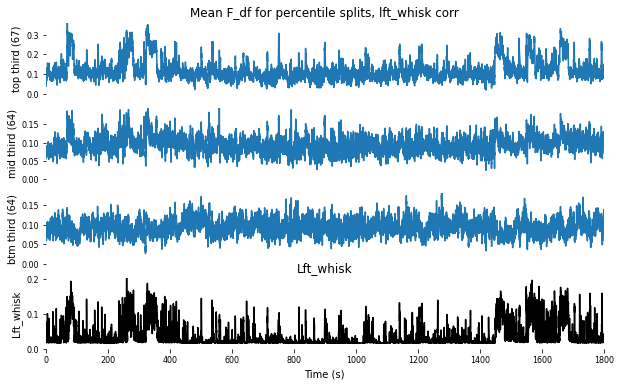

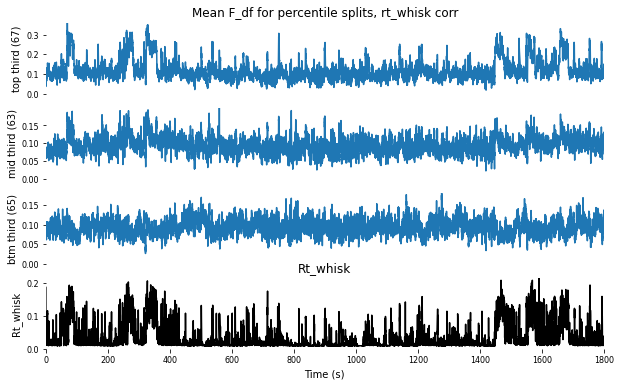

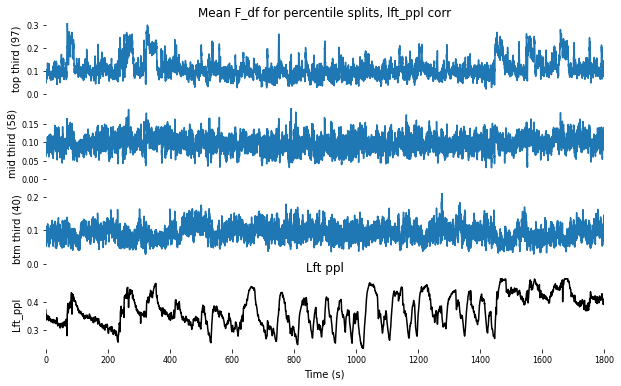

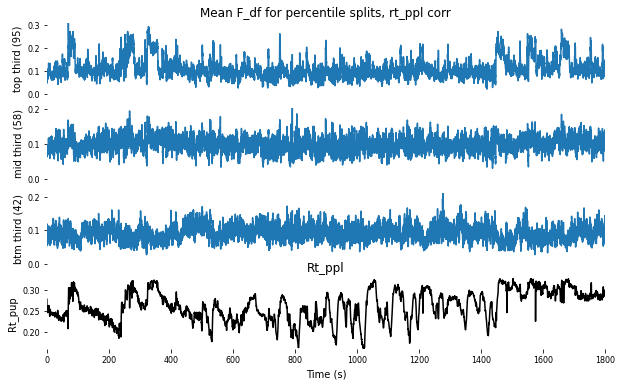

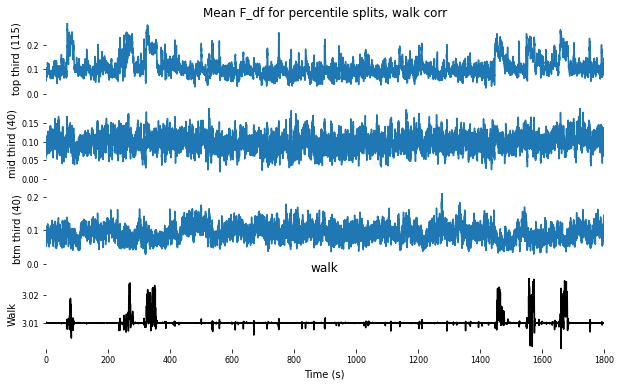

In [119]:
import math as m
#Plot and save mean traces for top, middle, and bottom third of 2P traces correlation with behavioral variables

F_df_lft_whisk_sort=F_df_behav_frame.sort_values(by=['lft_whisk'])
F_df_rt_whisk_sort=F_df_behav_frame.sort_values(by=['rt_whisk'])
F_df_lft_ppl_sort=F_df_behav_frame.sort_values(by=['lft_ppl'])
F_df_rt_ppl_sort=F_df_behav_frame.sort_values(by=['rt_ppl'])
F_df_walk_sort=F_df_behav_frame.sort_values(by=['walk'])

lft_whisk_sorted_traces=F_df_lft_whisk_sort.index
rt_whisk_sorted_traces=F_df_rt_whisk_sort.index
lft_ppl_sorted_traces=F_df_lft_ppl_sort.index
rt_ppl_sorted_traces=F_df_rt_ppl_sort.index
walk_sorted_traces=F_df_walk_sort.index

from scipy.stats import percentileofscore
i=0
sort_range=np.arange(ncells)

F_df_lft_whisk_perc=np.zeros(ncells)
F_df_rt_whisk_perc=np.zeros(ncells)
F_df_lft_ppl_perc=np.zeros(ncells)
F_df_rt_ppl_perc=np.zeros(ncells)
F_df_walk_perc=np.zeros(ncells)

for i in sort_range:
    F_df_lft_whisk_perc[i]=percentileofscore(F_df_lft_whisk_sort['lft_whisk'],F_df_lft_whisk_sort.iloc[i,0])
    F_df_rt_whisk_perc[i]=percentileofscore(F_df_rt_whisk_sort['rt_whisk'],F_df_rt_whisk_sort.iloc[i,0])
    F_df_lft_ppl_perc[i]=percentileofscore(F_df_lft_ppl_sort['lft_ppl'],F_df_lft_ppl_sort.iloc[i,0])
    F_df_rt_ppl_perc[i]=percentileofscore(F_df_rt_ppl_sort['rt_ppl'],F_df_rt_ppl_sort.iloc[i,0])
    F_df_walk_perc[i]=percentileofscore(F_df_walk_sort['walk'],F_df_walk_sort.iloc[i,0])
    
lft_whisk_btm=np.zeros(F_df_iscell_upsamp.shape[1])
lft_whisk_mid=np.zeros(F_df_iscell_upsamp.shape[1])
lft_whisk_top=np.zeros(F_df_iscell_upsamp.shape[1])

rt_whisk_btm=np.zeros(F_df_iscell_upsamp.shape[1])
rt_whisk_mid=np.zeros(F_df_iscell_upsamp.shape[1])
rt_whisk_top=np.zeros(F_df_iscell_upsamp.shape[1])

lft_ppl_btm=np.zeros(F_df_iscell_upsamp.shape[1])
lft_ppl_mid=np.zeros(F_df_iscell_upsamp.shape[1])
lft_ppl_top=np.zeros(F_df_iscell_upsamp.shape[1])

rt_ppl_btm=np.zeros(F_df_iscell_upsamp.shape[1])
rt_ppl_mid=np.zeros(F_df_iscell_upsamp.shape[1])
rt_ppl_top=np.zeros(F_df_iscell_upsamp.shape[1])

walk_btm=np.zeros(F_df_iscell_upsamp.shape[1])
walk_mid=np.zeros(F_df_iscell_upsamp.shape[1])
walk_top=np.zeros(F_df_iscell_upsamp.shape[1])


#Plot left whisker corr mean traces

lft_whisk_btm_count=0
lft_whisk_mid_count=0
lft_whisk_top_count=0

for i in F_df_lft_whisk_sort.index:
    #print(i)
    if F_df_lft_whisk_perc[i]<=33:
        lft_whisk_btm=lft_whisk_btm+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_whisk_btm_count=lft_whisk_btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_lft_whisk_perc[i]>66:
        lft_whisk_top=lft_whisk_top+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_whisk_top_count=lft_whisk_top_count+1
    else:
        lft_whisk_mid=lft_whisk_mid+F_df_lft_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_whisk_mid_count=lft_whisk_mid_count+1
        
lft_whisk_btm=lft_whisk_btm/lft_whisk_btm_count
lft_whisk_mid=lft_whisk_mid/lft_whisk_mid_count
lft_whisk_top=lft_whisk_top/lft_whisk_top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(lft_whisk_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(lft_whisk_top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_top)
plt.title('Mean F_df for percentile splits, lft_whisk corr')
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
ax1.set_ylim([0,max(lft_whisk_mid)])
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(lft_whisk_mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(lft_whisk_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(lft_whisk_btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([0,max(lft_whisk_dwnsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Lft_whisk')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_whisk_dwnsamp, color='black')
plt.xlabel('Time (s)')
plt.title('Lft_whisk')

plt.savefig(save_path+'/lft_whisk_mean_corr_traces.png', dpi=300, bbox_inches='tight')


#Plot right whisker corr mean traces

rt_whisk_btm_count=0
rt_whisk_mid_count=0
rt_whisk_top_count=0

for i in F_df_rt_whisk_sort.index:
    #print(i)
    if F_df_rt_whisk_perc[i]<=33:
        rt_whisk_btm=rt_whisk_btm+F_df_rt_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_whisk_btm_count=rt_whisk_btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_rt_whisk_perc[i]>66:
        rt_whisk_top=rt_whisk_top+F_df_rt_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_whisk_top_count=rt_whisk_top_count+1
    else:
        rt_whisk_mid=rt_whisk_mid+F_df_rt_whisk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_whisk_mid_count=rt_whisk_mid_count+1
        
rt_whisk_btm=rt_whisk_btm/rt_whisk_btm_count
rt_whisk_mid=rt_whisk_mid/rt_whisk_mid_count
rt_whisk_top=rt_whisk_top/rt_whisk_top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(rt_whisk_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(rt_whisk_top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_whisk_top)
plt.title('Mean F_df for percentile splits, rt_whisk corr')
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
ax1.set_ylim([0,max(rt_whisk_mid)])
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(rt_whisk_mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_whisk_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(rt_whisk_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(rt_whisk_btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_whisk_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([0,max(rt_whisk_dwnsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Rt_whisk')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_whisk_dwnsamp, color='black')
plt.xlabel('Time (s)')
plt.title('Rt_whisk')

plt.savefig(save_path+'/rt_whisk_mean_corr_traces.png', dpi=300, bbox_inches='tight')


#Plot left ppl corr mean traces

lft_ppl_btm_count=0
lft_ppl_mid_count=0
lft_ppl_top_count=0

for i in F_df_lft_ppl_sort.index:
    #print(i)
    if F_df_lft_ppl_perc[i]<=33:
        lft_ppl_btm=lft_ppl_btm+F_df_lft_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_ppl_btm_count=lft_ppl_btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_lft_ppl_perc[i]>66:
        lft_ppl_top=lft_ppl_top+F_df_lft_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_ppl_top_count=lft_ppl_top_count+1
    else:
        lft_ppl_mid=lft_ppl_mid+F_df_lft_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        lft_ppl_mid_count=lft_ppl_mid_count+1
        
lft_ppl_btm=lft_ppl_btm/lft_ppl_btm_count
lft_ppl_mid=lft_ppl_mid/lft_ppl_mid_count
lft_ppl_top=lft_ppl_top/lft_ppl_top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(lft_ppl_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(lft_ppl_top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_ppl_top)
plt.title('Mean F_df for percentile splits, lft_ppl corr')
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
try:
    ax1.set_ylim([0,max(lft_ppl_mid)])
except ValueError:
    print("Lft_ppl_mid divide by zero")
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(lft_ppl_mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_ppl_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(lft_ppl_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(lft_ppl_btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_ppl_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([min(lft_ppl_upsamp),max(lft_ppl_upsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Lft_ppl')
plt.tick_params(labelsize=8)
plt.plot(x_values,lft_ppl_upsamp, color='black')
plt.xlabel('Time (s)')
plt.title('Lft ppl')

plt.savefig(save_path+'/lft_ppl_mean_corr_traces.png', dpi=300, bbox_inches='tight')


#Plot rt ppl corr mean traces

rt_ppl_btm_count=0
rt_ppl_mid_count=0
rt_ppl_top_count=0

for i in F_df_rt_ppl_sort.index:
    #print(i)
    if F_df_rt_ppl_perc[i]<=33:
        rt_ppl_btm=rt_ppl_btm+F_df_rt_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_ppl_btm_count=rt_ppl_btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_rt_ppl_perc[i]>66:
        rt_ppl_top=rt_ppl_top+F_df_rt_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_ppl_top_count=rt_ppl_top_count+1
    else:
        rt_ppl_mid=rt_ppl_mid+F_df_rt_ppl_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        rt_ppl_mid_count=rt_ppl_mid_count+1
        
rt_ppl_btm=rt_ppl_btm/rt_ppl_btm_count
rt_ppl_mid=rt_ppl_mid/rt_ppl_mid_count
rt_ppl_top=rt_ppl_top/rt_ppl_top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(rt_ppl_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(rt_ppl_top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_ppl_top)
plt.title('Mean F_df for percentile splits, rt_ppl corr')
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
ax1.set_ylim([0,max(rt_ppl_mid)])
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(rt_ppl_mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_ppl_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(rt_ppl_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(rt_ppl_btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_ppl_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([min(rt_ppl_upsamp),max(rt_ppl_upsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Rt_pup')
plt.tick_params(labelsize=8)
plt.plot(x_values,rt_ppl_upsamp, color='black')
plt.xlabel('Time (s)')
plt.title('Rt_ppl')

plt.savefig(save_path+'/rt_ppl_mean_corr_traces.png', dpi=300, bbox_inches='tight')


#Plot walk corr mean traces

walk_btm_count=0
walk_mid_count=0
walk_top_count=0

for i in F_df_walk_sort.index:
    #print(i)
    if F_df_walk_perc[i]<=33:
        walk_btm=walk_btm+F_df_walk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        walk_btm_count=walk_btm_count+1
        #print(F_df_lft_whisk_sort.iloc[i,5:900005])
    elif F_df_walk_perc[i]>66:
        walk_top=walk_top+F_df_walk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        walk_top_count=walk_top_count+1
    else:
        walk_mid=walk_mid+F_df_walk_sort.iloc[i,5:F_df_iscell_upsamp.shape[1]+5]
        walk_mid_count=walk_mid_count+1
        
walk_btm=walk_btm/walk_btm_count
walk_mid=walk_mid/walk_mid_count
walk_top=walk_top/walk_top_count

fig = plt.figure(figsize=(10,6))

ax0 = fig.add_subplot(4,1,1)
ax0.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#axj.set_xlim(0,x_val_t)
ax0.set_ylim([0,max(walk_top)])
ax0.set_xlim([0,max(x_values)])
ax0.set_frame_on(False)
ax0.set_ylabel('top third ('+str(walk_top_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,walk_top)
plt.title('Mean F_df for percentile splits, walk corr')
            
ax1 = fig.add_subplot(4,1,2)
ax1.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax1.set_xlim(0,x_val_t)
ax1.set_ylim([0,max(walk_mid)])
ax1.set_xlim([0,max(x_values)])
ax1.set_frame_on(False)
ax1.set_ylabel('mid third ('+str(walk_mid_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,walk_mid)
            
ax2 = fig.add_subplot(4,1,3)
ax2.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax2.set_xlim(0,x_val_t)
ax2.set_ylim([0,max(walk_btm)])
ax2.set_xlim([0,max(x_values)])
ax2.set_frame_on(False)
ax2.set_ylabel('btm third ('+str(walk_btm_count)+')')
plt.tick_params(labelsize=8)
plt.plot(x_values,walk_btm)
            
ax3 = fig.add_subplot(4,1,4)
#ax3.get_xaxis().set_visible(False)
#axj.get_yaxis().set_visible(False)
#ax3.set_xlim(0,x_val_t)
ax3.set_ylim([min(walk_dwnsamp),max(walk_dwnsamp)])
ax3.set_xlim([0,max(x_values)])
ax3.set_frame_on(False)
ax3.set_ylabel('Walk')
plt.tick_params(labelsize=8)
plt.plot(x_values,walk_dwnsamp, color='black')
plt.xlabel('Time (s)')
plt.title('walk')

plt.savefig(save_path+'/walk_mean_corr_traces.png', dpi=300, bbox_inches='tight')

How many cells for each third? 10


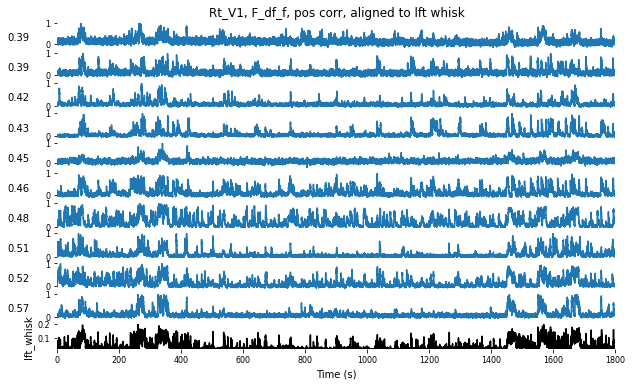

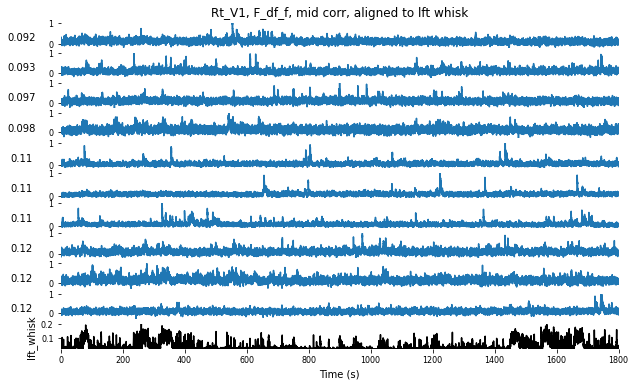

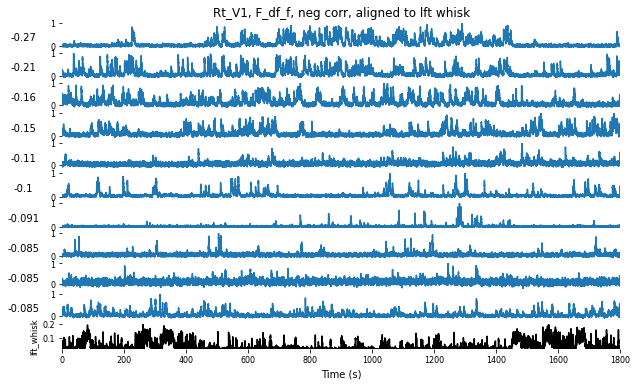

In [120]:
import math as m

def round_sig(x, sig=2):
    return round(x, sig-int(m.floor(m.log10(abs(x))))-1)

#plot top 10 traces versus left whisk

cell_range=input("How many cells for each third?")
cell_range=int(cell_range)
cell_start=int(ncells-cell_range)
cell_stop=int(ncells)

height=(cell_range/10)*6
fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    top_corr=F_df_lft_whisk_sort.iloc[i+cell_start-2,0]
    top_corr=round_sig(top_corr, 2)
    axj.set_ylabel(top_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, pos corr, aligned to lft whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_whisk_dwnsamp),max(lft_whisk_dwnsamp))
axj.set_ylabel('lft_whisk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/top_corr_lft_whisk_align.png', dpi=300, bbox_inches='tight')


#plot mid 10 traces versus left whisk

cell_start=m.floor((ncells/2)-(cell_range/2))
cell_stop=int(cell_start+cell_range)

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    mid_corr=F_df_lft_whisk_sort.iloc[i+cell_start,0]
    mid_corr=round_sig(mid_corr, 2)
    axj.set_ylabel(mid_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, mid corr, aligned to lft whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_whisk_dwnsamp),max(lft_whisk_dwnsamp))
axj.set_ylabel('lft_whisk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/mid_corr_lft_whisk_align.png', dpi=300, bbox_inches='tight')


#plot btm 10 traces versus left whisk

cell_start=0
cell_stop=cell_range

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    btm_corr=F_df_lft_whisk_sort.iloc[i+cell_start,0]
    btm_corr=round_sig(btm_corr, 2)
    axj.set_ylabel(btm_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, neg corr, aligned to lft whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_whisk_dwnsamp),max(lft_whisk_dwnsamp))
axj.set_ylabel('lft_whisk',fontsize='small')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/btm_corr_lft_whisk_align.png', dpi=300, bbox_inches='tight')

How many cells for each third? 10


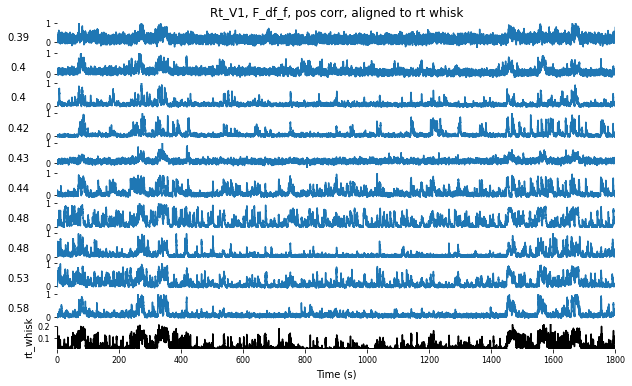

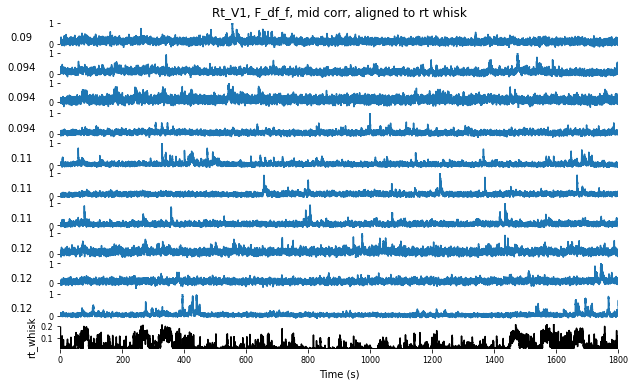

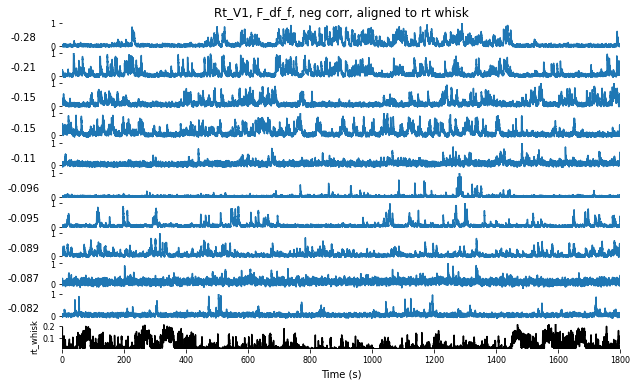

In [121]:
import math as m

def round_sig(x, sig=2):
    return round(x, sig-int(m.floor(m.log10(abs(x))))-1)

#plot top 10 traces versus right whisk

cell_range=input("How many cells for each third?")
cell_range=int(cell_range)
cell_start=int(ncells-cell_range)
cell_stop=int(ncells)

height=(cell_range/10)*6
fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    top_corr=F_df_rt_whisk_sort.iloc[i+cell_start-2,1]
    top_corr=round_sig(top_corr, 2)
    axj.set_ylabel(top_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, pos corr, aligned to rt whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_whisk_dwnsamp),max(rt_whisk_dwnsamp))
axj.set_ylabel('rt_whisk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/top_corr_rt_whisk_align.png', dpi=300, bbox_inches='tight')


#plot mid 10 traces versus right whisk

cell_start=m.floor((ncells/2)-(cell_range/2))
cell_stop=int(cell_start+cell_range)

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    mid_corr=F_df_rt_whisk_sort.iloc[i+cell_start,1]
    mid_corr=round_sig(mid_corr, 2)
    axj.set_ylabel(mid_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, mid corr, aligned to rt whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_whisk_dwnsamp),max(rt_whisk_dwnsamp))
axj.set_ylabel('rt_whisk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/mid_corr_rt_whisk_align.png', dpi=300, bbox_inches='tight')


#plot btm 10 traces versus right whisk

cell_start=0
cell_stop=cell_range

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    btm_corr=F_df_rt_whisk_sort.iloc[i+cell_start,1]
    btm_corr=round_sig(btm_corr, 2)
    axj.set_ylabel(btm_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_whisk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, neg corr, aligned to rt whisk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_whisk_dwnsamp),max(rt_whisk_dwnsamp))
axj.set_ylabel('rt_whisk',fontsize='small')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_whisk_dwnsamp, color='k')

plt.savefig(save_path+'/btm_corr_rt_whisk_align.png', dpi=300, bbox_inches='tight')

How many cells for each third? 10


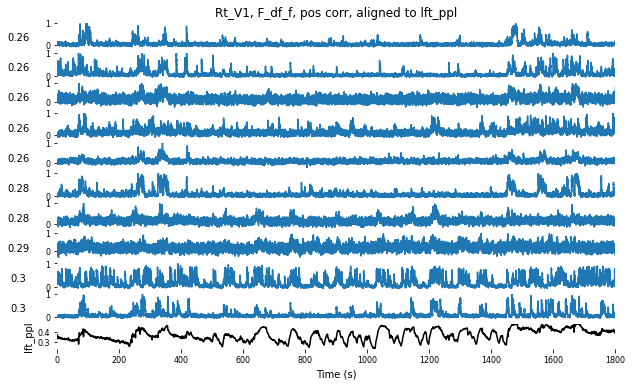

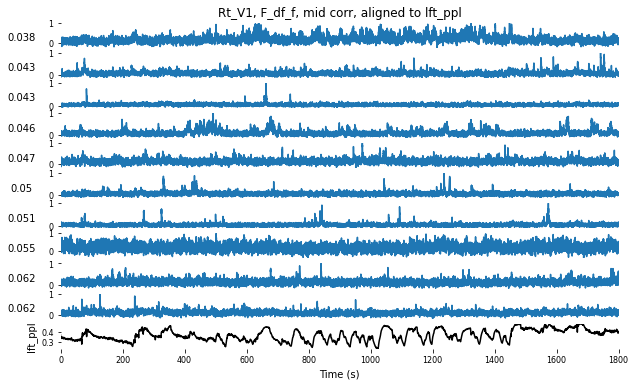

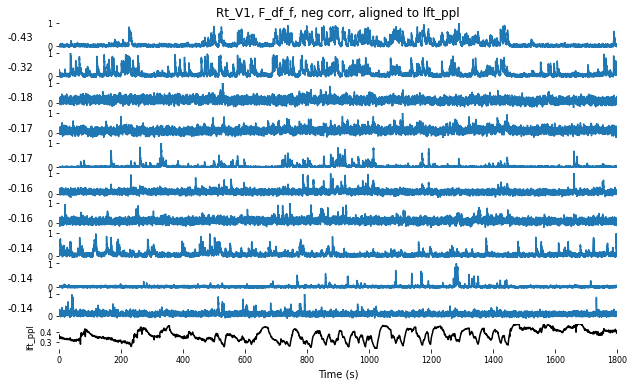

In [122]:
import math as m

def round_sig(x, sig=2):
    return round(x, sig-int(m.floor(m.log10(abs(x))))-1)

#plot top 10 traces versus left ppl

cell_range=input("How many cells for each third?")
cell_range=int(cell_range)
cell_start=int(ncells-cell_range)
cell_stop=int(ncells)

height=(cell_range/10)*6
fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    top_corr=F_df_lft_ppl_sort.iloc[i+cell_start-2,2]
    top_corr=round_sig(top_corr, 2)
    axj.set_ylabel(top_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, pos corr, aligned to lft_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_ppl_upsamp),max(lft_ppl_upsamp))
axj.set_ylabel('lft_ppl')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_ppl_upsamp, color='k')

plt.savefig(save_path+'/top_corr_lft_ppl_align.png', dpi=300, bbox_inches='tight')


#plot mid 10 traces versus lft_ppl

cell_start=m.floor((ncells/2)-(cell_range/2))
cell_stop=int(cell_start+cell_range)

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    mid_corr=F_df_lft_ppl_sort.iloc[i+cell_start,2]
    mid_corr=round_sig(mid_corr, 2)
    axj.set_ylabel(mid_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, mid corr, aligned to lft_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_ppl_upsamp),max(lft_ppl_upsamp))
axj.set_ylabel('lft_ppl')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_ppl_upsamp, color='k')

plt.savefig(save_path+'/mid_corr_lft_ppl_align.png', dpi=300, bbox_inches='tight')


#plot btm 10 traces versus lft_ppl

cell_start=0
cell_stop=cell_range

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    btm_corr=F_df_lft_ppl_sort.iloc[i+cell_start,2]
    btm_corr=round_sig(btm_corr, 2)
    axj.set_ylabel(btm_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_lft_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, neg corr, aligned to lft_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(lft_ppl_upsamp),max(lft_ppl_upsamp))
axj.set_ylabel('lft_ppl',fontsize='small')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, lft_ppl_upsamp, color='k')

plt.savefig(save_path+'/btm_corr_lft_ppl_align.png', dpi=300, bbox_inches='tight')

How many cells for each third? 10


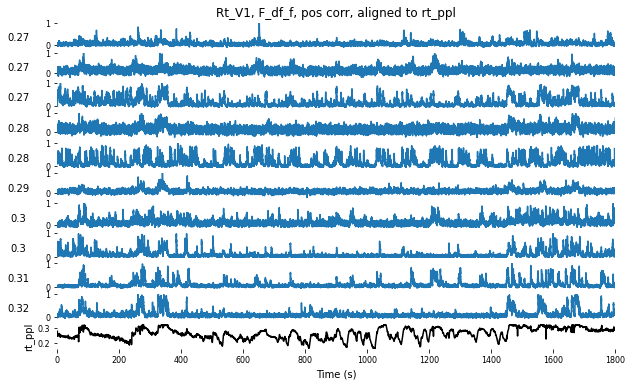

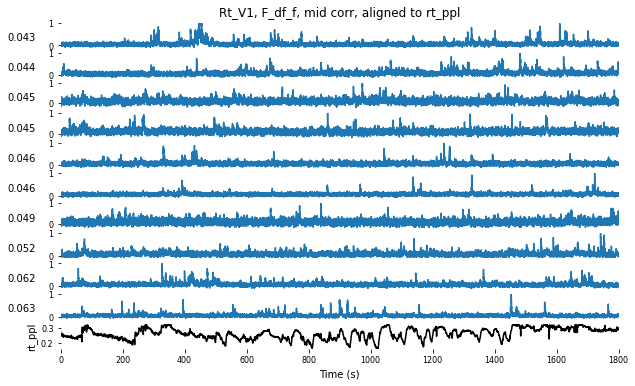

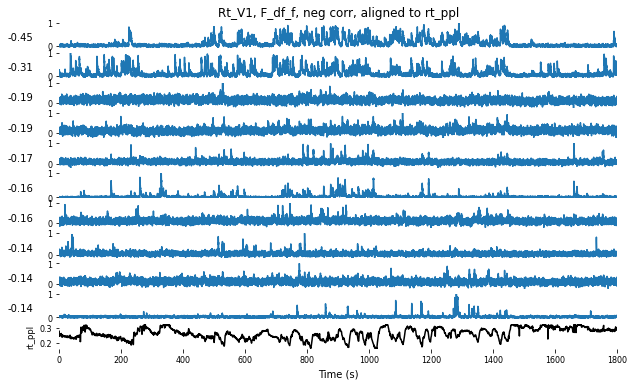

In [123]:
import math as m

def round_sig(x, sig=2):
    return round(x, sig-int(m.floor(m.log10(abs(x))))-1)

#plot top 10 traces versus right ppl

cell_range=input("How many cells for each third?")
cell_range=int(cell_range)
cell_start=int(ncells-cell_range)
cell_stop=int(ncells)

height=(cell_range/10)*6
fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    top_corr=F_df_rt_ppl_sort.iloc[i+cell_start-2,3]
    top_corr=round_sig(top_corr, 2)
    axj.set_ylabel(top_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, pos corr, aligned to rt_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_ppl_upsamp),max(rt_ppl_upsamp))
axj.set_ylabel('rt_ppl')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_ppl_upsamp, color='k')

plt.savefig(save_path+'/top_corr_rt_ppl_align.png', dpi=300, bbox_inches='tight')


#plot mid 10 traces versus rt_ppl

cell_start=m.floor((ncells/2)-(cell_range/2))
cell_stop=int(cell_start+cell_range)

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    mid_corr=F_df_rt_ppl_sort.iloc[i+cell_start,3]
    mid_corr=round_sig(mid_corr, 2)
    axj.set_ylabel(mid_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, mid corr, aligned to rt_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_ppl_upsamp),max(rt_ppl_upsamp))
axj.set_ylabel('rt_ppl')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_ppl_upsamp, color='k')

plt.savefig(save_path+'/mid_corr_rt_ppl_align.png', dpi=300, bbox_inches='tight')


#plot btm 10 traces versus rt_ppl

cell_start=0
cell_stop=cell_range

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    btm_corr=F_df_rt_ppl_sort.iloc[i+cell_start,3]
    btm_corr=round_sig(btm_corr, 2)
    axj.set_ylabel(btm_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_rt_ppl_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, neg corr, aligned to rt_ppl")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(rt_ppl_upsamp),max(rt_ppl_upsamp))
axj.set_ylabel('rt_ppl',fontsize='small')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, rt_ppl_upsamp, color='k')

plt.savefig(save_path+'/btm_corr_rt_ppl_align.png', dpi=300, bbox_inches='tight')

How many cells for each third? 10


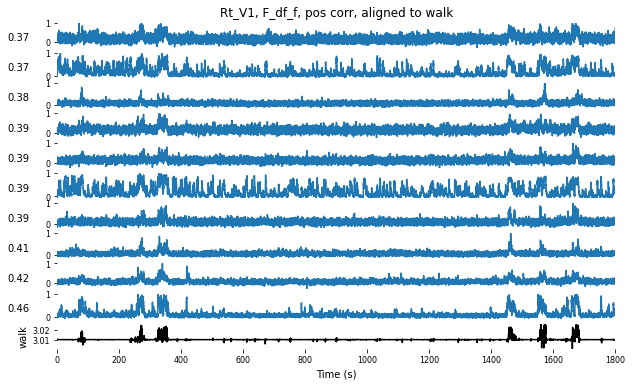

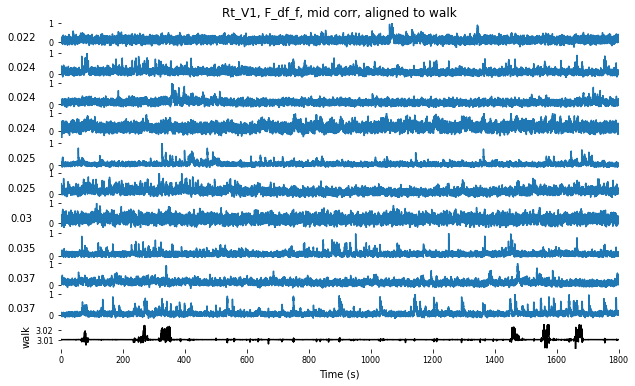

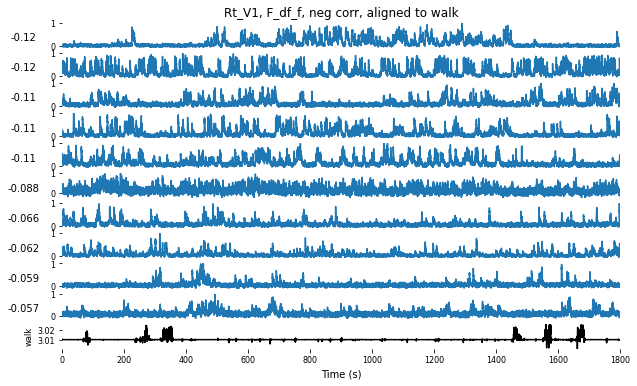

In [124]:
import math as m

def round_sig(x, sig=2):
    return round(x, sig-int(m.floor(m.log10(abs(x))))-1)

#plot top 10 traces versus walk

cell_range=input("How many cells for each third?")
cell_range=int(cell_range)
cell_start=int(ncells-cell_range)
cell_stop=int(ncells)

height=(cell_range/10)*6
fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

x_values=np.linspace(0,dur,num=int(m.floor(dur*rate)))
x_val_t=ops['nframes']/ops['fs']

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    top_corr=F_df_walk_sort.iloc[i+cell_start-2,4]
    top_corr=round_sig(top_corr, 2)
    axj.set_ylabel(top_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, pos corr, aligned to walk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(walk_dwnsamp),max(walk_dwnsamp))
axj.set_ylabel('walk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, walk_dwnsamp, color='k')

plt.savefig(save_path+'/top_corr_walk_align.png', dpi=300, bbox_inches='tight')


#plot mid 10 traces versus walk

cell_start=m.floor((ncells/2)-(cell_range/2))
cell_stop=int(cell_start+cell_range)

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    mid_corr=F_df_walk_sort.iloc[i+cell_start,4]
    mid_corr=round_sig(mid_corr, 2)
    axj.set_ylabel(mid_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, mid corr, aligned to walk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(walk_dwnsamp),max(walk_dwnsamp))
axj.set_ylabel('walk')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, walk_dwnsamp, color='k')

plt.savefig(save_path+'/mid_corr_walk_align.png', dpi=300, bbox_inches='tight')


#plot btm 10 traces versus walk

cell_start=0
cell_stop=cell_range

fig = plt.figure(figsize=(10,height))

y_min=0
y_max=0

i=0
j=1

for i in range(cell_range):
    
    y_max=max(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    y_min=min(F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])    
    
    axj = fig.add_subplot(cell_range+1,1,j)
    axj.get_xaxis().set_visible(False)
    #axj.get_yaxis().set_visible(False)
    axj.set_xlim(0,x_val_t)
    axj.set_ylim([y_min,y_max])
    axj.set_frame_on(False)
    btm_corr=F_df_walk_sort.iloc[i+cell_start,4]
    btm_corr=round_sig(btm_corr, 2)
    axj.set_ylabel(btm_corr, rotation=0)
    axj.yaxis.set_label_coords(-0.07,0.2)
    plt.tick_params(labelsize=8)
    plt.plot(x_values,F_df_walk_sort.iloc[i+cell_start,5:F_df_iscell_upsamp.shape[1]+5])
    if i == 0:
        plt.title(area_name + ", F_df_f, neg corr, aligned to walk")
    j=j+1
    #print(j)

axj = fig.add_subplot(cell_range+1,1,j)
axj.set_frame_on(False)
axj.set_xlim(0,x_val_t)
axj.set_ylim(min(walk_dwnsamp),max(walk_dwnsamp))
axj.set_ylabel('walk',fontsize='small')
axj.set_xlabel('Time (s)')
plt.tick_params(labelsize=8)
plt.plot(x_values, walk_dwnsamp, color='k')

plt.savefig(save_path+'/sort_corr_walk_align.png', dpi=300, bbox_inches='tight')

In [17]:
#only run this once PCA sort is figured out

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': False, 'ytick.left': False,})


Text(0.5, 61.5, '2P frames')

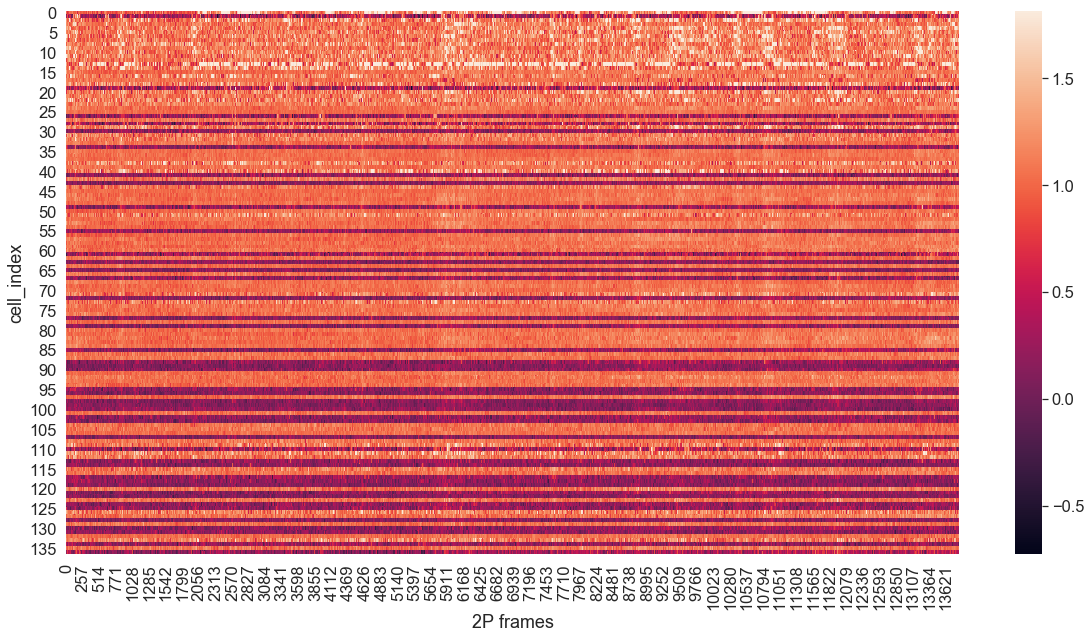

In [18]:
#add code to sort by PCA1 here

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(F_df, vmax=np.percentile(F_df, 99), ax=ax, linecolor=None, linewidth=0)
ax.set_ylabel('cell_index')
ax.set_xlabel('2P frames')

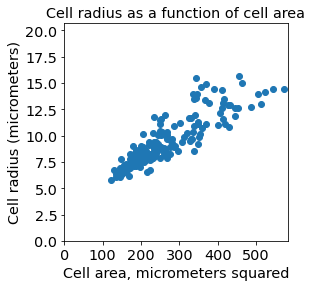

In [125]:
npix_iscell=np.zeros(ncells)
radius_iscell=np.zeros(ncells)

i=0
j=0

for i in range(0,nROIs):
    if int(iscell[i,0])==1:
        npix_iscell[j]=stat[i]['npix']
        radius_iscell[j]=stat[i]['radius']
        j=j+1
        
fig = plt.figure(figsize=(4,4))
plt.scatter(npix_iscell*(res**2),radius_iscell*res)
plt.ylim((0,max(radius_iscell*res)+5))
plt.xlim((0,max(npix_iscell*(res**2))+10))
plt.yticks(fontsize="x-large")
plt.ylabel("Cell radius (micrometers)", fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.xlabel("Cell area, micrometers squared",fontsize="x-large")
plt.title("Cell radius as a function of cell area",fontsize='x-large')

plt.savefig(save_path+'/radius_vs_area.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Cell skew as function of radius')

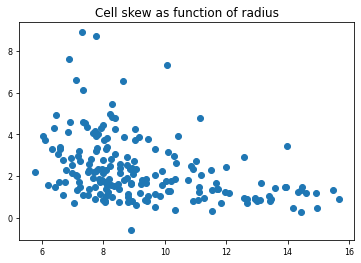

In [126]:
skew_iscell=np.zeros(ncells)
radius_iscell=np.zeros(ncells)
med_iscell=np.zeros((2,ncells))
i=0
j=0

for i in range(0,nROIs):
    if int(iscell[i,0])==1:
        skew_iscell[j]=stat[i]['skew']
        radius_iscell[j]=stat[i]['radius']
        temp=stat[i]['med']
        #print(temp)
        med_iscell[0,j]=temp[0]
        med_iscell[1,j]=temp[1]
        j=j+1
        

plt.scatter(radius_iscell*res,skew_iscell)
plt.title("Cell skew as function of radius")

#plt.savefig(save_path+'/Fsub_skew_vs_radius.png', dpi=300, bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


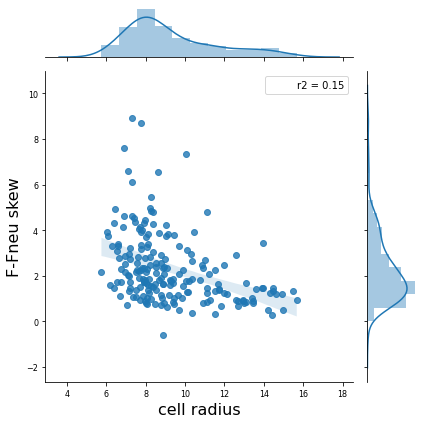

In [127]:
from scipy import stats

skew_iscell=np.zeros(ncells)
radius_iscell=np.zeros(ncells)
med_iscell=np.zeros((2,ncells))
i=0
j=0

for i in range(0,nROIs):
    if int(iscell[i,0])==1:
        skew_iscell[j]=stat[i]['skew']
        radius_iscell[j]=stat[i]['radius']
        temp=stat[i]['med']
        #print(temp)
        med_iscell[0,j]=temp[0]
        med_iscell[1,j]=temp[1]
        j=j+1
        
def r2(x, y):
    return stats.pearsonr(radius_iscell, skew_iscell)[0] ** 2

h=sns.jointplot(radius_iscell*res,skew_iscell,kind="reg",stat_func=r2)
h.set_axis_labels('cell radius', 'F-Fneu skew', fontsize=16)
plt.tight_layout()

plt.savefig(save_path+'/Fsub_skew_vs_radius.png', dpi=300, bbox_inches='tight')

How many DPSS windows do you want? 8
What window length do you want (s)? 200
What standardized half bandwidth do you want to use (old=8)? 8


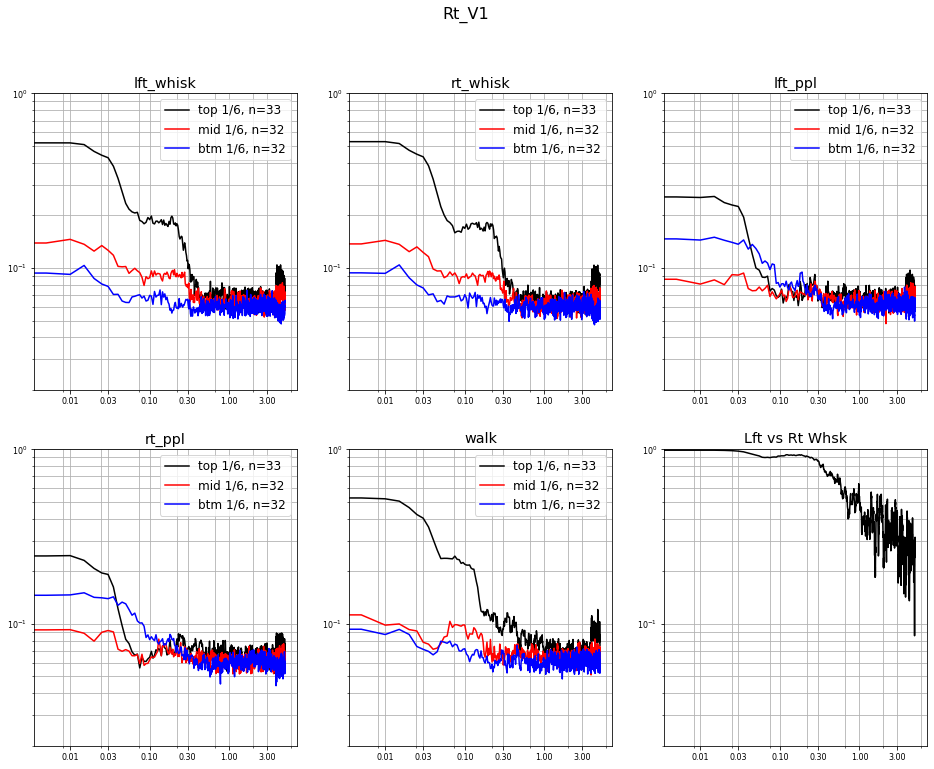

In [129]:
## Run coherence with multitaper windows (dpss), all

from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats

%matplotlib inline

kmax_usr=int(input("How many DPSS windows do you want?"))
win_len=float(input("What window length do you want (s)?"))
NW=int(input("What standardized half bandwidth do you want to use (old=8)?"))

if ncells<100:
    split=1
elif ncells<500:
    split=2
else:
    split=3

split_count=np.zeros((len(behav),3))
for i in range(0,len(behav)):
    split_count[i,0]=eval(behav[z]+'_top_count')
    split_count[i,1]=eval(behav[z]+'_mid_count')
    split_count[i,2]=eval(behav[z]+'_btm_count')

f_pts=(rate*(win_len/2))+1
#f_pts=1001
#kmax_usr=8

#All five behaviors looped, include plotting of locations of cells with high microarousal coherence

#Initialize coherence intermediates
f_ind=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_ind=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sum=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sum=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sub=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sub=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sub_avg=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sub_avg=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_avg=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_avg=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
micro_ratio=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)

min_pwr=np.zeros(len(behav),dtype=float)
max_pwr=np.zeros(len(behav),dtype=float)
end=np.zeros((len(behav),3,1),dtype=float)
micro_range=0
micro_range=int(micro_range)

for z in range(0,len(behav)):
    for y in range(0,3):
        end[z,y,0]=int(m.floor(split_count[z,y]/split))
        if end[z,y,0]>micro_range:
            micro_range=end[z,y,0]
            
micro_count=np.zeros((len(behav),3,1),dtype=float)
micro_IDs=np.zeros((len(behav),3,int(micro_range)),dtype=float)
micro_real_IDs=np.zeros(ncells)
micro_index_IDs=np.zeros((len(behav),ncells))
micro_ratio=np.zeros((len(behav),3,int(micro_range)),dtype=float)
micro_zscore=np.zeros((len(behav),3,int(micro_range)),dtype=float)

for z in range(0,len(behav)):
#for z in range(0,1):
    for y in range(0,3):#split by thirds based on correlation strength percentile
        #run coherence
        #end=int(m.floor(split_count[z,y]/split))
        for i in range(0,int(end[z,y,0])):
            v=signal.windows.dpss(int(rate*win_len), int(NW), Kmax=int(kmax_usr), sym=False, norm=None, return_ratios=False)
            for j in range(0,kmax_usr):
                if y==0:
                    temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(ncells-i-1)+']')
                if y==1:
                    temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(m.floor(ncells/2)-10+i)+']')
                elif y==2:
                    temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(i)+']')
                f, Cxy = signal.coherence(behav_frame[behav[z]], F_df_iscell_norm[temp],fs=rate, 
                                          window=v[j,:], nperseg=int(rate*win_len), axis=0)
                f_ind[z,y,:]=f
                Cxy_ind[z,y,:]=Cxy
                f_sub[z,y,:]=f_sub[z,y,:]+f_ind[z,y,:]
                Cxy_sub[z,y,:]=Cxy_sub[z,y,:]+Cxy_ind[z,y,:]
                
            #find cells with prominent microarousal signatures
            Cxy_ser=pd.Series(Cxy[0:m.floor((rate*(win_len/2)+1)/(rate/2))])
            f_ser=pd.Series(f[0:m.floor((rate*(win_len/2)+1)/(rate/2))])
            Cxy_ser_smth=pd.Series(Cxy[0:m.floor(((rate*(win_len/2)+1)/(rate/2))/10)])
            f_ser_smth=pd.Series(f[0:m.floor(((rate*(win_len/2)+1)/(rate/2))/10)])

            for k in range(0,m.floor(((rate*(win_len/2)+1)/(rate/2))/10)):
                if k<1:
                    Cxy_ser_smth[k]=pd.Series.mean(Cxy_ser[0:4])
                    f_ser_smth[k]=0
                elif k<(m.floor(((rate*(win_len/2)+1)/(rate/2))/10)-1):
                    Cxy_ser_smth[k]=pd.Series.mean(Cxy_ser[((k*10)-5):((i*10)+4)])
                    f_ser_smth[k]=f_ser[k]*rate
                else:
                    Cxy_ser_smth[k]=pd.Series.mean(Cxy_ser[((k*10)-5):(k*10)])
                    f_ser_smth[k]=f_ser[k]*rate
                
            if np.mean(Cxy_ser_smth[4:6])>0.08 and Cxy_ser_smth[2:3].is_monotonic_decreasing:
                micro_count[z,y,0]=micro_count[z,y,0]+1
                micro_IDs[z,y,i]=1
                micro_real_IDs[temp]=1
                micro_index_IDs[z,temp]=1
            micro_ratio[z,y,i]=np.mean(Cxy_ser_smth[3:7])/np.mean(Cxy_ser_smth[1:2])
            #micro_ratio_temp=micro_ratio[z,y,:]
        
        micro_zscore[z,y,:]=scipy.stats.zscore(micro_ratio[z,y,:],axis=0,ddof=0,nan_policy='omit')
        for g in range(0,int(micro_range)):
            if np.isnan(micro_zscore[z,y,g])==True:
                micro_zscore[z,y,g]=0
        
        #Continue
        f_sub_avg[z,y,:]=f_sub[z,y,:]/(j+1)
        Cxy_sub_avg[z,y,:]=Cxy_sub[z,y,:]/(j+1)
    
        f_sum[z,y,:]=f_sum[z,y,:]+f_sub_avg[z,y,:]
        Cxy_sum[z,y,:]=Cxy_sum[z,y,:]+Cxy_sub_avg[z,y,:]

        f_avg[z,y,:]=f_sum[z,y,:]/m.floor(split_count[z,y]/split)
        Cxy_avg[z,y,:]=Cxy_sum[z,y,:]/m.floor(split_count[z,y]/split)          
        
    min_pwr[z]=min(min(Cxy_avg[z,0,:]),min(Cxy_avg[z,1,:]),min(Cxy_avg[z,2,:]))
    max_pwr[z]=max(max(Cxy_avg[z,0,:]),max(Cxy_avg[z,1,:]),max(Cxy_avg[z,2,:]))
    
    #plot outputs, first 5 out of 6 panels
    if z==0:
        fig = plt.figure(figsize=(16,12))
    axis_name='ax'+str(z)
    #print(axis_name)
    axis_name = fig.add_subplot(2,3,z+1)
    line1, = plt.semilogy(f_avg[z,0,:], Cxy_avg[z,0,:], color='black')
    line2, = plt.semilogy(f_avg[z,1,:], Cxy_avg[z,1,:], color='red')
    line3, = plt.semilogy(f_avg[z,2,:], Cxy_avg[z,2,:], color='blue')
    axis_name.set_title(behav[z], fontsize='x-large')
    axis_name.legend((line1, line2, line3), ('top 1/'+str(3*split)+', n='+str(m.floor(split_count[z,0]/split)), 
                                                     'mid 1/'+str(3*split)+', n='+str(m.floor(split_count[z,1]/split)),
                                                     'btm 1/'+str(3*split)+', n='+str(m.floor(split_count[z,2]/split))), fontsize='large')
    axis_name.set_xscale('log',base=3)
    axis_name.set_ylim(0.02,1)
    axis_name.set_xticks([0.01,0.03,0.1,0.3,1,3])
    axis_name.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axis_name.grid(b="True", which="both")

#Left Whisker vs Right Whisker
z=len(behav)
y=0
                             
v=signal.windows.dpss(int(rate*win_len), int(NW), Kmax=int(kmax_usr), sym=False, norm=None, return_ratios=False)

for j in range(kmax_usr):
    f, Cxy = signal.coherence(lft_whisk_dwnsamp[:,0], rt_whisk_dwnsamp[:,0],fs=rate,
                              window=v[j,:], nperseg=rate*200, axis=0)
    f_ind[z,y,:]=f
    Cxy_ind[z,y,:]=Cxy
    f_sub[z,y,:]=f_sub[z,y,:]+f_ind[z,y,:]
    Cxy_sub[z,y,:]=Cxy_sub[z,y,:]+Cxy_ind[z,y,:]
    
f_avg[z,y,:]=f_sub[z,y,:]/(j+1)
Cxy_avg[z,y,:]=Cxy_sub[z,y,:]/(j+1)

whiskers_min_pwr=min(Cxy_avg[z,y,:])
whiskers_max_pwr=max(Cxy_avg[z,y,:])
    
#plot output

ax5 = fig.add_subplot(2,3,6)
line1, = plt.semilogy(f_avg[z,y,:], Cxy_avg[z,y,:], color='black')
ax5.set_title('Lft vs Rt Whsk', fontsize='x-large')
ax5.set_xscale('log',base=3)
ax5.set_ylim(0.02,1)
ax5.set_xticks([0.01,0.03,0.1,0.3,1,3])
ax5.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax5.grid(b="True", which="both")
    
#Final adjustments to overall figure
min_pwr_all=min(min(min_pwr[:]),whiskers_min_pwr)
#print('Minimum overall power = '+ str(min_pwr_all)+'.')
max_pwr_all=max(max(max_pwr[:]),whiskers_max_pwr)

if m.isnan(min_pwr_all):
    min_pwr_all=0.02
if m.isnan(max_pwr_all):
    max_pwr_all=1
    
fig.suptitle(area_name,fontsize='16')
plt.savefig(save_path+'/opto_behav_cohere_all_MT_'+str(win_len)+'_'+str(kmax_usr)+'_'+str(NW)+'.png', 
            dpi=300, bbox_inches='tight')

How many DPSS windows do you want? 8
What window length do you want (s)? 200
What standardized half bandwidth do you want to use (old=8)? 8
Do you want to use thresh and monotonicity (t_mono) or z-score (z_score) to select microarousal traces? z_score
What z_score cutoff do you want to use (positive, one-tailed)? 0.7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


185


How many x bins do you want? 5
How many y bins do you want 5


185
181
178
181


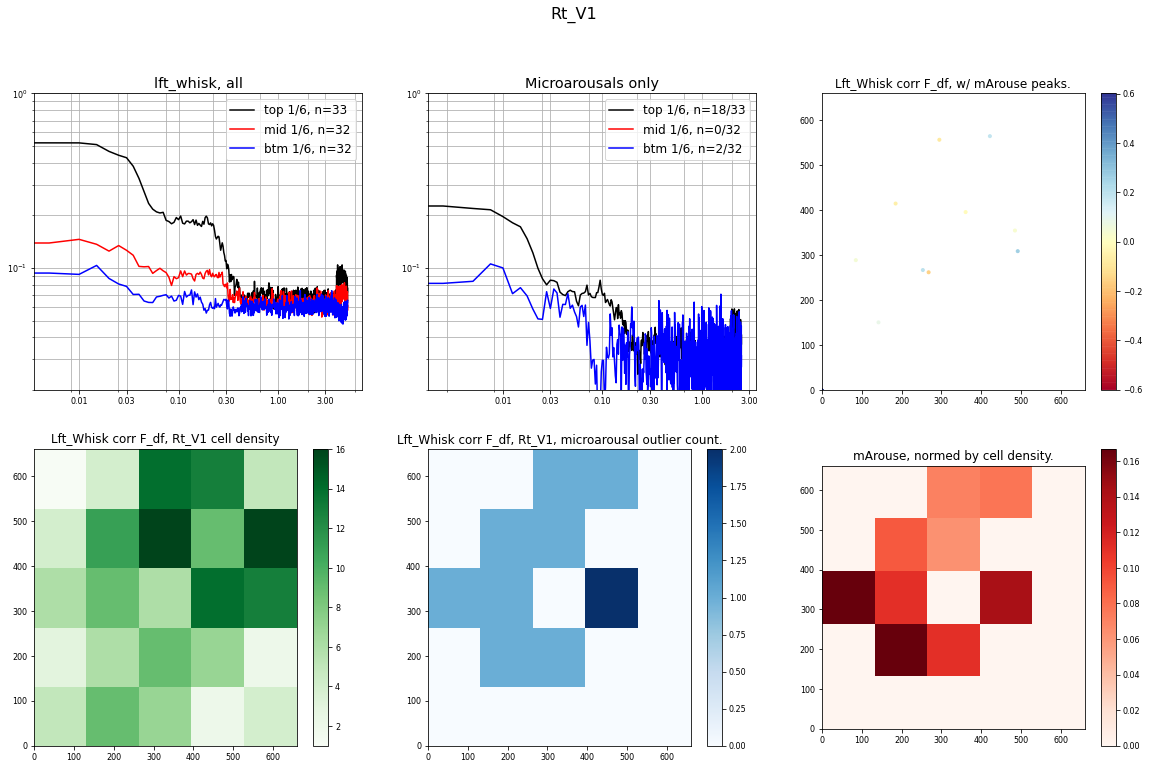

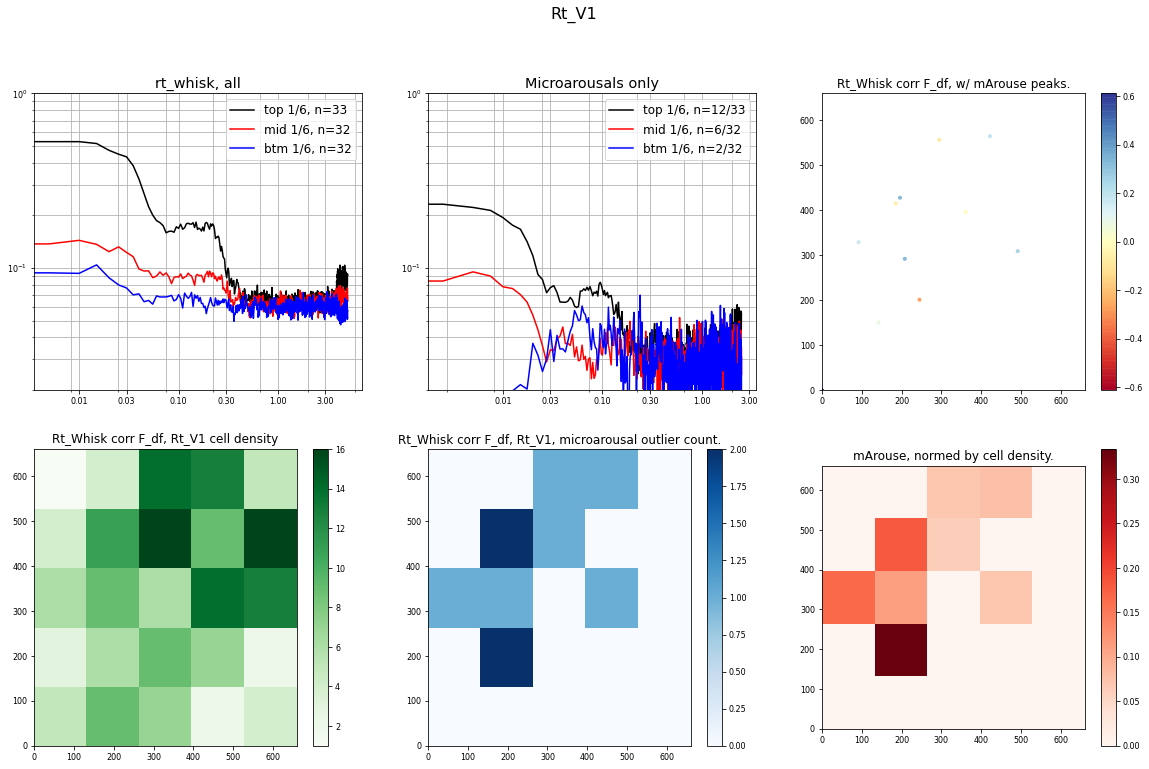

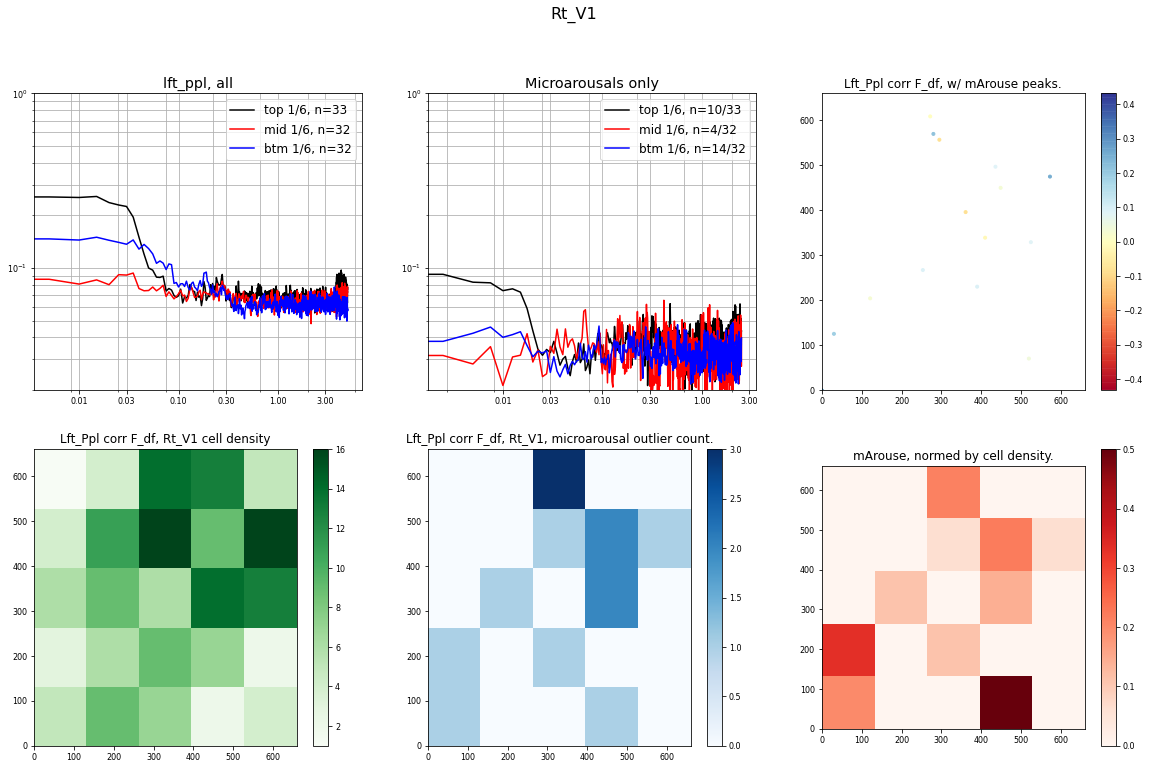

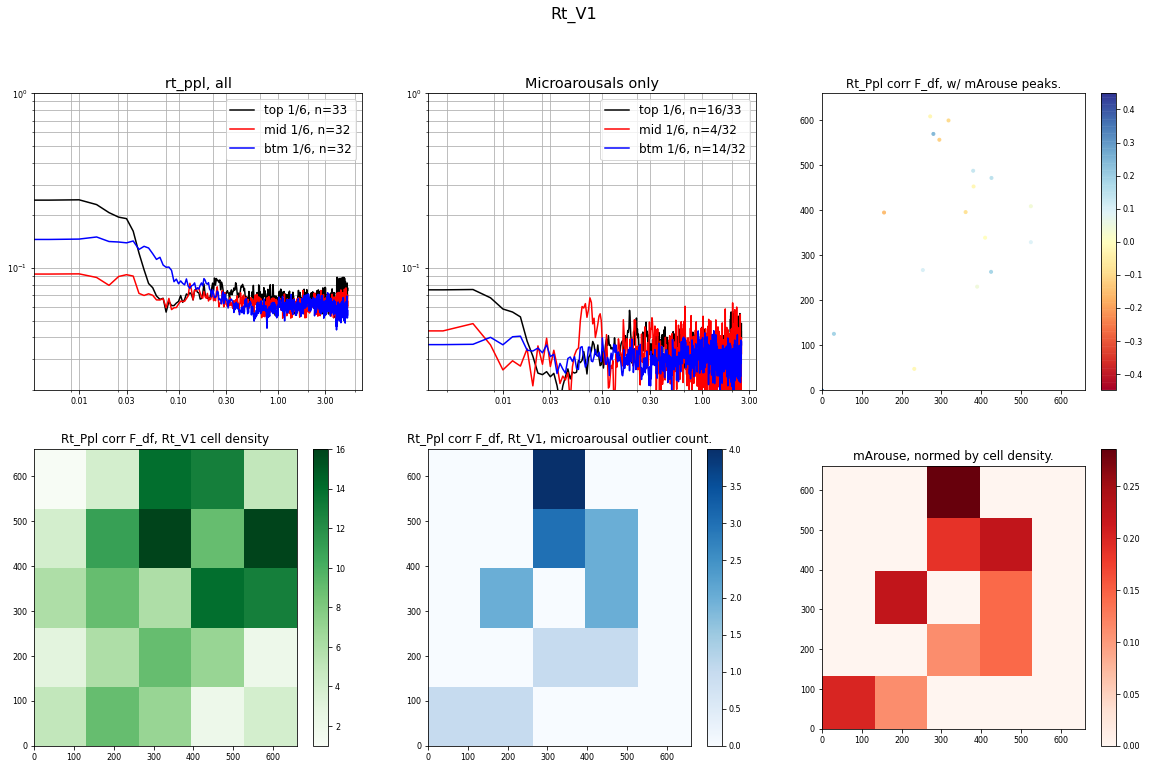

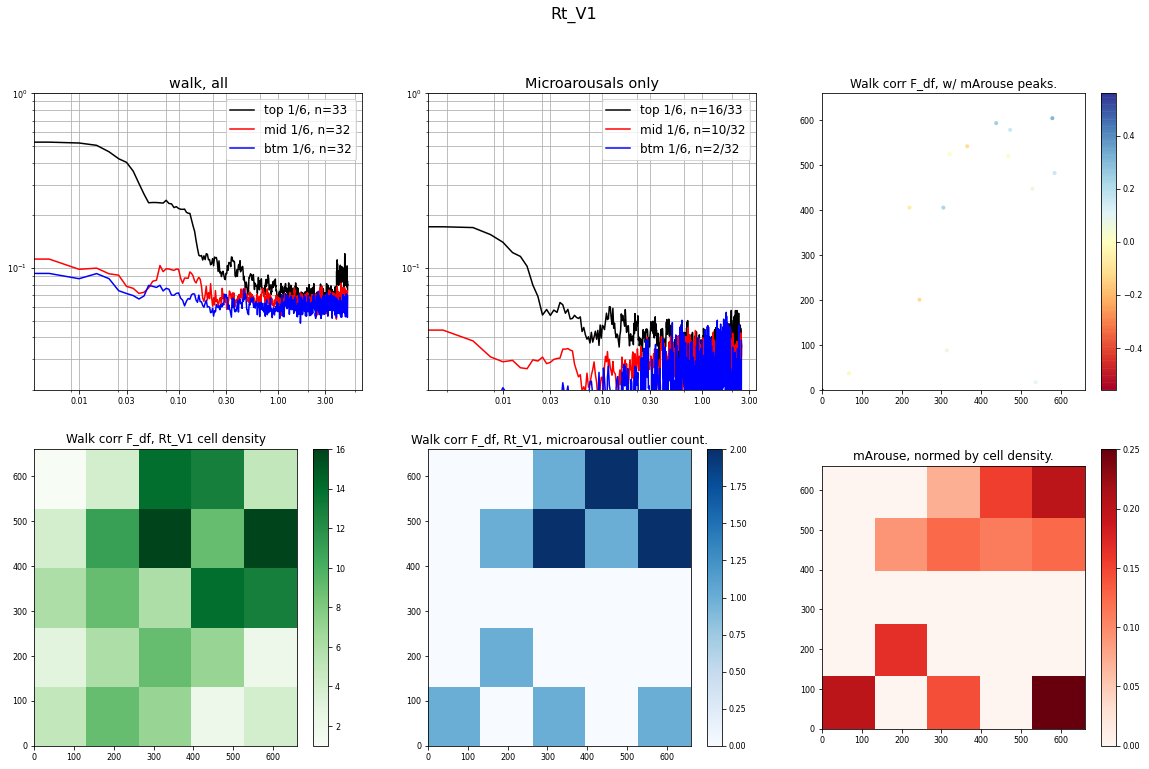

In [130]:
## Run coherence with multitaper windows (dpss), microarousals only

from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats

%matplotlib inline

ncp=0
split_count_m=np.zeros((len(behav),3))
end_m=np.zeros((len(behav),3,1),dtype=float)
micro_zscore_cutoff=0

if ncells<100:
    split_m=1
elif ncells<500:
    split_m=2
else:
    split_m=3

for z in range(0,len(behav)):
    split_count_m[z,0]=eval(behav[z]+'_top_count')
    split_count_m[z,1]=eval(behav[z]+'_mid_count')
    split_count_m[z,2]=eval(behav[z]+'_btm_count')
for z in range(0,len(behav)):
    for y in range(0,3):
        end_m[z,y,0]=int(m.floor(split_count_m[z,y]/split_m))

kmax_usr_m=int(input("How many DPSS windows do you want?"))
win_len_m=float(input("What window length do you want (s)?"))
NW_m=int(input("What standardized half bandwidth do you want to use (old=8)?"))
micro_choose=np.zeros((len(behav),3,int(micro_range)),dtype=float)
micro_criteria=input("Do you want to use thresh and monotonicity (t_mono) or z-score (z_score) to select microarousal traces?")
if micro_criteria=="z_score":
    micro_count=np.zeros((len(behav),3,1),dtype=float)
    micro_IDs=np.zeros((len(behav),3,int(micro_range)),dtype=float)
    micro_real_IDs=np.zeros(ncells)
    micro_index_IDs=np.zeros((len(behav),ncells))
    micro_zscore_cutoff=float(input("What z_score cutoff do you want to use (positive, one-tailed)?"))
    for z in range(0,len(behav)):
        for y in range(0,3):#split by thirds based on correlation strength percentile
            for i in range(0,int(end_m[z,y,0])):
                if micro_zscore[z,y,i]>micro_zscore_cutoff:
                    #print(1)
                    micro_choose[z,y,i]=1
                    micro_count[z,y]=micro_count[z,y]+1
                else:
                    micro_choose[z,y,i]=0
elif micro_criteria=="t_mono":
    micro_choose=micro_IDs
    print("ok")
else:
    print("you loose!") 
    
if ncells<100:
    split_m=1
elif ncells<500:
    split_m=2
else:
    split_m=3

ncp=0
split_count_m=np.zeros((len(behav),3))
end_m=np.zeros((len(behav),3,1),dtype=float)

for z in range(0,len(behav)):
    split_count_m[z,0]=eval(behav[z]+'_top_count')
    split_count_m[z,1]=eval(behav[z]+'_mid_count')
    split_count_m[z,2]=eval(behav[z]+'_btm_count')
for z in range(0,len(behav)):
    for y in range(0,3):
        end_m[z,y,0]=int(m.floor(split_count_m[z,y]/split_m))
    
f_pts_m=(rate*(win_len_m/2))+1
#f_pts=1001
#kmax_usr=8

#All five behaviors looped, include plotting of locations of cells with high microarousal coherence

#Initialize coherence intermediates
f_ind_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_ind_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sum_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sum_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sub_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sub_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_sub_avg_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_sub_avg_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
f_avg_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
Cxy_avg_m=np.zeros((len(behav)+1,3,int(f_pts)),dtype=float)
min_pwr_m=np.zeros(len(behav),dtype=float)
max_pwr_m=np.zeros(len(behav),dtype=float)

for z in range(0,len(behav)):
#for z in range(0,1):
    for y in range(0,3):#split by thirds based on correlation strength percentile
        for i in range(0,int(end_m[z,y,0])):
            if micro_choose[z,y,i]==1:
                v=signal.windows.dpss(int(rate*win_len_m), int(NW_m), Kmax=int(kmax_usr_m), sym=False, norm=None, return_ratios=False)
                for j in range(0,kmax_usr_m):
                    if y==0:
                        temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(ncells-i-1)+']')
                    if y==1:
                        temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(m.floor(ncells/2)-10+i)+']')
                    elif y==2:
                        temp=eval('bcloc_'+behav[z]+'_sort.'+'index'+'['+str(i)+']')
                    f, Cxy = signal.coherence(behav_frame[behav[z]], F_df_iscell_norm[temp],fs=rate, 
                                              window=v[j,:], nperseg=int(rate*win_len_m), axis=0)
                    f_ind_m[z,y,:]=f
                    Cxy_ind_m[z,y,:]=Cxy
                    f_sub_m[z,y,:]=f_sub_m[z,y,:]+f_ind_m[z,y,:]
                    Cxy_sub_m[z,y,:]=Cxy_sub_m[z,y,:]+Cxy_ind_m[z,y,:]

            if micro_criteria=="z_score" and micro_zscore[z,y,i]>micro_zscore_cutoff:
                micro_count[z,y,0]=micro_count[z,y,0]+1
                micro_IDs[z,y,i]=1
                micro_real_IDs[temp]=1
                micro_index_IDs[z,temp]=1
                    
        f_sub_avg_m[z,y,:]=f_sub_m[z,y,:]/(j+1)
        Cxy_sub_avg_m[z,y,:]=Cxy_sub_m[z,y,:]/(j+1)

        f_sum_m[z,y,:]=f_sum_m[z,y,:]+f_sub_avg_m[z,y,:]
        Cxy_sum_m[z,y,:]=Cxy_sum_m[z,y,:]+Cxy_sub_avg_m[z,y,:]

        f_avg_m[z,y,:]=f_sum_m[z,y,:]/micro_count[z,y,0]
        Cxy_avg_m[z,y,:]=Cxy_sum_m[z,y,:]/micro_count[z,y,0]          
        
    min_pwr_m[z]=min(min(Cxy_avg_m[z,0,:]),min(Cxy_avg_m[z,1,:]),min(Cxy_avg_m[z,2,:]))
    max_pwr_m[z]=max(max(Cxy_avg_m[z,0,:]),max(Cxy_avg_m[z,1,:]),max(Cxy_avg_m[z,2,:]))

for z in range(0,len(behav)):
    fig = plt.figure(figsize=(20,12))

    #Plot average traces for all, then just microarousal cells   
    axis_name='ax'+str(0)
    axis_name = fig.add_subplot(2,3,1)
    line1, = plt.semilogy(f_avg[z,0,:], Cxy_avg[z,0,:], color='black')
    line2, = plt.semilogy(f_avg[z,1,:], Cxy_avg[z,1,:], color='red')
    line3, = plt.semilogy(f_avg[z,2,:], Cxy_avg[z,2,:], color='blue')
    axis_name.set_title(behav[z]+', all', fontsize='x-large')
    axis_name.legend((line1, line2, line3), ('top 1/'+str(3*split)+', n='+str(m.floor(split_count[z,0]/split)), 
                                                         'mid 1/'+str(3*split)+', n='+str(m.floor(split_count[z,1]/split)),
                                                         'btm 1/'+str(3*split)+', n='+str(m.floor(split_count[z,2]/split))), fontsize='large')
    axis_name.set_xscale('log',base=3)
    axis_name.set_ylim(0.02,1)
    axis_name.set_xticks([0.01,0.03,0.1,0.3,1,3])
    axis_name.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axis_name.grid(b="True", which="both")    

    axis_name='ax'+str(1)
    axis_name = fig.add_subplot(2,3,2)
    line1, = plt.semilogy(f_avg_m[z,0,:], Cxy_avg_m[z,0,:], color='black')
    line2, = plt.semilogy(f_avg_m[z,1,:], Cxy_avg_m[z,1,:], color='red')
    line3, = plt.semilogy(f_avg_m[z,2,:], Cxy_avg_m[z,2,:], color='blue')
    axis_name.set_title('Microarousals only', fontsize='x-large')
    axis_name.legend((line1, line2, line3), ('top 1/'+str(3*split)+', n='+str(int(micro_count[z,0,0]))+'/'+str(m.floor(split_count[z,0]/split)), 
                                             'mid 1/'+str(3*split)+', n='+str(int(micro_count[z,1,0]))+'/'+str(m.floor(split_count[z,1]/split)),
                                             'btm 1/'+str(3*split)+', n='+str(int(micro_count[z,2,0]))+'/'+str(m.floor(split_count[z,2]/split))),
                                             fontsize='large')                                            
    axis_name.set_xscale('log',base=3)
    axis_name.set_ylim(0.02,1)
    axis_name.set_xticks([0.01,0.03,0.1,0.3,1,3])
    axis_name.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axis_name.grid(b="True", which="both")    

    #Plot locations for microarousal cells
    norm=Normalize(vmin=-1.,vmax=1.)

    super_min_corr=0
    super_max_corr=0

    if max(bcloc_lft_whisk_sort[behav[z]])>super_max_corr:
        super_max_corr=max(bcloc_lft_whisk_sort[behav[z]])
    if min(bcloc_lft_whisk_sort[behav[z]])<super_max_corr:
        super_min_corr=min(bcloc_lft_whisk_sort[behav[z]])

    if super_max_corr>super_min_corr*(-1):
        corr_abs_range=super_max_corr
    else:
        corr_abs_range=super_min_corr*(-1)

    min_corr=min(bcloc_lft_whisk_sort[behav[z]])
    max_corr=max(bcloc_lft_whisk_sort[behav[z]])

    t=np.arange(ncells)
    t_indexed=bcloc_lft_whisk_sort[behav[z]]
    t=np.array(t_indexed)

    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res
    cell_loc_ma_pos=cell_loc_yflip_scale

    axis_name='ax'+str(2)
    axis_name = fig.add_subplot(2,3,3)
    not_cell=0

    for j in range(0,len(cell_loc_real)):
        if micro_index_IDs[z,j]==0:
            cell_loc_ma_pos[j,0]=-1
            cell_loc_ma_pos[j,1]=-1
            not_cell=not_cell+1

    plt.scatter(cell_loc_ma_pos[:,0], cell_loc_ma_pos[:,1], vmin=-corr_abs_range, vmax=corr_abs_range, c=t, 
                cmap='RdYlBu', alpha=0.95, marker='.')

    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[z]).title()+" corr F_df, w/ mArouse peaks.")
    plt.colorbar()
    print(not_cell)

    #Plot overall cell densities
    if z==0:
        x_bins=input("How many x bins do you want?")
        y_bins=input("How many y bins do you want")
        x_bins=int(x_bins)
        y_bins=int(y_bins)

    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res

    axis_name='ax'+str(3)
    axis_name = fig.add_subplot(2,3,4)

    h_cells=plt.hist2d(cell_loc_yflip_scale[:,0], cell_loc_yflip_scale[:,1], bins=(x_bins, y_bins), range=((0,x_size),
                       (0,y_size)), cmap=plt.cm.Greens)
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    plt.title(str(behav[z]).title()+" corr F_df, "+area_name+" cell density")
    plt.colorbar()

    #Plot microarousal cell densities
    axis_name='ax'+str(4)
    axis_name = fig.add_subplot(2,3,5)

    cell_loc_real=np.zeros((ncells,2))
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cell_loc_real
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cell_loc_yflip
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res

    cell_loc_ma_pos=cell_loc_yflip_scale

    not_cell=0

    for j in range(0,len(cell_loc_real)):
        if micro_index_IDs[z,j]==0:
            cell_loc_ma_pos[j,0]=-1
            cell_loc_ma_pos[j,1]=-1
            not_cell=not_cell+1
    h_mArouse=plt.hist2d(cell_loc_ma_pos[:,0], cell_loc_ma_pos[:,1], bins=(x_bins, y_bins), range=((0,x_size),
                     (0,y_size)), cmap=plt.cm.Blues)
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)            
    plt.title(str(behav[z]).title()+" corr F_df, "+area_name+", microarousal outlier count.")
    plt.colorbar()

    #Plot microarousal cell densities, normalized to overall cell densities
    axis_name='ax'+str(5)
    axis_name = fig.add_subplot(2,3,6)

    h_mArouse_norm=h_mArouse[0]/h_cells[0]

    h_mArouse_norm=rotate_matrix(h_mArouse_norm)

    plt.imshow(h_mArouse_norm,cmap="Reds",extent=[0,x_size,0,y_size])
    plt.title("mArouse, normed by cell density.")
    plt.colorbar()

    fig.suptitle(area_name,fontsize='16')
    plt.savefig(save_path+'/opto_behav_cohere_mArouse_'+behav[z]+'_'+str(micro_criteria)+'_'+str(micro_zscore_cutoff)+'_'+str(win_len_m)+'_'+str(kmax_usr_m)+'_'+str(NW_m)+'.png', 
                dpi=300, bbox_inches='tight')

Are there too many pairwise corrs to plot them all? (Yes/No) No


18915
(18915,)
(18915,)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


8.49951001240498
Success!


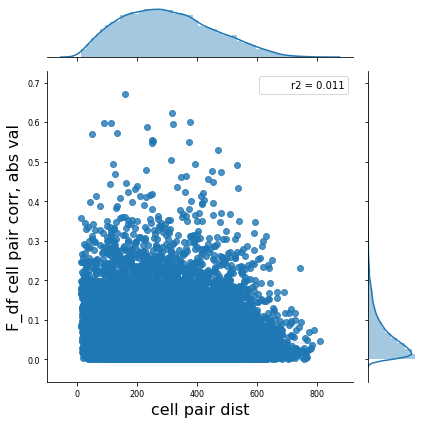

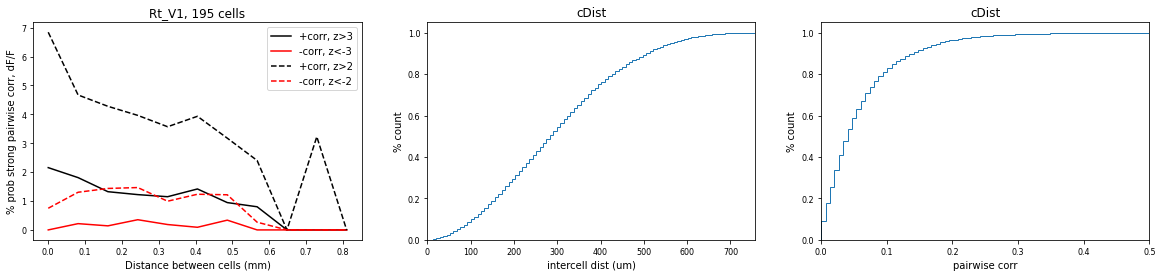

In [131]:
import math as m

no_plot=input("Are there too many pairwise corrs to plot them all? (Yes/No)")

#get all F_df correlations
#F_df_cMat=np.corrcoef(F_df_iscell[:],F_df_iscell[:])
F_df_cMat=np.corrcoef(F_df_iscell_norm[:],F_df_iscell_norm[:])

#get all intercell distances
dist_iscell=np.zeros((ncells,ncells))

for i in range(0,ncells):
    for j in range(0,ncells):
        dist_iscell[i,j]=m.sqrt(((med_iscell[0,i]-med_iscell[0,j])**2)+((med_iscell[1,i]-med_iscell[1,j])**2))*res
#plt.plot(dist_iscell[0,:])

#plot F_df corr as function of intercell distance, run regression, plot histograms
from scipy import stats

dist_size=0
corr_size=0
for i in range(ncells-1):
    for j in range(ncells-1-i):
        dist_size=dist_size+1
        corr_size=corr_size+1


dist_iscell_all=np.zeros(dist_size)
print(dist_size)
print(dist_iscell_all.shape)
corr_iscell_all=np.zeros(corr_size)
print(corr_iscell_all.shape)

c=0
for i in range(ncells):
    for j in range(ncells):
        if i != j & j>i:
            #print(c)
            dist_iscell_all[c]=dist_iscell[i,j]
            corr_iscell_all[c]=F_df_cMat[i,j]
            c=c+1

def r2(x, y):
    return stats.pearsonr(dist_iscell_all, abs(corr_iscell_all))[0] ** 2

if no_plot!="Yes":
    h=sns.jointplot(dist_iscell_all,abs(corr_iscell_all),kind="reg", stat_func=r2)
    h.set_axis_labels('cell pair dist', 'F_df cell pair corr, abs val', fontsize=16)
    plt.tight_layout()

    plt.savefig(save_path+'/Fdf_pairs_corr_dist_joint.png', dpi=300, bbox_inches='tight')
    
corr_iscell_zscore=scipy.stats.zscore(corr_iscell_all, axis=0, ddof=0, nan_policy='propagate')
dist_iscell_zscore=scipy.stats.zscore(dist_iscell_all, axis=0, ddof=0, nan_policy='propagate')
    
j=0
for i in range(0,len(corr_iscell_zscore)):
    if abs(corr_iscell_zscore[i])>2:
        j=j+1
            
corr_sig=np.zeros(j)
dist_sig=np.zeros(j)
    
print(max(corr_iscell_zscore))
j=0
max_dist=max(dist_iscell_all)
    
dist_bins=np.zeros(11)
dist_count=np.zeros(11)
dist_pos=np.zeros(11)
dist_neg=np.zeros(11)
    
corr_pos_count_z3=np.zeros(11)
corr_neg_count_z3=np.zeros(11)
corr_pos_prob_z3=np.zeros(11)
corr_neg_prob_z3=np.zeros(11)
    
corr_pos_count_z2=np.zeros(11)
corr_neg_count_z2=np.zeros(11)
corr_pos_prob_z2=np.zeros(11)
corr_neg_prob_z2=np.zeros(11)
    
for i in range(0,len(dist_bins)):
    dist_bins[i]=j
    j=j+m.ceil(max_dist/10)
j=0
for i in range(0,len(corr_iscell_zscore)):
    for k in range(0,len(dist_bins)):
        if dist_iscell_all[i]>dist_bins[k] and dist_iscell_all[i]<dist_bins[k+1]:
            dist_count[k]+=1
            if corr_iscell_zscore[i]>3:
                corr_pos_count_z3[k]+=1
            if corr_iscell_zscore[i]<-3:
                corr_neg_count_z3[k]+=1
            if corr_iscell_zscore[i]>2:
                corr_pos_count_z2[k]+=1
            if corr_iscell_zscore[i]<-2:
                corr_neg_count_z2[k]+=1
                    
for k in range(0,len(dist_bins)):
    if dist_count[k]>0:
        corr_pos_prob_z3[k]=corr_pos_count_z3[k]/dist_count[k]
        corr_neg_prob_z3[k]=corr_neg_count_z3[k]/dist_count[k]
        corr_pos_prob_z2[k]=corr_pos_count_z2[k]/dist_count[k]
        corr_neg_prob_z2[k]=corr_neg_count_z2[k]/dist_count[k]
    else:
        corr_pos_prob_z3[k]=0
        corr_neg_prob_z3[k]=0
        corr_pos_prob_z2[k]=0
        corr_neg_prob_z2[k]=0
    
fig = plt.figure(figsize=(20,4))
    
ax1 = fig.add_subplot(1,3,1)
line1, = plt.plot(dist_bins/1000,corr_pos_prob_z3*100,label='+corr, z>3', color='black')
line2, = plt.plot(dist_bins/1000,corr_neg_prob_z3*100,label='-corr, z<-3', color='red')
line3, = plt.plot(dist_bins/1000,corr_pos_prob_z2*100,label='+corr, z>2', color='black',linestyle='dashed')
line4, = plt.plot(dist_bins/1000,corr_neg_prob_z2*100,label='-corr, z<-2', color='red',linestyle='dashed')
ax1.legend()
ax1.set_ylabel("% prob strong pairwise corr, dF/F")
ax1.set_xlabel("Distance between cells (mm)")
ax1.set_title(area_name+", "+str(ncells)+" cells")
    
ax2 = fig.add_subplot(1,3,2)
plt.hist(dist_iscell_all,bins=100,density=True,cumulative=True, histtype='step')
ax2.set_title('cDist')
ax2.set_ylabel('% count')
ax2.set_xlabel('intercell dist (um)')
ax2.set_xlim((0,max(dist_iscell_all)-50))
    
ax3 = fig.add_subplot(1,3,3)
plt.hist(abs(corr_iscell_all),bins=100,density=True,cumulative=True,histtype='step')
ax3.set_title('cDist')
ax3.set_ylabel('% count')
ax3.set_xlabel('pairwise corr')
ax3.set_xlim((0,0.5))
    
plt.savefig(save_path+'/pairwise_dff_corrs_intercell_dist.png', dpi=300, bbox_inches='tight')
    
#h=sns.kdeplot(corr_sig, kernel='gau', cumulative=True)
#h=sns.jointplot(dist_sig,corr_sig,kind="reg",stat_func=r2, ylim=(0.2,max(corr_sig)+.02))
#h.set_axis_labels('cell pair dist', 'F_df cell pair corr, abs zscore>3', fontsize=16)
#plt.tight_layout()

#plt.savefig(save_path+'/Fdf_pairs_bigZ_corr_dist_joint.png', dpi=300, bbox_inches='tight')
    
#print(dist_bins)
print("Success!")

What threshold do you want for 1s walking bouts, in cm/s? 0.2
What backwards-looking bout buffer do you want in s? 30
Do you want to use 'left' or 'right' whisker bouts? left
What threshold do you want for 1s whisking bouts, in ME au? 0.08
What backwards-looking bout buffer do you want in s? 30
Do you want to use 'left' or 'right' pupil epochs? left
What threshold do you want for pupil epochs, in area au? 0.05
What backwards-looking epoch buffer do you want in s? 30
What pupil trace offset do you want, in s (pos number means shift left)? 0.5


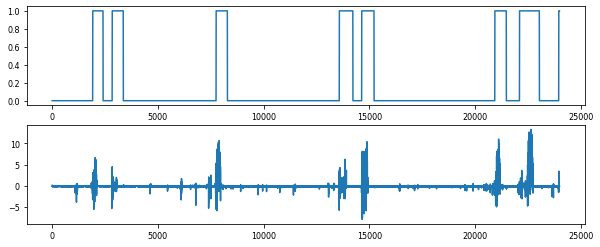

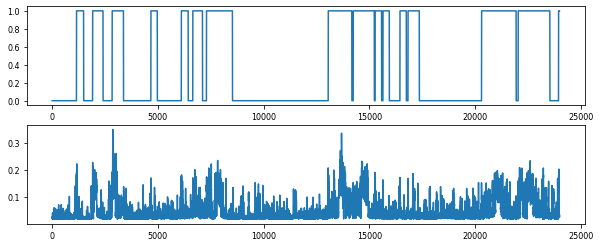

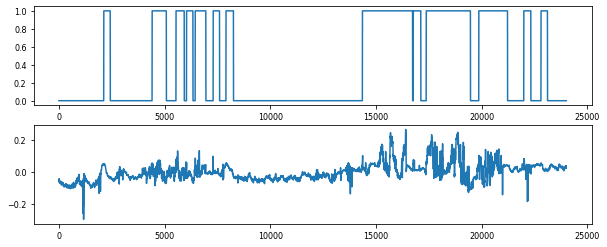

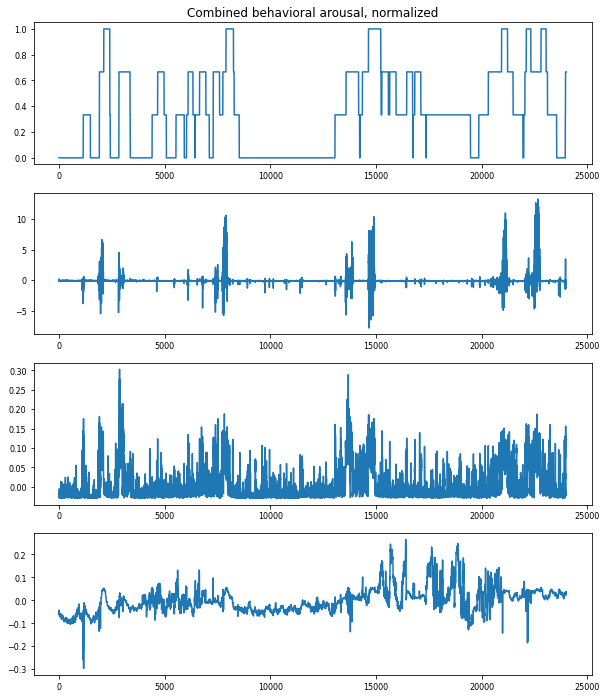

In [177]:
#Region-based seed-mapped pairwise correlation maps

#Compute arousal epochs

#Walk
walk_thresh=float(input("What threshold do you want for 1s walking bouts, in cm/s?"))
bout_buffer_walk=float(input("What backwards-looking bout buffer do you want in s?"))
walk_scaled=(walk_dwnsamp-np.mean(walk_dwnsamp))*1000
walk_running=np.zeros((len(walk_scaled)),dtype=float)
walk_hot=np.zeros((len(walk_scaled)),dtype=float)

for i in range(0,int(len(walk_dwnsamp))):
    if i<(rate/2):
        walk_running[i]=np.mean(walk_scaled[0:rate])
    elif i>len(walk_running-1)-(rate/2):
        walk_running[i]=np.mean(walk_scaled[(len(walk_running)-rate):(len(walk_running)-1)])
    else:
        #print(m.floor(i-rate)/2)
        #print(m.floor(i+rate)/2)
        walk_running[i]=np.mean(walk_scaled[m.floor(i-(rate/2)):m.floor(i+(rate/2))])
    if walk_running[i]>walk_thresh:
        walk_hot[i]=1
    if i>bout_buffer_walk*rate:
        for j in range(0,int(bout_buffer_walk)*rate):
            if walk_running[i-j]>walk_thresh:
                walk_hot[i]=1
    else:
        for k in range(0,int(bout_buffer_walk)*rate):
            if walk_running[i-k]>walk_thresh:
                walk_hot[i]=1
        
fig = plt.figure(figsize=(10,4))
ax0=fig.add_subplot(2,1,1)
plt.plot(walk_hot)
ax1=fig.add_subplot(2,1,2)
plt.plot(walk_scaled)

plt.savefig(save_path+'/walk_epochs.png', dpi=300, bbox_inches='tight')

#Whisk
lat=input("Do you want to use 'left' or 'right' whisker bouts?")
if lat=="left":
    whisk_dwnsamp=lft_whisk_dwnsamp
elif lat=="right":
    whisk_dwnsamp=rt_whisk_dwnsamp
else:
    print("You loose.")
whisk_thresh=float(input("What threshold do you want for 1s whisking bouts, in ME au?"))
bout_buffer_whisk=float(input("What backwards-looking bout buffer do you want in s?"))
whisk_scaled=(whisk_dwnsamp-np.mean(whisk_dwnsamp))
whisk_running=np.zeros((len(whisk_scaled)),dtype=float)
whisk_hot=np.zeros((len(whisk_scaled)),dtype=float)

for i in range(0,int(len(whisk_dwnsamp))):
    if i<(rate/2):
        whisk_running[i]=np.mean(whisk_scaled[0:rate])
    elif i>len(whisk_running-1)-(rate/2):
        whisk_running[i]=np.mean(whisk_scaled[(len(whisk_running)-rate):(len(whisk_running)-1)])
    else:
        #print(m.floor(i-rate)/2)
        #print(m.floor(i+rate)/2)
        whisk_running[i]=np.mean(whisk_scaled[m.floor(i-(rate/2)):m.floor(i+(rate/2))])
    if whisk_running[i]>whisk_thresh:
        whisk_hot[i]=1
    if i>bout_buffer_whisk*rate:
        for j in range(0,int(bout_buffer_whisk)*rate):
            #print(j)
            if whisk_running[i-j]>whisk_thresh:
                whisk_hot[i]=1
    else:
        for k in range(0,int(bout_buffer_whisk)*rate):
            if whisk_running[i-k]>whisk_thresh:
                whisk_hot[i]=1

fig = plt.figure(figsize=(10,4))
ax0=fig.add_subplot(2,1,1)
plt.plot(whisk_hot)
ax1=fig.add_subplot(2,1,2)
plt.plot(whisk_dwnsamp)

plt.savefig(save_path+'/'+str(lat)+'_whisk_epochs.png', dpi=300, bbox_inches='tight')

#Pupil
lat=input("Do you want to use 'left' or 'right' pupil epochs?")
if lat=="left":
    ppl_upsamp=lft_ppl_upsamp
elif lat=="right":
    ppl_upsamp=rt_ppl_upsamp
else:
    print("You loose.")
ppl_thresh=float(input("What threshold do you want for pupil epochs, in area au?"))
epoch_buffer_ppl=float(input("What backwards-looking epoch buffer do you want in s?"))
ppl_offset=float(input("What pupil trace offset do you want, in s (pos number means shift left)?"))

ppl_scaled=(ppl_upsamp-np.mean(ppl_upsamp))
ppl_running=np.zeros((len(ppl_scaled)),dtype=float)
ppl_hot=np.zeros((len(ppl_scaled)),dtype=float)

ppl_shifted=ppl_upsamp
for i in range(0,int(len(ppl_shifted)-(ppl_offset*rate)-1)):
    ppl_shifted[i]=ppl_upsamp[int(i+(ppl_offset*rate))]
ppl_shifted_scaled=(ppl_shifted-np.mean(ppl_shifted))
ppl_shifted_running=np.zeros((len(ppl_shifted_scaled)),dtype=float)
ppl_shifted_hot=np.zeros((len(ppl_shifted_scaled)),dtype=float)

for i in range(0,int(len(ppl_upsamp))):
    if i<(rate/2):
        ppl_running[i]=np.mean(ppl_scaled[0:rate])
        ppl_shifted_running[i]=np.mean(ppl_shifted_scaled[0:rate])
    elif i>len(ppl_running-1)-(rate/2):
        ppl_running[i]=np.mean(ppl_scaled[(len(ppl_running)-rate):(len(ppl_running)-1)])
        ppl_shifted_running[i]=np.mean(ppl_shifted_scaled[(len(ppl_shifted_running)-rate):(len(ppl_shifted_running)-1)])
    else:
        #print(m.floor(i-rate)/2)
        #print(m.floor(i+rate)/2)
        ppl_running[i]=np.mean(ppl_scaled[m.floor(i-(rate/2)):m.floor(i+(rate/2))])
        ppl_shifted_running[i]=np.mean(ppl_shifted_scaled[m.floor(i-(rate/2)):m.floor(i+(rate/2))])
    if ppl_running[i]>ppl_thresh:
        ppl_hot[i]=1
    if ppl_shifted_running[i]>ppl_thresh:
        ppl_shifted_hot[i]=1
    if i>epoch_buffer_ppl*rate:
        for j in range(0,int(epoch_buffer_ppl)*rate):
            #print(j)
            if ppl_running[i-j]>ppl_thresh:
                ppl_hot[i]=1
            if ppl_shifted_running[i-j]>ppl_thresh:
                ppl_shifted_hot[i]=1
    else:
        for k in range(0,int(epoch_buffer_ppl)*rate):
            if ppl_running[i-k]>ppl_thresh:
                ppl_hot[i]=1
            if ppl_shifted_running[i-k]>ppl_thresh:
                ppl_shifted_hot[i]=1

fig = plt.figure(figsize=(10,4))
ax0=fig.add_subplot(2,1,1)
plt.plot(ppl_hot)
ax1=fig.add_subplot(2,1,2)
plt.plot(ppl_scaled)

plt.savefig(save_path+'/'+str(lat)+'_ppl_epochs.png', dpi=300, bbox_inches='tight')

#fig = plt.figure(figsize=(10,4))
#ax0=fig.add_subplot(2,1,1)
#plt.plot(ppl_shifted_hot)
#ax0.set_title('Pupil offset = '+str(ppl_offset)+'s.')
#ax1=fig.add_subplot(2,1,2)
#plt.plot(ppl_shifted_scaled)

#Combined
combined_hot=walk_hot+whisk_hot+ppl_hot
combined_offset_hot=walk_hot+whisk_hot+ppl_shifted_hot
combined_hot_norm=combined_hot/max(combined_hot)
combined_offset_hot_norm=combined_offset_hot/max(combined_offset_hot)

fig = plt.figure(figsize=(10,12))

ax0=fig.add_subplot(4,1,1)
plt.plot(combined_hot_norm)
ax0.set_title('Combined behavioral arousal, normalized')
ax1=fig.add_subplot(4,1,2)
plt.plot(walk_scaled)
ax2=fig.add_subplot(4,1,3)
plt.plot(whisk_scaled)
ax3=fig.add_subplot(4,1,4)
plt.plot(ppl_scaled)

plt.savefig(save_path+'/combined_epochs.png', dpi=300, bbox_inches='tight')

In [178]:
###### Split image into ~10 x 10 grid...calculate seed based FORWARD pairwise corrs
import copy as cp
import math as m
import seaborn as sns
#from matplotlib.patches import Rectangle

grid_count=input("How many grid cells along each side(x=y)?")
grid_count=int(grid_count)
grid_cell_x=m.floor(x_size/grid_count)
grid_cell_y=m.floor(y_size/grid_count)

x_seed=int(input("Pick a seed x grid coord:"))
y_seed=int(input("Pick a seed y grid coord:"))
seed_cell=(x_seed-1)+(grid_count*(y_seed-1))
print(seed_cell)

seed_area=input("Which CCF area is the seed?")

seed_zCut=float(input("Pick a behavioral z-score cutoff, bidir:"))
pairwise_zCut=float(input("Pick a pairwise z-score cutoff, bidir:"))

for z in range(0,len(behav)):
    
    cell_loc_real=np.zeros((ncells,2),dtype=float)
    j=0
    for k in range(cell_loc.shape[0]):
        if iscell[k,0]==1:
            cell_loc_real[j,0]=cell_loc[k,0]
            cell_loc_real[j,1]=cell_loc[k,1]
            j=j+1
    j=0
    cell_loc_yflip=cp.copy(cell_loc_real)
    cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
    cell_loc_yflip_scale=cp.copy(cell_loc_yflip)
    cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
    cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res

    cell_loc_temp_seed=cp.copy(cell_loc_yflip_scale)
    cell_loc_temp_target=cp.copy(cell_loc_yflip_scale)

    grid_code=np.zeros((grid_count,grid_count),dtype=int)
    grid_cell_count=np.zeros((grid_count**2),dtype=float)
    grid_IDs=np.zeros((ncells),dtype=float)

    for i in range(0,ncells):
        #print(m.floor((cell_loc_yflip_scale[i,0]/float(x_size))*grid_count))
        #print(m.floor(cell_loc_yflip_scale[i,1])/float(y_size))
        #grid_IDs[i]=(m.floor(((cell_loc_yflip_scale[i,0]-1)/float(x_size))*grid_count))+(grid_count*(m.floor((cell_loc_yflip_scale[i,1]/float(y_size))*grid_count)))-1
        grid_IDs[i]=(m.floor((cell_loc_yflip_scale[i,0]/float(x_size))*grid_count))+(grid_count*(m.floor(((cell_loc_yflip_scale[i,1]-1)/float(y_size))*grid_count)))
        #m.floor((cell_loc_yflip_scale[i,0]/float(x_size))*grid_count)
        #m.floor((cell_loc_yflip_scale[i,1]/float(y_size))*grid_count)
        grid_cell_count[int(grid_IDs[i])]=grid_cell_count[int(grid_IDs[i])]+1

    cell_cnt=0
    behav_zscore=np.zeros((len(behav),ncells),dtype=float)
    cell_cnt=np.zeros((grid_count**2),dtype=int)
    
    behav_zscore[z,:]=scipy.stats.zscore(behav_corr_cell_loc_frame[behav[z]],axis=0,ddof=0,nan_policy='omit')
    
    for i in range(0,ncells):
        if grid_IDs[i]==seed_cell and abs(behav_zscore[z,i])>seed_zCut:
            cell_cnt[int(grid_IDs[i])]=cell_cnt[int(grid_IDs[i])]+1
            #print('OK')
        else:
            cell_loc_temp_seed[i,0]=-1
            cell_loc_temp_seed[i,1]=-1

        if grid_IDs[i]!=seed_cell:
            cell_cnt[int(grid_IDs[i])]=cell_cnt[int(grid_IDs[i])]+1

    seed_ID=np.zeros((int(cell_cnt[seed_cell])), dtype=int)        

    q=0
    temp_zscore=np.zeros((ncells,ncells))

    for i in range(0,ncells):
        if grid_IDs[i]==seed_cell and abs(behav_zscore[z,i])>seed_zCut:
            seed_ID[q]=i
            q=q+1

        temp_zscore[i,:]=scipy.stats.zscore(F_df_cMat[i,0:ncells], axis=0, ddof=0, nan_policy='propagate')
        temp_zscore[i,i]=0

    target_count=np.zeros((grid_count**2),dtype=float)
    fail_count=0
    target_cmap = ['' for i in range(ncells)]
    target_smap = np.zeros(ncells)

    for i in range(0,ncells):
        for j in range(0,len(seed_ID)):
            if grid_IDs[i]==seed_cell:
                target_smap[i]=20*(2**(1))
            else:
                target_smap[i]=20*(2**(abs(F_df_cMat[seed_ID[j],i])*10))
            if abs(temp_zscore[seed_ID[j],i])<pairwise_zCut and grid_IDs[i]!=seed_cell:
                cell_loc_temp_target[i,0]=-999
                cell_loc_temp_target[i,1]=-999
                target_cmap[i]='blue'
                fail_count=fail_count+1
            elif grid_IDs[i]!=seed_cell and abs(temp_zscore[seed_ID[j],i])>pairwise_zCut:
                cell_loc_temp_target[i,0]=cell_loc_yflip_scale[i,0]
                cell_loc_temp_target[i,1]=cell_loc_yflip_scale[i,1]
                if F_df_cMat[i,seed_ID[j]]>0:
                    target_cmap[i]='blue'
                if F_df_cMat[i,seed_ID[j]]<0:
                    target_cmap[i]='red'
            elif grid_IDs[i]==seed_cell and abs(temp_zscore[seed_ID[j],i])>pairwise_zCut:
                cell_loc_temp_target[i,0]=cell_loc_yflip_scale[i,0]
                cell_loc_temp_target[i,1]=cell_loc_yflip_scale[i,1]
                if F_df_cMat[i,seed_ID[j]]>0:
                    target_cmap[i]='blue'
                if F_df_cMat[i,seed_ID[j]]<0:
                    target_cmap[i]='red'
            else:
                cell_loc_temp_target[i,0]=cell_loc_yflip_scale[i,0]
                cell_loc_temp_target[i,1]=cell_loc_yflip_scale[i,1]
                target_cmap[i]='blue'
            target_cmap[seed_ID[j]]='black'

        if cell_loc_temp_target[i,0]==0 and cell_loc_temp_target[i,1]==0:
            cell_loc_temp_target[i,0]=-1
            cell_loc_temp_target[i,1]=-1

    for i in range(0,ncells):
        if abs(temp_zscore[seed_ID[j],i])>=pairwise_zCut:
            target_count[int(grid_IDs[i])]=target_count[int(grid_IDs[i])]+1

    target_corr=np.zeros((ncells,int(cell_cnt[seed_cell])),dtype=float)

    for i in range(0,ncells):
        for j in range(0,int(cell_cnt[seed_cell])):
            target_corr[i,j]=F_df_cMat[i,seed_ID[j]]

    corr_sums=np.zeros((grid_count**2),dtype=float)
    corr_means=np.zeros((grid_count**2),dtype=float)

    for i in range(0,ncells):
        for j in range(0,len(seed_ID)):
            if i!=seed_ID[j]:
                corr_sums[int(grid_IDs[i])]=corr_sums[int(grid_IDs[i])]+abs(target_corr[i,j])      

    for i in range(0,grid_count**2):
        if i!=seed_cell:
            corr_means[i]=corr_sums[i]/(cell_cnt[i]*len(seed_ID))
        else:
            corr_means[i]=corr_sums[i]/((cell_cnt[seed_cell]-len(seed_ID))*len(seed_ID))
        if np.isnan(corr_means[i]):
            corr_means[i]=0
    corr_hm=np.zeros((grid_count,grid_count),dtype=float)
    corr_hm_norm=np.zeros((grid_count,grid_count),dtype=float)

    for i in range(0,grid_count):
        for j in range(0,grid_count):
            corr_hm[grid_count-i-1,j]=corr_means[j+grid_count*i]
            if (grid_count-i-1)!=seed_cell:
                corr_hm_norm[grid_count-i-1,j]=target_count[j+grid_count*i]/cell_cnt[j+grid_count*i]
                if np.isnan(corr_hm_norm[grid_count-i-1,j]):
                    corr_hm_norm[grid_count-i-1,j]=0
            else:
                corr_hm_norm[grid_count-i-1,j]=target_count[j+grid_count*i]/(cell_cnt[j+grid_count*i]-len(seed_ID))
                if np.isnan(corr_hm_norm[grid_count-i-1,j]):
                    corr_hm_norm[grid_count-i-1,j]=0
    corr_hm_norm=corr_hm_norm/np.amax(corr_hm_norm) 

    fig = plt.figure(figsize=(24,20))

    ax0=fig.add_subplot(2,2,1)
    plt.scatter(cell_loc_yflip_scale[:,0],cell_loc_yflip_scale[:,1],c='black')
    ax0.set_xlim((0,x_size))
    ax0.set_ylim((0,y_size))
    ax0.set_xticks(np.arange(0,x_size,grid_cell_x))
    ax0.set_yticks(np.arange(0,y_size,grid_cell_y))

    x0,x1 = ax0.get_xlim()
    y0,y1 = ax0.get_ylim()
    ax0.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax0.grid(b=True, which='major', color='k', linestyle='--')
    ax0.set_title('All cells, '+behav[z]+', '+str(seed_area)+' is seed.')
    pos1 = ax0.get_position() # get the original position 
    pos2 = [pos1.x0+0.058, pos1.y0,  pos1.width*1, pos1.height*1] 
    ax0.set_position(pos2) # set a new position

    #someX, someY = 2, 3
    #ax0.add_patch(Rectangle((someX - .5, someY - .5), 1, 1, facecolor="none"))

    ax1=fig.add_subplot(2,2,2)
    scatter=plt.scatter(cell_loc_temp_target[:,0],cell_loc_temp_target[:,1],s=target_smap,color=target_cmap)
    ax1.set_xlim((0,x_size))
    ax1.set_ylim((0,y_size))
    ax1.set_xticks(np.arange(0,x_size,grid_cell_x))
    ax1.set_yticks(np.arange(0,y_size,grid_cell_y))

    x0,x1 = ax1.get_xlim()
    y0,y1 = ax1.get_ylim()
    ax1.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax1.grid(b=True, which='major', color='k', linestyle='--')
    ax1.set_title('Seed:'+behav[z]+' z>'+str(seed_zCut)+', Tar:pairW z>'+str(pairwise_zCut)+'_'+str(len(seed_ID))+'_seedCells.')
    pos1 = ax1.get_position() # get the original position 
    pos2 = [pos1.x0+0.055, pos1.y0,  pos1.width*1, pos1.height*1] 
    ax1.set_position(pos2) # set a new position

    # produce a legend with the unique colors from the scatter
    legend1 = ax1.legend(*scatter.legend_elements(),
                        loc="lower left", title="Seed vs Target")
    ax1.add_artist(legend1)

    # produce a legend with a cross section of sizes from the scatter
    #handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6,color='Blue')
    #legend2 = ax1.legend(handles, labels, loc="upper right", title="Corr mag")

    #for corr in [0.1, 0.5, 1.0]:
    #    ax1.scatter([], [], c='k', alpha=0.3, s=m.log(target_smap/20,2)/10,
    #                label=str(corr) + ' corr')
    #legend2 = ax1.legend(scatterpoints=1, frameon=False, labelspacing=1, title='bCorr')


    ax2=fig.add_subplot(2,2,3)
    ax2=sns.heatmap(corr_hm,xticklabels=False,yticklabels=False,cmap='vlag',cbar_kws = dict(use_gridspec=False,location="left"))
    x0,x1 = ax2.get_xlim()
    y0,y1 = ax2.get_ylim()
    ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax2.set_title('Mean gridwise correlations, all vs. target')
    pos1 = ax2.get_position() # get the original position 
    pos2 = [pos1.x0, pos1.y0,  pos1.width*1.07, pos1.height*1.07] 
    ax2.set_position(pos2) # set a new position

    ax3=fig.add_subplot(2,2,4)
    ax3=sns.heatmap(corr_hm_norm,xticklabels=False,yticklabels=False,cmap='hot',cbar_kws = dict(use_gridspec=False,location="left"))
    x0,x1 = ax3.get_xlim()
    y0,y1 = ax3.get_ylim()
    ax3.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax3.set_title('Normalized density of pairwise corr outliers')
    pos1 = ax3.get_position() # get the original position 
    pos2 = [pos1.x0, pos1.y0,  pos1.width*1.07, pos1.height*1.07] 
    ax3.set_position(pos2) # set a new position

    plt.savefig(save_path+'/pairwise_seed_corr_mapping_'+behav[z]+'_'+str(seed_area)+'_'+str(grid_count)+'_gridEdge_'+str(x_seed)
                +'x_'+str(y_seed)+'y_'+str(seed_zCut)+'_seed_zCut_'+str(pairwise_zCut)+'_pairWzCut.png',dpi=300,bbox_inches='tight')

    #perform pairwise corr of these cells with strong behavioral correlations and cells in other grid cells, to create
    #prob density map (i.e. first count, then cell density normed) of high pos or high neg corr (i.e. pairwise z > thresh cutoff)

    #then, redo this analysis for three diff behavioral epochs (i.e. low, med, and high arousal as defined by whisk, walk,
    #pupil, or combinations thereof

How many grid cells along each side(x=y)? 10
Pick a seed x grid coord: 2
Pick a seed y grid coord: 4


31


Which CCF area is the seed? rrrr
Pick a behavioral z-score cutoff, bidir: 1
Pick a pairwise z-score cutoff, bidir: 1.5


NameError: name 'F_df_cMat' is not defined

What hexbin gridsize do you want? 200


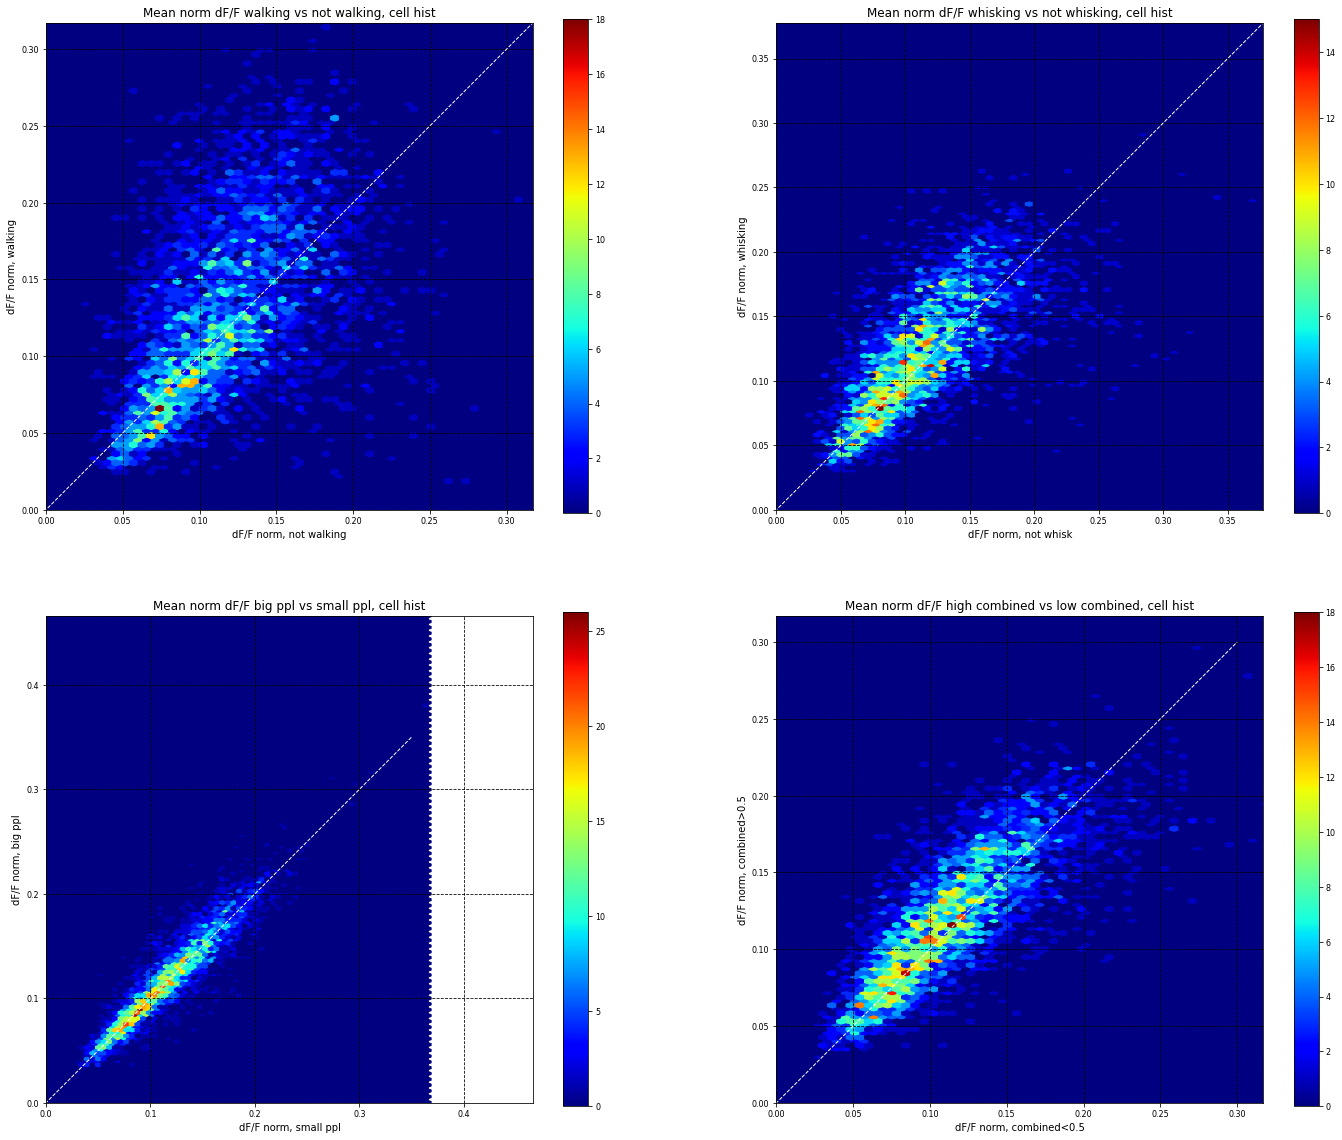

In [179]:
##### plot normed df/F for walk vs. no walk
mean_dF_F_walk_split=np.zeros((ncells,2),dtype=float)
walk_hot_count=0
walk_cold_count=0
hexgrid=0

hexgrid=int(input('What hexbin gridsize do you want?'))

for i in range(0,ncells):
    for j in range(0,len(walk_hot)):
        if walk_hot[j]==0:
            mean_dF_F_walk_split[i,0]=mean_dF_F_walk_split[i,0]+F_df_iscell_norm[i,j]
            if i==0:
                walk_cold_count=walk_cold_count+1
        if walk_hot[j]==1:
            mean_dF_F_walk_split[i,1]=mean_dF_F_walk_split[i,1]+F_df_iscell_norm[i,j]
            if i==0:
                walk_hot_count=walk_hot_count+1
    mean_dF_F_walk_split[i,0]=mean_dF_F_walk_split[i,0]/walk_cold_count
    mean_dF_F_walk_split[i,1]=mean_dF_F_walk_split[i,1]/walk_hot_count
    
df=pd.DataFrame(mean_dF_F_walk_split)

fig = plt.figure(figsize=(24,20))
ax0=fig.add_subplot(2,2,1)

plt.hexbin(df[0],df[1],gridsize=(hexgrid,hexgrid),cmap=plt.cm.jet)
ax0.set_xlim((0,max(df[1])))
cmb_max=max(df[1])
ax0.set_ylim((0,max(df[1])))
x=np.arange(-1,max(df[0]),0.05)
y=x
plt.plot(x, y, '--', color = 'white', linewidth = 1)
x0,x1 = ax0.get_xlim()
y0,y1 = ax0.get_ylim()
ax0.set_aspect(abs(x1-x0)/abs(y1-y0))
ax0.grid(b=True, which='major', color='k', linestyle='--')
plt.colorbar()
ax0.set_title('Mean norm dF/F walking vs not walking, cell hist')
ax0.set_ylabel('dF/F norm, walking')
ax0.set_xlabel('dF/F norm, not walking')

#plot normed df/F for whisk vs. no whisk
mean_dF_F_whisk_split=np.zeros((ncells,2),dtype=float)
whisk_hot_count=0
whisk_cold_count=0

for i in range(0,ncells):
    for j in range(0,len(whisk_hot)):
        if whisk_hot[j]==0:
            mean_dF_F_whisk_split[i,0]=mean_dF_F_whisk_split[i,0]+F_df_iscell_norm[i,j]
            if i==0:
                whisk_cold_count=whisk_cold_count+1
        if whisk_hot[j]==1:
            mean_dF_F_whisk_split[i,1]=mean_dF_F_whisk_split[i,1]+F_df_iscell_norm[i,j]
            if i==0:
                whisk_hot_count=whisk_hot_count+1
    mean_dF_F_whisk_split[i,0]=mean_dF_F_whisk_split[i,0]/whisk_cold_count
    mean_dF_F_whisk_split[i,1]=mean_dF_F_whisk_split[i,1]/whisk_hot_count
    
df=pd.DataFrame(mean_dF_F_whisk_split)

ax1=fig.add_subplot(2,2,2)

plt.hexbin(df[0],df[1],gridsize=(hexgrid,hexgrid),cmap=plt.cm.jet)
ax1.set_xlim((0,max(df[1])))
ax1.set_ylim((0,max(df[1])))
x=np.arange(-1,max(df[0]),0.05)
y=x
plt.plot(x, y, '--', color = 'white', linewidth = 1)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_aspect(abs(x1-x0)/abs(y1-y0))
ax1.grid(b=True, which='major', color='k', linestyle='--')
plt.colorbar()
ax1.set_title('Mean norm dF/F whisking vs not whisking, cell hist')
ax1.set_ylabel('dF/F norm, whisking')
ax1.set_xlabel('dF/F norm, not whisk')

#plot normed df/F for big ppl vs. small ppl
mean_dF_F_ppl_split=np.zeros((ncells,2),dtype=float)
ppl_hot_count=0
ppl_cold_count=0

for i in range(0,ncells):
    for j in range(0,len(ppl_hot)):
        if ppl_hot[j]==0:
            mean_dF_F_ppl_split[i,0]=mean_dF_F_ppl_split[i,0]+F_df_iscell_norm[i,j]
            if i==0:
                ppl_cold_count=ppl_cold_count+1
        if ppl_hot[j]==1:
            mean_dF_F_ppl_split[i,1]=mean_dF_F_ppl_split[i,1]+F_df_iscell_norm[i,j]
            if i==0:
                ppl_hot_count=ppl_hot_count+1
    mean_dF_F_ppl_split[i,0]=mean_dF_F_ppl_split[i,0]/ppl_cold_count
    mean_dF_F_ppl_split[i,1]=mean_dF_F_ppl_split[i,1]/ppl_hot_count
    
df=pd.DataFrame(mean_dF_F_ppl_split)

ax2=fig.add_subplot(2,2,3)

plt.hexbin(df[0],df[1],gridsize=(hexgrid,hexgrid),cmap=plt.cm.jet)
ax2.set_xlim((0,max(df[1])))
ax2.set_ylim((0,max(df[1])))
x=np.arange(-1,max(df[0]),0.05)
y=x
plt.plot(x, y, '--', color = 'white', linewidth = 1)
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
ax2.grid(b=True, which='major', color='k', linestyle='--')
plt.colorbar()
ax2.set_title('Mean norm dF/F big ppl vs small ppl, cell hist')
ax2.set_ylabel('dF/F norm, big ppl')
ax2.set_xlabel('dF/F norm, small ppl')

#plot normed df/F for combined metric
mean_dF_F_cmb_split=np.zeros((ncells,2),dtype=float)
cmb_hot_count=0
cmb_cold_count=0

for i in range(0,ncells):
    for j in range(0,len(combined_hot)):
        if combined_hot[j]<0.5:
            mean_dF_F_cmb_split[i,0]=mean_dF_F_cmb_split[i,0]+F_df_iscell_norm[i,j]
            if i==0:
                cmb_cold_count=cmb_cold_count+1
        if combined_hot[j]>0.5:
            mean_dF_F_cmb_split[i,1]=mean_dF_F_cmb_split[i,1]+F_df_iscell_norm[i,j]
            if i==0:
                cmb_hot_count=cmb_hot_count+1
    mean_dF_F_cmb_split[i,0]=mean_dF_F_cmb_split[i,0]/cmb_cold_count
    mean_dF_F_cmb_split[i,1]=mean_dF_F_cmb_split[i,1]/cmb_hot_count
    
df=pd.DataFrame(mean_dF_F_cmb_split)

ax3=fig.add_subplot(2,2,4)

plt.hexbin(df[0],df[1],gridsize=(hexgrid,hexgrid),cmap=plt.cm.jet)
ax3.set_xlim((0,cmb_max))
ax3.set_ylim((0,cmb_max))
x=np.arange(-1,cmb_max,0.05)
y=x
plt.plot(x, y, '--', color = 'white', linewidth = 1)
x0,x1 = ax3.get_xlim()
y0,y1 = ax3.get_ylim()
ax3.set_aspect(abs(x1-x0)/abs(y1-y0))
ax3.grid(b=True, which='major', color='k', linestyle='--')
plt.colorbar()
ax3.set_title('Mean norm dF/F high combined vs low combined, cell hist')
ax3.set_ylabel('dF/F norm, combined>0.5')
ax3.set_xlabel('dF/F norm, combined<0.5')

plt.savefig(save_path+'/dFF_aroused_vs_calm_all_behavs_'+str(hexgrid)+'_hexbins.png', 
                    dpi=300, bbox_inches='tight')

In [135]:
import json

#f_obj.close()

usr_fname=input("Choose a filename to save (ending in .json):")
filename=save_path+"\\"+usr_fname

with open(filename, 'w') as f_obj:
    json.dump(locals(), f_obj, default=repr)
    
f_obj.close()
print("success!")

Choose a filename to save (ending in .json): 3056_200904_E235_5_2_1_HAL_Sept0920_rt_V1.json


success!


In [136]:
np.save(save_path+'/F_df_iscell_norm.npy',F_df_iscell_norm)
np.save(save_path+'/F_df_iscell_'+str(rate)+'Hz.npy',F_df_iscell_upsamp)

np.save(save_path+'/lft_whisk_'+str(rate)+'Hz.npy',lft_whisk_dwnsamp)
np.save(save_path+'/rt_whisk_'+str(rate)+'Hz.npy',rt_whisk_dwnsamp)
np.save(save_path+'/lft_ppl_'+str(rate)+'Hz.npy',lft_ppl_upsamp)
np.save(save_path+'/rt_ppl_'+str(rate)+'Hz.npy',rt_ppl_upsamp)
np.save(save_path+'/walk_'+str(rate)+'Hz.npy',walk_dwnsamp)

lft_whisk_temp=np.zeros(F.shape[1], dtype=np.float16)
lft_whisk_temp=scipy.signal.resample(lft_whisk_dwnsamp, F.shape[1], axis=0)
lft_whisk_native=np.zeros(F.shape[1])
lft_whisk_native[:]=lft_whisk_temp[:,0]
np.save(save_path+'/lft_whisk_native_freq.npy',lft_whisk_native)

rt_whisk_temp=np.zeros(F.shape[1], dtype=np.float16)
rt_whisk_temp=scipy.signal.resample(rt_whisk_dwnsamp, F.shape[1], axis=0)
rt_whisk_native=np.zeros(F.shape[1])
rt_whisk_native[:]=rt_whisk_temp[:,0]
np.save(save_path+'/rt_whisk_native_freq.npy',rt_whisk_native)

lft_ppl_temp=np.zeros(F.shape[1], dtype=np.float16)
lft_ppl_temp=scipy.signal.resample(lft_ppl_upsamp, F.shape[1], axis=0)
lft_ppl_native=np.zeros(F.shape[1])
lft_ppl_native[:]=lft_ppl_temp[:,0]
np.save(save_path+'/lft_ppl_native_freq.npy',lft_ppl_native)

rt_ppl_temp=np.zeros(F.shape[1], dtype=np.float16)
rt_ppl_temp=scipy.signal.resample(rt_ppl_upsamp, F.shape[1], axis=0)
rt_ppl_native=np.zeros(F.shape[1])
rt_ppl_native[:]=rt_ppl_temp[:,0]
np.save(save_path+'/rt_ppl_native_freq.npy',rt_ppl_native)

walk_temp=np.zeros(F.shape[1], dtype=np.float16)
walk_temp=scipy.signal.resample(walk_dwnsamp, F.shape[1], axis=0)
walk_native=np.zeros(F.shape[1])
walk_native[:]=walk_temp[:,0]
np.save(save_path+'/walk_native_freq.npy',walk_native)

print("success!")

success!


In [137]:
import h5py

#f_obj.close()
filename=input("Enter filename, without extension:")
f_obj=h5py.File(save_path+'/'+filename+'.hdf5','w')
ophys=f_obj.create_group('ophys')
behav=f_obj.create_group('behav')

F_df_dset=ophys.create_dataset('F_df_dset',data=F_df_iscell_upsamp)
F_df_dset.attrs['rate']=rate
F_df_dset.attrs['ncells']=ncells
F_df_dset.attrs['area']=area_name
F_df_norm_dset=ophys.create_dataset('F_df_norm_dset',data=F_df_iscell_norm)
F_df_norm_dset.attrs['laser_pwr']=99
F_df_behav_dset=ophys.create_dataset('F_df_behav_dset',data=F_df_behav_frame)
F_df_behav_dset.attrs['behaviors']=behav

lft_whisk_dset=behav.create_dataset('lft_whisk_dset',data=lft_whisk_dwnsamp)
lft_whisk_dset.attrs['sampl_freq']=5000
rt_whisk_dset=behav.create_dataset('rt_whisk_dset',data=rt_whisk_dwnsamp)
lft_ppl_dset=behav.create_dataset('lft_ppl_dset',data=lft_ppl_upsamp)
rt_ppl_dset=behav.create_dataset('rt_ppl_dset',data=rt_ppl_upsamp)
walk_dset=behav.create_dataset('walk_dset',data=walk_dwnsamp)

lft_whisk_corr_dset=behav.create_dataset('lft_whisk_corr_dset',data=lft_whisk_corr)
rt_whisk_corr_dset=behav.create_dataset('rt_whisk_corr_dset',data=rt_whisk_corr)
lft_ppl_corr_dset=behav.create_dataset('lft_ppl_corr_dset',data=lft_ppl_corr)
rt_ppl_corr_dset=behav.create_dataset('rt_ppl_corr_dset',data=rt_ppl_corr)
walk_corr_dset=behav.create_dataset('walk_corr_dset',data=walk_corr)

f_obj.close()
print("success!")

Enter filename, without extension: 3056_200904_E235_5_2_1_HAL_Sept0920_rt_V1


success!


In [322]:
ops['regPC'].shape

(2, 30, 1004, 994)

In [323]:
ops['tPC'].shape

(2500, 30)

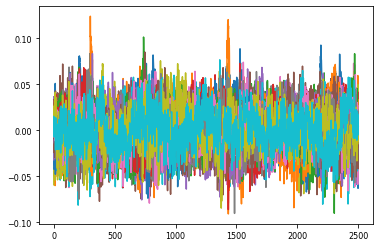

In [324]:
plt.plot(ops['tPC'])

In [78]:
lft_whisk_temp=np.zeros(F.shape[1], dtype=np.float16)
lft_whisk_temp=scipy.signal.resample(lft_whisk_dwnsamp, F.shape[1], axis=0)
lft_whisk_native=np.zeros(F.shape[1])
lft_whisk_native=lft_whisk_temp[:]
np.save(save_path+'/lft_whisk_native_l.npy',lft_whisk_native_l)

In [75]:
lft_whisk_temp=np.zeros(F.shape[1], dtype=np.float16)
lft_whisk_temp=scipy.signal.resample(lft_whisk_dwnsamp, F.shape[1], axis=0)

In [76]:
lft_whisk_temp=np.zeros(F.shape[1]+1, dtype=np.float16)
lft_whisk_temp=scipy.signal.resample(lft_whisk_dwnsamp, F.shape[1]+1, axis=0)
lft_whisk_native_l=np.zeros(F.shape[1]+1)
lft_whisk_native_l[:]=lft_whisk_temp[:,0]
np.save(save_path+'/lft_whisk_native_l.npy',lft_whisk_native_l)

In [77]:
lft_whisk_temp=np.zeros(F.shape[1]-1, dtype=np.float16)
lft_whisk_temp=scipy.signal.resample(lft_whisk_dwnsamp, F.shape[1]-1, axis=0)
lft_whisk_native_s=np.zeros(F.shape[1]-1)
lft_whisk_native_s[:]=lft_whisk_temp[:,0]
np.save(save_path+'/lft_whisk_native_s.npy',lft_whisk_native_s)

In [35]:
lft_whisk_dwnsamp=lft_whisk_dwnsamp[:-1,:]

In [36]:
lft_whisk_dwnsamp.shape

(53974, 1)

In [37]:
rt_whisk_dwnsamp=rt_whisk_dwnsamp[:-1,:]

In [38]:
lft_ppl_upsamp.shape

(53974, 1)

In [39]:
rt_whisk_dwnsamp.shape

(53974, 1)

In [40]:
walk_dwnsamp=walk_dwnsamp[:-1,:]

In [41]:
walk_dwnsamp.shape

(53974, 1)

False

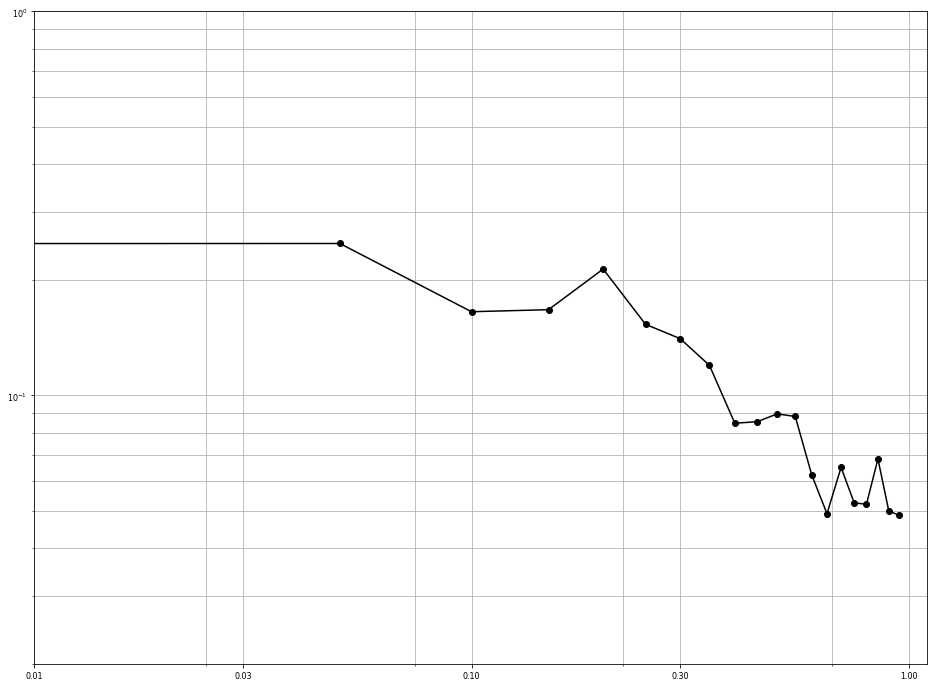

In [142]:
f=np.zeros(int(f_pts))
for i in range(0,int(f_pts)):
    f[i]=(i*(rate/2))/(f_pts-1)
Cxy_ser=pd.Series(Cxy[0:m.floor((rate*(win_len/2)+1)/(rate/2))])
f_ser=pd.Series(f[0:m.floor((rate*(win_len/2)+1)/(rate/2))])
Cxy_ser_smth=pd.Series(Cxy[0:m.floor(((rate*(win_len/2)+1)/(rate/2))/10)])
f_ser_smth=pd.Series(f[0:m.floor(((rate*(win_len/2)+1)/(rate/2))/10)])

for i in range(0,m.floor(((rate*(win_len/2)+1)/(rate/2))/10)):
    if i<1:
        Cxy_ser_smth[i]=pd.Series.mean(Cxy_ser[0:4])
        f_ser_smth[i]=0
    elif i<(m.floor(((rate*(win_len/2)+1)/(rate/2))/10)-1):
        Cxy_ser_smth[i]=pd.Series.mean(Cxy_ser[((i*10)-5):((i*10)+4)])
        f_ser_smth[i]=f[i]*rate
    else:
        Cxy_ser_smth[i]=pd.Series.mean(Cxy_ser[((i*10)-5):(i*10)])
        f_ser_smth[i]=f[i]*rate

fig = plt.figure(figsize=(16,12))
axj = fig.add_subplot(1,1,1)
plt.semilogy(f_ser_smth, Cxy_ser_smth, color='black', marker='o')

axj.set_xscale('log',base=3)
axj.set_ylim(0.02,1)
#axj.set_xlim(0.001,1)
axj.set_xticks([0.01,0.03,0.1,0.3,1])
axj.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
axj.grid(b="True", which="both")

Cxy_ser_smth[1:8].is_monotonic_decreasing

In [116]:
lft_whisk_corr.shape

(3897,)

In [53]:
ncells

3897

In [56]:
grid_IDs[0]

0

In [57]:
grid_IDs[40]

0

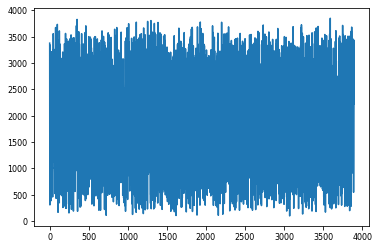

In [60]:
plt.plot(cell_loc_yflip_scale[:,0])

In [66]:
x_size.dtype

AttributeError: 'int' object has no attribute 'dtype'

In [67]:
print(float(x_size))

4000.0


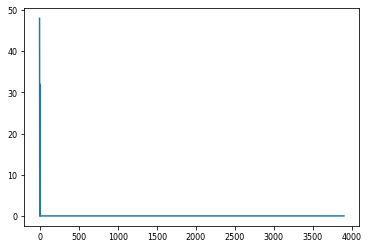

In [87]:
plt.plot(grid_IDs)

In [91]:
grid_IDs[500]

0.0

In [119]:
behav_corr_cell_loc_frame['lft_whisk']

0       0.538993
1      -0.320396
2      -0.153326
3      -0.362052
4      -0.231976
          ...   
3892    0.107595
3893    0.203238
3894    0.072824
3895    0.506714
3896    0.068920
Name: lft_whisk, Length: 3897, dtype: float64

In [120]:
behav_corr_cell_loc_frame[behav[0]]

0       0.538993
1      -0.320396
2      -0.153326
3      -0.362052
4      -0.231976
          ...   
3892    0.107595
3893    0.203238
3894    0.072824
3895    0.506714
3896    0.068920
Name: lft_whisk, Length: 3897, dtype: float64

In [149]:
F_df_cMat[0,3898]

-0.23032465923257836

In [148]:
F_df_cMat[0,1]

-0.2303246592325784

In [140]:
F_df_iscell_norm.shape

(3897, 24000)

In [153]:
F_df_iscell_norm.shape

(3897, 24000)

In [158]:
grid_count**2

100

In [156]:
grid_count

10

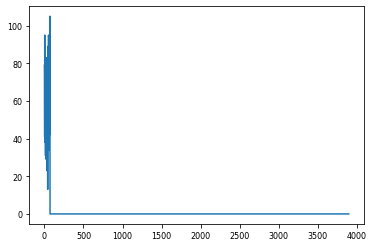

In [161]:
plt.plot(grid_IDs)

In [198]:
cell_loc_real=np.zeros((ncells,2),dtype=float)
j=0
for k in range(cell_loc.shape[0]):
    if iscell[k,0]==1:
        cell_loc_real[j,0]=cell_loc[k,0]
        cell_loc_real[j,1]=cell_loc[k,1]
        j=j+1
j=0
cell_loc_yflip=cell_loc_real
cell_loc_yflip[:,1]=max(cell_loc_yflip[:,1])-cell_loc_yflip[:,1]
cell_loc_yflip_scale=cell_loc_yflip
cell_loc_yflip_scale[:,0]=cell_loc_yflip_scale[:,0]*res
cell_loc_yflip_scale[:,1]=cell_loc_yflip_scale[:,1]*res
cell_loc_temp=cell_loc_yflip_scale

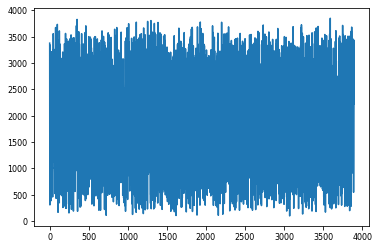

In [199]:
plt.plot(cell_loc_real[:,0])

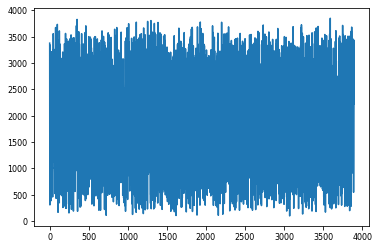

In [211]:
plt.plot(cell_loc_yflip_scale[:,0])

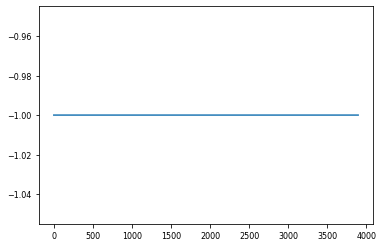

In [212]:
plt.plot(cell_loc_temp[:,0])

In [205]:
seed_cell

40

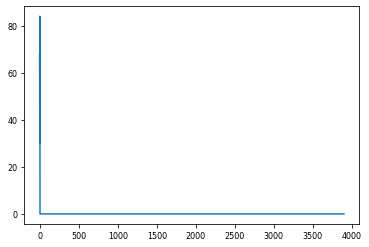

In [247]:
plt.plot(grid_IDs)

In [209]:
import copy as cp
cell_loc_temp=cp.copy(cell_loc_yflip_scale)

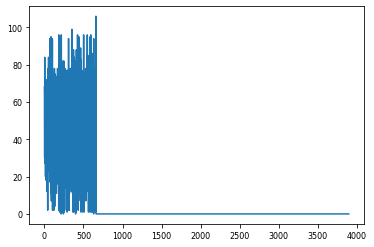

In [249]:
plt.plot(grid_IDs)

In [214]:
grid_count

10

In [230]:
print(m.floor(cell_loc_yflip_scale[10,0]/float(x_size))*grid_count)

0


In [231]:
print(grid_count)

10


In [234]:
print(cell_loc_yflip_scale[10,0])

3048.0


In [235]:
print(float(x_size))

4000.0


In [244]:
print(m.floor((cell_loc_yflip_scale[10,0]/float(x_size))*grid_count))

7


In [242]:
print(m.floor(0.762))

0


In [250]:
print(max(cell_loc_yflip_scale[:,0]))

3848.0


In [251]:
print(max(cell_loc_yflip_scale[:,1]))

3960.0


In [259]:
cell_cnt[seed_cell]

11

In [263]:
plt.plot(temp_corr[,:])

SyntaxError: invalid syntax (<ipython-input-263-bab277580ead>, line 1)

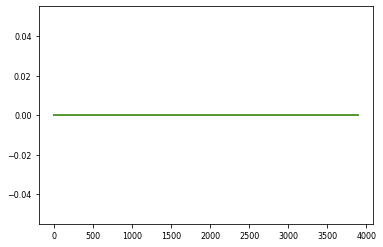

In [265]:
plt.plot(target_corr)

In [266]:
target_corr

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [269]:
seed_cell

94

In [285]:
target_corr[0,:]

array([ 0.09366065, -0.39982173, -0.12453897, -0.18478234, -0.07901666,
        0.26593495,  0.43865989,  0.25032977,  0.12252061])

In [273]:
F_df_cMat

array([[ 1.        , -0.23032466, -0.16887632, ...,  0.06615804,
         0.37113557,  0.05836044],
       [-0.23032466,  1.        ,  0.16168598, ...,  0.03507115,
        -0.14850244, -0.00789841],
       [-0.16887632,  0.16168598,  1.        , ..., -0.00334995,
        -0.11583816, -0.01680383],
       ...,
       [ 0.06615804,  0.03507115, -0.00334995, ...,  1.        ,
         0.04295509, -0.00696793],
       [ 0.37113557, -0.14850244, -0.11583816, ...,  0.04295509,
         1.        ,  0.00565322],
       [ 0.05836044, -0.00789841, -0.01680383, ..., -0.00696793,
         0.00565322,  1.        ]])

In [275]:
int(cell_cnt[seed_cell])

11

In [283]:
target_corr

array([[ 0.09366065, -0.39982173, -0.12453897, ...,  0.43865989,
         0.25032977,  0.12252061],
       [-0.19909882,  0.26241496,  0.08943106, ..., -0.35965457,
        -0.24255524, -0.18462521],
       [-0.09396141,  0.22181673, -0.03914011, ..., -0.22126939,
        -0.14128749, -0.10586921],
       ...,
       [-0.01172427, -0.04870671,  0.02325292, ...,  0.02648913,
         0.00943532,  0.01702562],
       [ 0.22838006, -0.33685392, -0.12458363, ...,  0.41756438,
         0.36092219,  0.27332605],
       [ 0.05124541, -0.07196855, -0.00366808, ...,  0.01858231,
         0.06587958,  0.05659077]])

In [281]:
F_df_cMat[2948,seed_ID[8]] 

0.15739731984136598

In [280]:
seed_ID[8]

2554

In [286]:
target_corr[0,:]

array([ 0.09366065, -0.39982173, -0.12453897, -0.18478234, -0.07901666,
        0.26593495,  0.43865989,  0.25032977,  0.12252061])

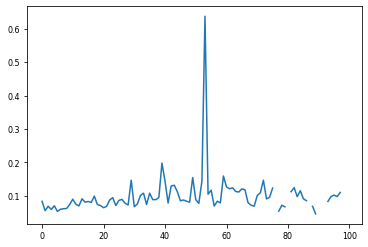

In [299]:
plt.plot(corr_means)

In [328]:
import math as m
m.sqrt(7591356)

print((ncells**2)-ncells)

15182712


In [329]:
ncells

3897

In [319]:
corr_iscell_zscore.shape

(7591356,)

In [330]:
temp_zscore=scipy.stats.zscore(F_df_cMat[0,0:ncells], axis=0, ddof=0, nan_policy='propagate')

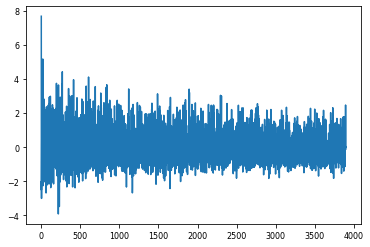

In [331]:
plt.plot(temp_zscore)

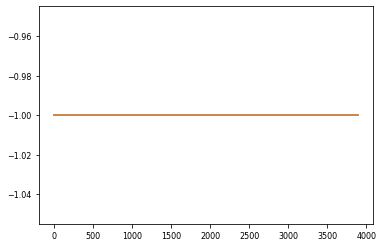

In [358]:
plt.plot(cell_loc_temp_target)

In [359]:
cell_loc_yflip_scale

array([[3376., 2644.],
       [1684., 2636.],
       [3148., 1310.],
       ...,
       [2216., 3800.],
       [2264., 2528.],
       [2598.,  412.]])

In [360]:
cell_loc_temp_target=cp.copy(cell_loc_yflip_scale)

In [361]:
cell_loc_temp_target

array([[3376., 2644.],
       [1684., 2636.],
       [3148., 1310.],
       ...,
       [2216., 3800.],
       [2264., 2528.],
       [2598.,  412.]])

In [362]:
temp_zscore[5,seed_ID[4]]

-1.8256903325103617

In [363]:
pairwise_zCut

2.5

In [365]:
ax1.hold()

AttributeError: 'AxesSubplot' object has no attribute 'hold'

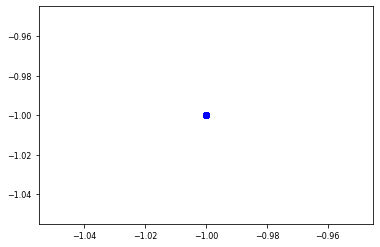

In [367]:
plt.scatter(cell_loc_temp_target[:,0],cell_loc_temp_target[:,1],c='blue')

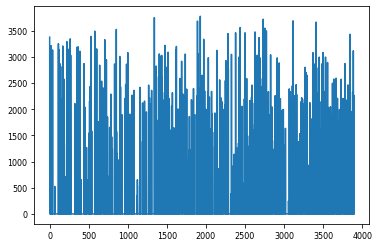

In [378]:
plt.plot(cell_loc_temp_target[:,0])

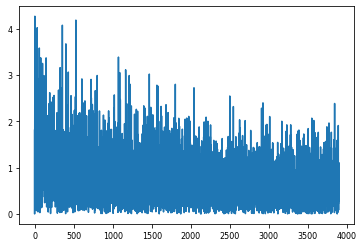

In [379]:
plt.plot(abs(temp_zscore[1,:]))

In [375]:
seed_ID

array([ 139,  547,  972, 1174, 1268, 1489, 1512, 2022, 2115, 2624, 2815,
       3710])

In [26]:
target_count

3513

In [386]:
fail_count

66897

In [387]:
len(seed_ID)*ncells

70146

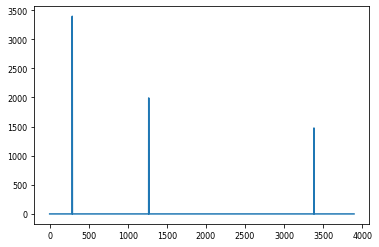

In [27]:
plt.plot(cell_loc_temp_target[:,0])

In [31]:
color=np.zeros(5)

In [32]:
color[1]='blue'

ValueError: could not convert string to float: 'blue'

In [37]:
color=[10]

In [34]:
color.append('blue')

In [35]:
color

['blue']

In [36]:
color[0]

'blue'

In [38]:
color[0]='blue'

In [39]:
color

['blue']

In [41]:
color = ['' for i in range(ncells)]

In [42]:
color[100]

''

In [43]:
color[3]

''

In [44]:
color[3]='blue'

In [114]:
target_count

array([ 33., 101., 145.,  28.,  34.,   8.,  15.,  25.,  13.,   2.,  63.,
       159., 153., 127.,  96.,  70.,  73., 109.,  69.,  12.,  72.,  83.,
       134., 200., 107., 109.,  73.,  84.,  40.,  12.,  92.,  98., 118.,
         0., 172., 160.,  94.,  89.,  33.,  11.,   5.,  51.,  91.,  51.,
        57.,  56.,  96., 114.,  46.,   5.,  30., 108.,  56.,  72., 148.,
       169.,  42., 118.,  62.,   7.,   3.,  40.,  96., 102., 168., 220.,
        46., 125.,  79.,   4.,   2.,  11.,  78.,  70., 103.,  46.,   0.,
        22., 108.,  16.,   0.,  13.,  64.,  44.,  39.,  66.,  18.,   0.,
         9.,   5.,   0.,   4.,   0.,  16.,  48.,  97., 101.,   2.,   0.,
         4.])

In [160]:
ax1.labels

AttributeError: 'AxesSubplot' object has no attribute 'labels'

In [67]:
for i in range(0,len(seed_ID)):
    print(cell_loc_temp_target[seed_ID[i],1])

1976.0
1912.0
1980.0
1952.0
1972.0
1888.0
1884.0
1620.0
1824.0
1980.0
1904.0
1916.0


In [83]:
target_corr.shape

(3897, 16)

In [121]:
corr_hm_norm.shape

(10, 10)

In [119]:
max(corr_hm_norm[:,:])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [126]:
np.amax(corr_hm_norm)

nan

In [127]:
corr_hm_norm

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [145]:
m.log(64,2)

6.0

In [146]:
2**6

64

In [190]:
F_df_iscell_norm.shape

(3897, 24000)

In [171]:
walk_hot.shape

(24000,)

(array([[ 0.,  0.,  1., ..., 56., 21., 10.],
        [ 0.,  0.,  3., ...,  7.,  1.,  4.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 63., 27., 12.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <a list of 3897 BarContainer objects>)

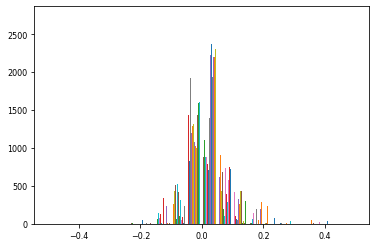

In [179]:
plt.hist(F_df_cMat[0:ncells,0:ncells],range=(-0.5,0.5),bins=20)

In [188]:
F_df_norm.shape

NameError: name 'F_df_norm' is not defined

In [181]:
behav_corr_cell_loc_frame

lft_whisk  rt_whisk   lft_ppl    rt_ppl      walk      0      1
0      0.538993  0.497685  0.118034  0.235518  0.042392  844.0  331.0
1     -0.320396 -0.343116 -0.093110 -0.360142 -0.153613  421.0  333.0
2     -0.153326 -0.166343 -0.126893 -0.318873 -0.083281  787.0  664.5
3     -0.362052 -0.374039 -0.052663 -0.176301 -0.171065   77.0  675.0
4     -0.231976 -0.259213  0.098662 -0.225554 -0.140245  448.0  176.0
...         ...       ...       ...       ...       ...    ...    ...
3892   0.107595  0.103925  0.023594  0.014778  0.052389  772.0  800.0
3893   0.203238  0.206662  0.050171  0.064821  0.210946  859.0  758.0
3894   0.072824  0.064876  0.067415  0.038261 -0.015398  554.0   42.0
3895   0.506714  0.506204 -0.002844  0.112726  0.140158  566.0  360.0
3896   0.068920  0.066659  0.005790  0.044135  0.050761  649.5  889.0

[3897 rows x 7 columns]

In [182]:
cell_loc_yflip_scale[0,:]

array([3376., 2644.])

In [187]:
max(behav_corr_cell_loc_frame.iloc[:,6])

992.0

In [195]:
df=mean_dF_F_walk_split

In [198]:
df=pd.DataFrame(mean_dF_F_walk_split)

0    1
0     0.065858  inf
1     0.153597  inf
2     0.081495  inf
3     0.192488  inf
4     0.222285  inf
...        ...  ...
3892  0.079031  inf
3893  0.083457  inf
3894  0.128366  inf
3895  0.048335  inf
3896  0.143376  inf

[3897 rows x 2 columns]

In [206]:
mean_dF_F_walk_split

array([[0.06585782,        inf],
       [0.15359719,        inf],
       [0.08149519,        inf],
       ...,
       [0.12836552,        inf],
       [0.04833452,        inf],
       [0.14337581,        inf]])

In [207]:
df.columns

Int64Index([0, 1], dtype='int64')

In [217]:
walk_hot_count

4996

In [216]:
walk_cold_count

19004

In [211]:
walk_hot

array([0., 0., 0., ..., 1., 1., 1.])

In [218]:
df

0         1
0     0.083171  0.175033
1     0.193977  0.030063
2     0.102920  0.049356
3     0.243092  0.074248
4     0.280722  0.020198
...        ...       ...
3892  0.099808  0.109355
3893  0.105397  0.132992
3894  0.162112  0.156940
3895  0.061041  0.116918
3896  0.181068  0.205767

[3897 rows x 2 columns]

(0.0, 0.5)

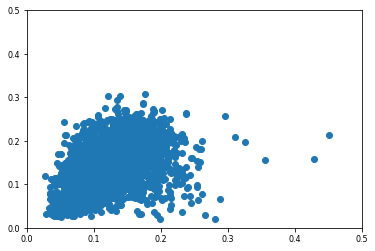

In [220]:
plt.scatter(df[0],df[1])
plt.xlim(0,0.5)
plt.ylim(0,0.5)

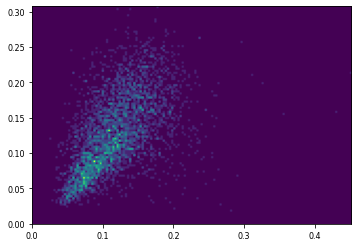

In [230]:
heatmap, xedges, yedges = np.histogram2d(df[0], df[1], bins=int(ncells/10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(0,max(df[0]))
plt.ylim(0,max(df[1]))
plt.show()

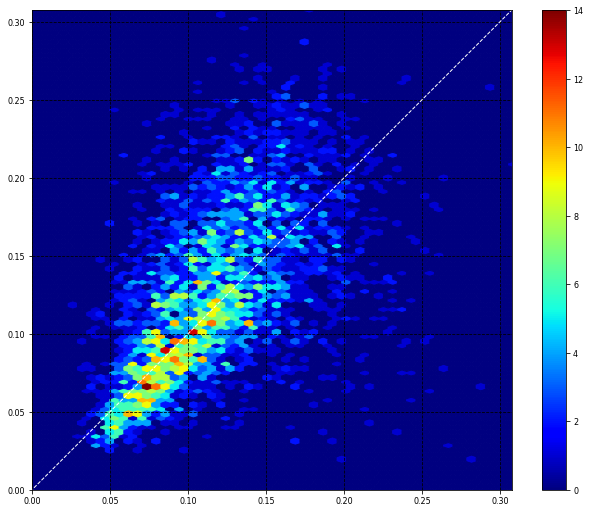

In [315]:
fig = plt.figure(figsize=(24,30))

ax0=fig.add_subplot(3,2,1)

plt.hexbin(df[0],df[1],gridsize=(int(ncells/20),int(ncells/20)),cmap=plt.cm.jet,)
ax0.set_xlim((0,max(df[1])))
ax0.set_ylim((0,max(df[1])))
x=np.arange(-1,max(df[0]),0.05)
y=x
plt.plot(x, y, '--', color = 'white', linewidth = 1)
x0,x1 = ax0.get_xlim()
y0,y1 = ax0.get_ylim()
ax0.set_aspect(abs(x1-x0)/abs(y1-y0))
ax0.grid(b=True, which='major', color='k', linestyle='--')
plt.colorbar()

In [326]:
whisk_hot_count

4452

In [332]:
combined_hot

array([0., 0., 0., ..., 1., 1., 1.])

In [341]:
cmb_hot_count+cmb_cold_count

24000

In [340]:
cmb_cold_count

11569

In [338]:
ncells/20

194.85

In [347]:
len(combined_hot)

24000

In [32]:
max(df[1])

0.40452260816812263

In [33]:
df[0]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3892   NaN
3893   NaN
3894   NaN
3895   NaN
3896   NaN
Name: 0, Length: 3897, dtype: float64

In [45]:
len(behav)

TypeError: Not a location id (invalid object ID)

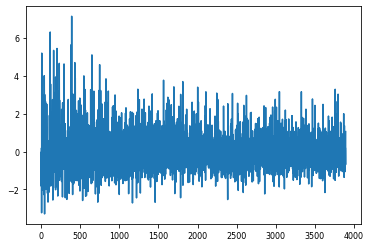

In [111]:
plt.plot(temp_zscore[100,:])

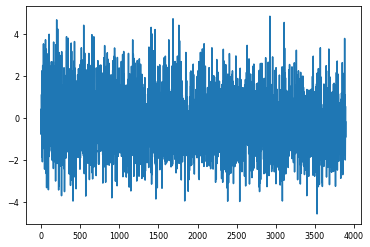

In [108]:
plt.plot(temp_zscore[:,5])

(array([  11.,   81.,  360., 1116., 1049.,  689.,  366.,  166.,   47.,
          12.]),
 array([-4.58014914, -3.63875824, -2.69736734, -1.75597643, -0.81458553,
         0.12680537,  1.06819627,  2.00958717,  2.95097808,  3.89236898,
         4.83375988]),
 <BarContainer object of 10 artists>)

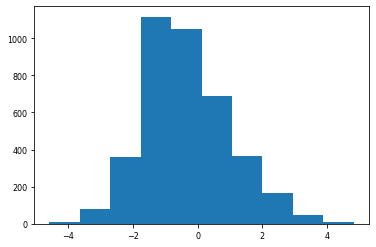

In [109]:
plt.hist(temp_zscore[:,5])

(array([  18.,  101.,  569., 1343., 1201.,  490.,  133.,   31.,    6.,
           5.]),
 array([-3.43916262, -2.58094001, -1.72271739, -0.86449477, -0.00627215,
         0.85195047,  1.71017308,  2.5683957 ,  3.42661832,  4.28484094,
         5.14306356]),
 <BarContainer object of 10 artists>)

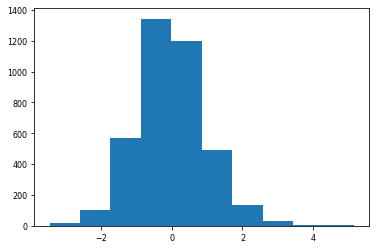

In [110]:
plt.hist(temp_zscore[5,:])

In [36]:
lft_whisk_dwnsamp

array([[0.0252331 ],
       [0.02426757],
       [0.02267523],
       ...,
       [0.02077909],
       [0.03083556],
       [0.03125811]])